In [1]:
import pandas as pd
import numpy as np
import datetime
import string
import nltk
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import Counter
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from sklearn.preprocessing import MultiLabelBinarizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
recall_score, precision_score, f1_score, roc_curve, roc_auc_score, auc
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE
from imblearn.under_sampling import NearMiss
from xgboost import XGBClassifier, plot_importance, plot_tree

starting_time = datetime.datetime.now()

# 1. Loading csv to dataframe and quick look into data

In [2]:
train_df = pd.read_csv('./datasets/train.csv')
test_df = pd.read_csv('./datasets/test.csv')
resources_df = pd.read_csv('./datasets/resources.csv')

In [3]:
train_df.head()

id                        teacher_id teacher_prefix school_state  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.           NV   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.           GA   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.           UT   
3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.           NC   
4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.           CA   

  project_submitted_datetime project_grade_category  \
0        2016-11-18 14:45:59          Grades PreK-2   
1        2017-04-26 15:57:28             Grades 3-5   
2        2017-01-01 22:57:44             Grades 3-5   
3        2016-08-12 15:42:11             Grades 3-5   
4        2016-08-06 09:09:11             Grades 6-8   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   
3                      Health & Sports   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1            Performing Arts, Team Sports   
2  Applied Sciences, Literature & Writing   
3                       Health & Wellness   
4                       Health & Wellness   

                                       project_title  \
0                           Super Sight Word Centers   
1                             Keep Calm and Dance On   
2                              Lets 3Doodle to Learn   
3  \"Kid Inspired\" Equipment to Increase Activit...   
4   We need clean water for our culinary arts class!   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   
3  My students are the greatest students but are ...   
4  My students are athletes and students who are ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   
3  The student's project which is totally \"kid-i...             NaN   
4  For some reason in our kitchen the water comes...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   
3             NaN  My students need balls and other activity equi...   
4             NaN  My students need a water filtration system for...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                            26                    1  
1                                             1                    0  
2                                             5                    1  
3                                            16                    0  
4                                            42                    1

In [4]:
test_df.head()

id                        teacher_id teacher_prefix school_state  \
0  p233245  5724a0c3ce11008366fff36dab4b943c            Ms.           CA   
1  p096795  445619941dc7cbe81c7be109dc61a56a           Mrs.           SC   
2  p236235  e92a4902b1611a189643d6f12c51e6a0           Mrs.           SC   
3  p233680  8e92622d2985d3faac1de71609c4be72           Mrs.           IA   
4  p171879  91a3c89981f626d9a0d067c65fb186ce            Mr.           CA   

  project_submitted_datetime project_grade_category  \
0        2016-04-27 13:45:41          Grades PreK-2   
1        2016-04-28 12:43:56             Grades 3-5   
2        2016-04-29 21:16:05          Grades PreK-2   
3        2016-04-27 22:32:43          Grades PreK-2   
4        2016-04-27 18:59:15             Grades 6-8   

            project_subject_categories      project_subject_subcategories  \
0                     Music & The Arts                        Visual Arts   
1  Literacy & Language, Math & Science  Literature & Writing, Mathematics   
2                       Math & Science      Applied Sciences, Mathematics   
3                  Literacy & Language                           Literacy   
4      Music & The Arts, Special Needs     Performing Arts, Special Needs   

                         project_title  \
0             Art Will Make You Happy!   
1            Keeping up with the TIMEs   
2  Building Bridges to Problem Solving   
3                    Classroom Library   
4                 Reeds so we can Read   

                                     project_essay_1  \
0  My 2nd grade students are amazing!  They are v...   
1  Students within the classroom work in small gr...   
2  My students share  a love of learning. These s...   
3  Reading is the gateway to the soul.  Guiding c...   
4  \"Mr. Reyes!  I need another reed!\"  I hear t...   

                                     project_essay_2  \
0  My class is made up of 12 boys and 12 girls.  ...   
1  My students are all very talented young indivi...   
2  My class consists of 14 energetic learners.  O...   
3  First graders enter the classroom each day rea...   
4  We have a diverse population with almost entir...   

                                     project_essay_3  \
0  My second grade class will really benefit from...   
1  We do a lot of small group, where the student ...   
2  These Fairy Tale Problem Solving STEM kits wil...   
3  Book bins will help to organize our classroom ...   
4  Each day in my class students consume supplies...   

                                     project_essay_4  \
0  The genorous donations to my project will make...   
1  This project is very important to my classroom...   
2  These materials will be help my students with ...   
3  When students begin the first grade, many are ...   
4  My students come from very troubled homes and ...   

                            project_resource_summary  \
0  My students need a drying rack for their art p...   
1  My students need Time Magazines for next year ...   
2  My students need to be mentally stimulated to ...   
3   My students need an organized classroom library.   
4  My students need reeds to perform in class eac...   

   teacher_number_of_previously_posted_projects  
0                                             2  
1                                             1  
2                                             0  
3                                             0  
4                                             1

In [5]:
resources_df.head()

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

In [6]:
print("train data shape",train_df.shape)
print("Total No of Projects in train.csv : ",len(train_df.id.unique()))
print("\ntest data shape",test_df.shape)
print("Total No of Projects in test.csv : ",len(test_df.id.unique()))
print("\nresources data shape",resources_df.shape)
print("Total No of Projects in resources.csv : ",len(resources_df.id.unique()))

train data shape (182080, 16)
Total No of Projects in train.csv :  182080

test data shape (78035, 15)
Total No of Projects in test.csv :  78035

resources data shape (1541272, 4)
Total No of Projects in resources.csv :  260115


In [7]:
# It found out that there are several projects under same project id.
# For train and test, there is no repetition or duplicated project.

resources_df[resources_df.id == 'p069063']

id                                        description  quantity  price
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3  14.95
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   8.45
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2  13.59
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3  24.95
5  p069063  Last to Finish: A Story About the Smartest Boy...         1  16.99
6  p069063  Mrs. Gorski, I Think I Have the Wiggle Fidgets...         1   9.95
7  p069063  See-N-Read 1503905CQ Reading Tool - Book Size,...         2  10.11

In [8]:
train_df.columns

Index(['id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

# 2. Aggregating Resource Data

In [9]:
resources_df['budget'] = resources_df.quantity * resources_df.price

In [10]:
resources_df.head(10)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   
5  p069063  Last to Finish: A Story About the Smartest Boy...         1   
6  p069063  Mrs. Gorski, I Think I Have the Wiggle Fidgets...         1   
7  p069063  See-N-Read 1503905CQ Reading Tool - Book Size,...         2   
8  p096795  Brewster WPD90218 Wall Pops Flirt Dot, Set of ...         2   
9  p096795  Brewster Wall Pops WPE99065 Peel & Stick Calyp...         2   

    price  budget  
0  149.00  149.00  
1   14.95   44.85  
2    8.45    8.45  
3   13.59   27.18  
4   24.95   74.85  
5   16.99   16.99  
6    9.95    9.95  
7   10.11   20.22  
8    9.95   19.90  
9    9.02   18.04

In [11]:
resources_df[resources_df.id == 'p069063'].plot(kind='box')


In [12]:
# Calculating bins "# of bins = square root of the # of data points"
bins = int(round(np.sqrt(len(resources_df[resources_df.id == 'p069063']))))

resources_df[resources_df.id == 'p069063']['budget'].plot(kind='hist', bins=bins)
plt.title('Project p069063 Budget', fontsize=16)
plt.xlabel('Budget', fontsize=14)
plt.show()
sns.distplot(resources_df[resources_df.id == 'p069063']['budget'])
plt.title('Project p069063 Budget', fontsize=16)
plt.show()

In [13]:
resource_budget = resources_df.groupby(['id'])['budget'].sum()
resource_budget = resource_budget.to_frame().reset_index()
resource_budget.head()

id   budget
0  p000001   833.63
1  p000002   630.28
2  p000003   298.97
3  p000004  1126.22
4  p000005   702.31

# 3. Combining train and test

In [14]:
whole_df = pd.concat([train_df,test_df], axis=0, ignore_index=True)
sequence = train_df.columns
whole_df = whole_df.reindex(columns=sequence)
whole_df.project_submitted_datetime = pd.to_datetime(whole_df.project_submitted_datetime)
whole_df.head()

id                        teacher_id teacher_prefix school_state  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.           NV   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.           GA   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.           UT   
3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.           NC   
4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.           CA   

  project_submitted_datetime project_grade_category  \
0        2016-11-18 14:45:59          Grades PreK-2   
1        2017-04-26 15:57:28             Grades 3-5   
2        2017-01-01 22:57:44             Grades 3-5   
3        2016-08-12 15:42:11             Grades 3-5   
4        2016-08-06 09:09:11             Grades 6-8   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   
3                      Health & Sports   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1            Performing Arts, Team Sports   
2  Applied Sciences, Literature & Writing   
3                       Health & Wellness   
4                       Health & Wellness   

                                       project_title  \
0                           Super Sight Word Centers   
1                             Keep Calm and Dance On   
2                              Lets 3Doodle to Learn   
3  \"Kid Inspired\" Equipment to Increase Activit...   
4   We need clean water for our culinary arts class!   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   
3  My students are the greatest students but are ...   
4  My students are athletes and students who are ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   
3  The student's project which is totally \"kid-i...             NaN   
4  For some reason in our kitchen the water comes...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   
3             NaN  My students need balls and other activity equi...   
4             NaN  My students need a water filtration system for...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                            26                  1.0  
1                                             1                  0.0  
2                                             5                  1.0  
3                                            16                  0.0  
4                                            42                  1.0

In [15]:
whole_df.tail()

id                        teacher_id teacher_prefix school_state  \
260110  p183993  be39c3d9b26cbb91f20435ba45e8451e           Mrs.           AL   
260111  p116343  90957869296e26198b1f162f169f8a55            Ms.           NM   
260112  p210728  692376a473aaf753890e329081b5787c           Mrs.           CA   
260113  p060531  0fcaec76e9ea1730e81f2ca8eae5891b           Mrs.           OR   
260114  p087783  d3fd1b7b0efff1eddbd3fbfe4c00711e           Mrs.           IN   

       project_submitted_datetime project_grade_category  \
260110        2017-04-07 07:48:40          Grades PreK-2   
260111        2017-04-25 17:46:26          Grades PreK-2   
260112        2017-04-17 17:53:12             Grades 6-8   
260113        2017-04-19 12:11:59             Grades 3-5   
260114        2017-04-27 19:50:35             Grades 3-5   

                   project_subject_categories  \
260110  Applied Learning, Literacy & Language   
260111                  Warmth, Care & Hunger   
260112                    Literacy & Language   
260113                  Warmth, Care & Hunger   
260114    Literacy & Language, Math & Science   

                  project_subject_subcategories  \
260110  Early Development, Literature & Writing   
260111                    Warmth, Care & Hunger   
260112           Literacy, Literature & Writing   
260113                    Warmth, Care & Hunger   
260114                    Literacy, Mathematics   

                                    project_title  \
260110                          iPad Intelligence   
260111  Clean Clothes Center- Finishing the Cycle   
260112                  Everyday Authors Among Us   
260113            Coat Lockers for Our Classroom!   
260114                    A Coffee Shop Classroom   

                                          project_essay_1  \
260110  I teach a diverse group of creative kindergart...   
260111  Many of our families do not have access to was...   
260112  My 6th grade students are a lively bunch of in...   
260113  In our classroom students celebrate their indi...   
260114  I am a teacher in a Title 1 K-5 elementary sch...   

                                          project_essay_2 project_essay_3  \
260110  My students will use the Apple iPad mini durin...             NaN   
260111  This clothes dryer will allow students that ha...             NaN   
260112  Every year, my 6th grade students write and pu...             NaN   
260113  At this time, my students place their personal...             NaN   
260114  I am gradually switching my classroom from tra...             NaN   

       project_essay_4                           project_resource_summary  \
260110             NaN  My students need one iPad mini to enhance thei...   
260111             NaN  My students need a clothes dryer to supplement...   
260112             NaN  My students need a variety of materials to use...   
260113             NaN  My students need coat lockers, so they have a ...   
260114             NaN  My students need flexible seating arrangements...   

        teacher_number_of_previously_posted_projects  project_is_approved  
260110                                            14                  NaN  
260111                                             1                  NaN  
260112                                             4                  NaN  
260113                                             9                  NaN  
260114                                             0                  NaN

In [16]:
whole_df = pd.merge(whole_df,resource_budget,on='id')
whole_df.head()

id                        teacher_id teacher_prefix school_state  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.           NV   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.           GA   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.           UT   
3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.           NC   
4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.           CA   

  project_submitted_datetime project_grade_category  \
0        2016-11-18 14:45:59          Grades PreK-2   
1        2017-04-26 15:57:28             Grades 3-5   
2        2017-01-01 22:57:44             Grades 3-5   
3        2016-08-12 15:42:11             Grades 3-5   
4        2016-08-06 09:09:11             Grades 6-8   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   
3                      Health & Sports   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1            Performing Arts, Team Sports   
2  Applied Sciences, Literature & Writing   
3                       Health & Wellness   
4                       Health & Wellness   

                                       project_title  \
0                           Super Sight Word Centers   
1                             Keep Calm and Dance On   
2                              Lets 3Doodle to Learn   
3  \"Kid Inspired\" Equipment to Increase Activit...   
4   We need clean water for our culinary arts class!   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   
3  My students are the greatest students but are ...   
4  My students are athletes and students who are ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   
3  The student's project which is totally \"kid-i...             NaN   
4  For some reason in our kitchen the water comes...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   
3             NaN  My students need balls and other activity equi...   
4             NaN  My students need a water filtration system for...   

   teacher_number_of_previously_posted_projects  project_is_approved  budget  
0                                            26                  1.0  899.94  
1                                             1                  0.0  400.00  
2                                             5                  1.0  469.99  
3                                            16                  0.0  684.47  
4                                            42                  1.0  711.00

# 4. Exploring Train Data

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182080 entries, 0 to 182079
Data columns (total 16 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

In [18]:
train_df.project_is_approved.value_counts()

1    154346
0     27734
Name: project_is_approved, dtype: int64

In [19]:
approve = train_df.project_is_approved.value_counts()[1] 
non_approve = train_df.project_is_approved.value_counts()[0]

frac = approve / non_approve
print("Approved project is {:.2f} times than not-approved project.".format(frac))

pct_of_approve = approve/(approve + non_approve)
print("percentage of approved project is", np.round(pct_of_approve*100), "%")
pct_of_non_approve = non_approve/(approve + non_approve)
print("percentage of not-approved project is", np.round(pct_of_non_approve*100), "%")

# Need to deal with imbalance class

Approved project is 5.57 times than not-approved project.
percentage of approved project is 85.0 %
percentage of not-approved project is 15.0 %


In [20]:
train_df[train_df.duplicated()]

# There is no duplicated row in train dataset.

Empty DataFrame
Columns: [id, teacher_id, teacher_prefix, school_state, project_submitted_datetime, project_grade_category, project_subject_categories, project_subject_subcategories, project_title, project_essay_1, project_essay_2, project_essay_3, project_essay_4, project_resource_summary, teacher_number_of_previously_posted_projects, project_is_approved]
Index: []

In [21]:
len(train_df.teacher_id.unique())

104414

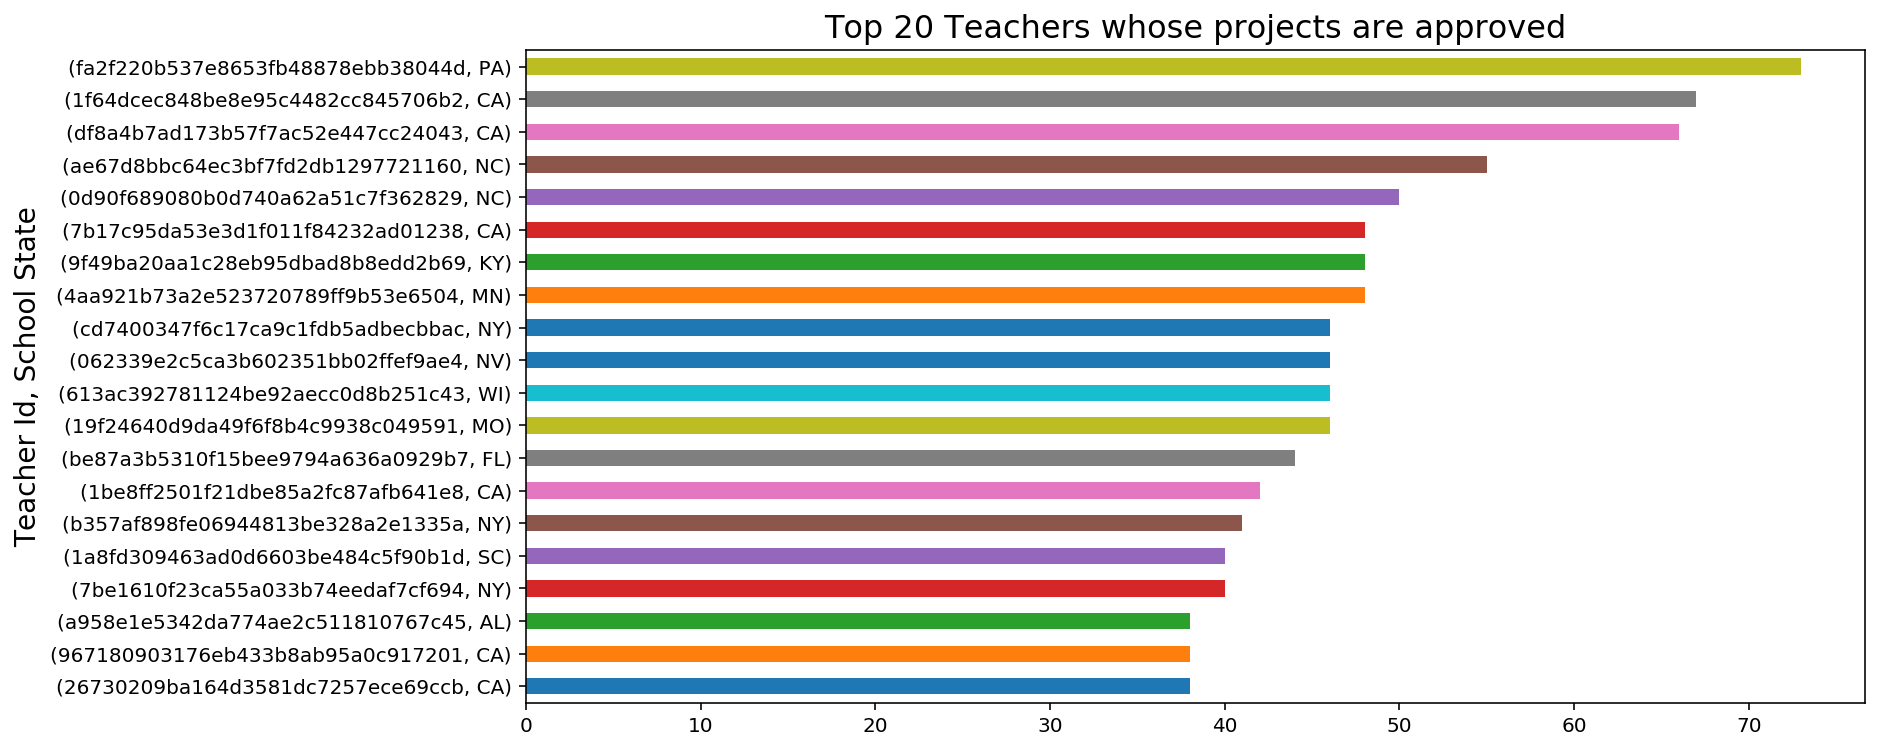

In [22]:
train_df.groupby(['teacher_id','school_state'])['project_is_approved'].sum() \
                    .sort_values(ascending=True).tail(20) \
                    .plot(kind='barh', figsize=(12,6), fontsize=10)
plt.title('Top 20 Teachers whose projects are approved', fontsize=16)
plt.ylabel('Teacher Id, School State', fontsize=14)
plt.show()

In [23]:
((train_df.groupby(['teacher_id'])['project_is_approved'].sum() / \
 train_df.groupby(['teacher_id'])['teacher_number_of_previously_posted_projects'].sum()
 ) * 100).dropna(inplace=False).head()

teacher_id
00000f7264c27ba6fea0c837ed6aa0aa     50.000000
00002d44003ed46b066607c5455a999a    100.000000
00006084c3d92d904a22e0a70f5c119a     66.666667
0000a9af8b6b9cc9e41f53322a8b8cf1     40.000000
0000d4777d14b33a1406dd6c9019fe89           inf
dtype: float64

In [24]:
len(train_df.teacher_id.unique())

104414

In [25]:
train_df.groupby('teacher_id')['id'].count().sort_values(ascending=False).head(10)

teacher_id
fa2f220b537e8653fb48878ebb38044d    74
df8a4b7ad173b57f7ac52e447cc24043    71
1f64dcec848be8e95c4482cc845706b2    70
ae67d8bbc64ec3bf7fd2db1297721160    58
0d90f689080b0d740a62a51c7f362829    51
062339e2c5ca3b602351bb02ffef9ae4    49
4aa921b73a2e523720789ff9b53e6504    48
7b17c95da53e3d1f011f84232ad01238    48
9f49ba20aa1c28eb95dbad8b8edd2b69    48
613ac392781124be92aecc0d8b251c43    47
Name: id, dtype: int64

In [26]:
train_df.groupby('teacher_id')['project_is_approved'].sum().sort_values(ascending=False).head(10)

teacher_id
fa2f220b537e8653fb48878ebb38044d    73
1f64dcec848be8e95c4482cc845706b2    67
df8a4b7ad173b57f7ac52e447cc24043    66
ae67d8bbc64ec3bf7fd2db1297721160    55
0d90f689080b0d740a62a51c7f362829    50
7b17c95da53e3d1f011f84232ad01238    48
4aa921b73a2e523720789ff9b53e6504    48
9f49ba20aa1c28eb95dbad8b8edd2b69    48
062339e2c5ca3b602351bb02ffef9ae4    46
cd7400347f6c17ca9c1fdb5adbecbbac    46
Name: project_is_approved, dtype: int64

In [27]:
# ((train_temp.groupby(['teacher_id'])['project_is_approved'].sum() / \
#  train_temp.teacher_idii.value_counts()
#  ) * 100).sort_values(ascending=False).plot(kind='bar', figsize=(12,6), fontsize=10)
# plt.title('Project Approving Percentage by teacher_id', fontsize=16)
# plt.xlabel('teacher_id', fontsize=14)
# plt.show()

# 5. Exploring Whole Dataset

In [28]:
whole_df[whole_df.duplicated()]

# There is no duplicated row in train dataset.

Empty DataFrame
Columns: [id, teacher_id, teacher_prefix, school_state, project_submitted_datetime, project_grade_category, project_subject_categories, project_subject_subcategories, project_title, project_essay_1, project_essay_2, project_essay_3, project_essay_4, project_resource_summary, teacher_number_of_previously_posted_projects, project_is_approved, budget]
Index: []

In [29]:
# Calculating bins "# of bins = square root of the # of data points"
bins = int(round(np.sqrt(len(train_df))))

whole_df.teacher_number_of_previously_posted_projects.plot(kind='hist', 
                                                           bins = bins,
                                                           figsize=(10,8))
plt.title('Distribution for No of Previously Posted Projects by Teachers', fontsize=14)
plt.xlabel('No of Previously Posted Projects', fontsize=12)
plt.ylabel('No of Teachers',fontsize=12)
plt.show()
plt.show()

### 5.1 Observing Gender to see if it should be included as features or not

In [30]:
whole_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260115 entries, 0 to 260114
Data columns (total 17 columns):
id                                              260115 non-null object
teacher_id                                      260115 non-null object
teacher_prefix                                  260110 non-null object
school_state                                    260115 non-null object
project_submitted_datetime                      260115 non-null datetime64[ns]
project_grade_category                          260115 non-null object
project_subject_categories                      260115 non-null object
project_subject_subcategories                   260115 non-null object
project_title                                   260115 non-null object
project_essay_1                                 260115 non-null object
project_essay_2                                 260115 non-null object
project_essay_3                                 9078 non-null object
project_essay_4                

In [31]:
print(whole_df.teacher_prefix.unique())
whole_df.teacher_prefix.value_counts()

['Ms.' 'Mrs.' 'Mr.' 'Teacher' 'Dr.' nan]


Mrs.       136387
Ms.         92651
Mr.         25462
Teacher      5569
Dr.            41
Name: teacher_prefix, dtype: int64

In [32]:
def gender(x):
    if x == 'Ms.' or x == 'Mrs.':
        return 'female'
    elif x == 'Mr.':
        return 'male'
    elif x == 'Dr.' or x == 'Teacher':
        return 'neutral'
    else:
        return 'none'

In [33]:
whole_df.insert(loc=3, column='gender', value=list(whole_df.teacher_prefix.apply(gender)))
whole_df.head()

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   
3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.    male   
4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.    male   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   
3           NC        2016-08-12 15:42:11             Grades 3-5   
4           CA        2016-08-06 09:09:11             Grades 6-8   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   
3                      Health & Sports   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1            Performing Arts, Team Sports   
2  Applied Sciences, Literature & Writing   
3                       Health & Wellness   
4                       Health & Wellness   

                                       project_title  \
0                           Super Sight Word Centers   
1                             Keep Calm and Dance On   
2                              Lets 3Doodle to Learn   
3  \"Kid Inspired\" Equipment to Increase Activit...   
4   We need clean water for our culinary arts class!   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   
3  My students are the greatest students but are ...   
4  My students are athletes and students who are ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   
3  The student's project which is totally \"kid-i...             NaN   
4  For some reason in our kitchen the water comes...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   
3             NaN  My students need balls and other activity equi...   
4             NaN  My students need a water filtration system for...   

   teacher_number_of_previously_posted_projects  project_is_approved  budget  
0                                            26                  1.0  899.94  
1                                             1                  0.0  400.00  
2                                             5                  1.0  469.99  
3                                            16                  0.0  684.47  
4                                            42                  1.0  711.00

In [34]:
whole_df[whole_df.teacher_prefix.isnull()]

# but it is taken care of by gender row. When i do dummy, it'll be dropped anyway.
# no need to drop or futher process.

id                        teacher_id teacher_prefix gender  \
17809   p180947  834f75f1b5e24bd10abe9c3dbf7ba12f            NaN   none   
22174   p002730  339bd5a9e445d68a74d65b99cd325397            NaN   none   
127966  p153408  339bd5a9e445d68a74d65b99cd325397            NaN   none   
158692  p197901  e4be6aaaa887d4202df2b647fbfc82bb            NaN   none   
185014  p252889  e629ce000cfa93c84659dfbcaf4f504f            NaN   none   

       school_state project_submitted_datetime project_grade_category  \
17809            CA        2016-11-04 00:15:45             Grades 3-5   
22174            SC        2016-05-09 09:38:40            Grades 9-12   
127966           SC        2016-05-10 15:18:23            Grades 9-12   
158692           PA        2016-06-03 10:15:05             Grades 3-5   
185014           CA        2016-05-21 13:05:33             Grades 6-8   

                 project_subject_categories  \
17809   Literacy & Language, Math & Science   
22174                   Literacy & Language   
127966                  Literacy & Language   
158692  Literacy & Language, Math & Science   
185014      Math & Science, Health & Sports   

            project_subject_subcategories  \
17809   Literature & Writing, Mathematics   
22174                Literature & Writing   
127966               Literature & Writing   
158692              Literacy, Mathematics   
185014           Mathematics, Team Sports   

                                           project_title  \
17809   1:7 Increasing Tech to Decrease Achievement Gaps   
22174                            iPads for STEM Stations   
127966                iPad for STEM and Literacy Station   
158692                                   Document Camera   
185014                A Smarter Way To Be A Hoop-er Star   

                                          project_essay_1  \
17809   The children at Anna Yates Elementary school a...   
22174   Within the next 20 years, every job will invol...   
127966  Within the next 20 years, every job will invol...   
158692  Students at Robertsdale Elementary live in a l...   
185014  The majority of our students are of Latino her...   

                                          project_essay_2  \
17809   My goal is to bring in 1 laptop for every 7 st...   
22174   The students in our school come from a wide va...   
127966  The students in our school come from a wide va...   
158692  This SMART Document Camera will improve my stu...   
185014  By helping our students get Wilson X connected...   

                                          project_essay_3  \
17809                                                 NaN   
22174   Students will use the iPad station for individ...   
127966  Students will use the iPad at the iPad station...   
158692                                                NaN   
185014                                                NaN   

                                          project_essay_4  \
17809                                                 NaN   
22174   Your generosity will allow my students to work...   
127966  Your generosity will allow my students to work...   
158692                                                NaN   
185014                                                NaN   

                                 project_resource_summary  \
17809   My students need a classroom laptop that is ju...   
22174         My students need 5 iPads for STEM stations.   
127966  My students need 5 iPads with protection plans...   
158692  My students need a Smart Document Camera to en...   
185014  My students need WIlson X Connected smart bask...   

        teacher_number_of_previously_posted_projects  project_is_approved  \
17809                                              1                  1.0   
22174                                              0                  1.0   
127966                                             1                  1.0   
158692                                             0             

In [35]:
train_temp = train_df.copy()
train_temp.insert(loc=3, column='gender', 
                  value=list(train_temp.teacher_prefix.apply(gender)))
train_temp.head(3)

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   

            project_subject_subcategories             project_title  \
0                                Literacy  Super Sight Word Centers   
1            Performing Arts, Team Sports    Keep Calm and Dance On   
2  Applied Sciences, Literature & Writing     Lets 3Doodle to Learn   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                            26                    1  
1                                             1                    0  
2                                             5                    1

In [199]:
train_temp_mf = train_temp[(train_temp.gender == 'female') | (train_temp.gender == 'male')]
train_temp_mf.sample(5)

id                        teacher_id teacher_prefix  gender  \
142762  p078613  5c239347d381a24167a68ced09cfbed3           Mrs.  female   
135738  p021382  27c19f3936928ac16e8490f3e877f9b7            Ms.  female   
131148  p191114  164eb3710b4f9e54b433ecc1bd67142d           Mrs.  female   
95092   p121157  a6380f03623b9de5925cf8547ca5611e           Mrs.  female   
60929   p197810  b743d4b8640c871351507361e80c8eb3           Mrs.  female   

       school_state project_submitted_datetime project_grade_category  \
142762           OK        2016-08-28 21:46:33          Grades PreK-2   
135738           AZ        2016-06-27 16:52:00          Grades PreK-2   
131148           VA        2016-07-30 12:14:02             Grades 6-8   
95092            FL        2017-02-20 11:41:35          Grades PreK-2   
60929            CA        2016-11-27 14:07:14            Grades 9-12   

                 project_subject_categories  \
142762  Literacy & Language, Math & Science   
135738  Literacy & Language, Math & Science   
131148                  Literacy & Language   
95092                 Warmth, Care & Hunger   
60929                 Warmth, Care & Hunger   

            project_subject_subcategories  \
142762              Literacy, Mathematics   
135738  Literature & Writing, Mathematics   
131148               Literature & Writing   
95092               Warmth, Care & Hunger   
60929               Warmth, Care & Hunger   

                                            project_title    ...     \
142762                    Kindergarten Loves Technology!!    ...      
135738                          Kindergarten Here I Come!    ...      
131148                Brilliant Minds Need a Room To Grow    ...      
95092   Basic School Supplies to Prepare my Students t...    ...      
60929                    Backpacks Help Organize Students    ...      

       project_essay_3 project_essay_4  \
142762             NaN             NaN   
135738             NaN             NaN   
131148             NaN             NaN   
95092              NaN             NaN   
60929              NaN             NaN   

                                 project_resource_summary  \
142762  My students need three mini iPads to use durin...   
135738  My students need the Transition to School Back...   
131148  My students need a 21st century seating arrang...   
95092   My students need a  are in need of basic schoo...   
60929   My students need 24 sturdy backpacks to carry ...   

       teacher_number_of_previously_posted_projects project_is_approved  \
142762                                            1                   1   
135738                                           14                   1   
131148                                            0                   0   
95092                                            10                   1   
60929                                            96                   1   

              date  year month  day      time  
142762  2016-08-28  2016     8   28  21:46:33  
135738  2016-06-27  2016     6   27  16:52:00  
131148  2016-07-30  2016     7   30  12:14:02  
95092   2017-02-20  2017     2   20  11:41:35  
60929   2016-11-27  2016    11   27  14:07:14  

[5 rows x 22 columns]

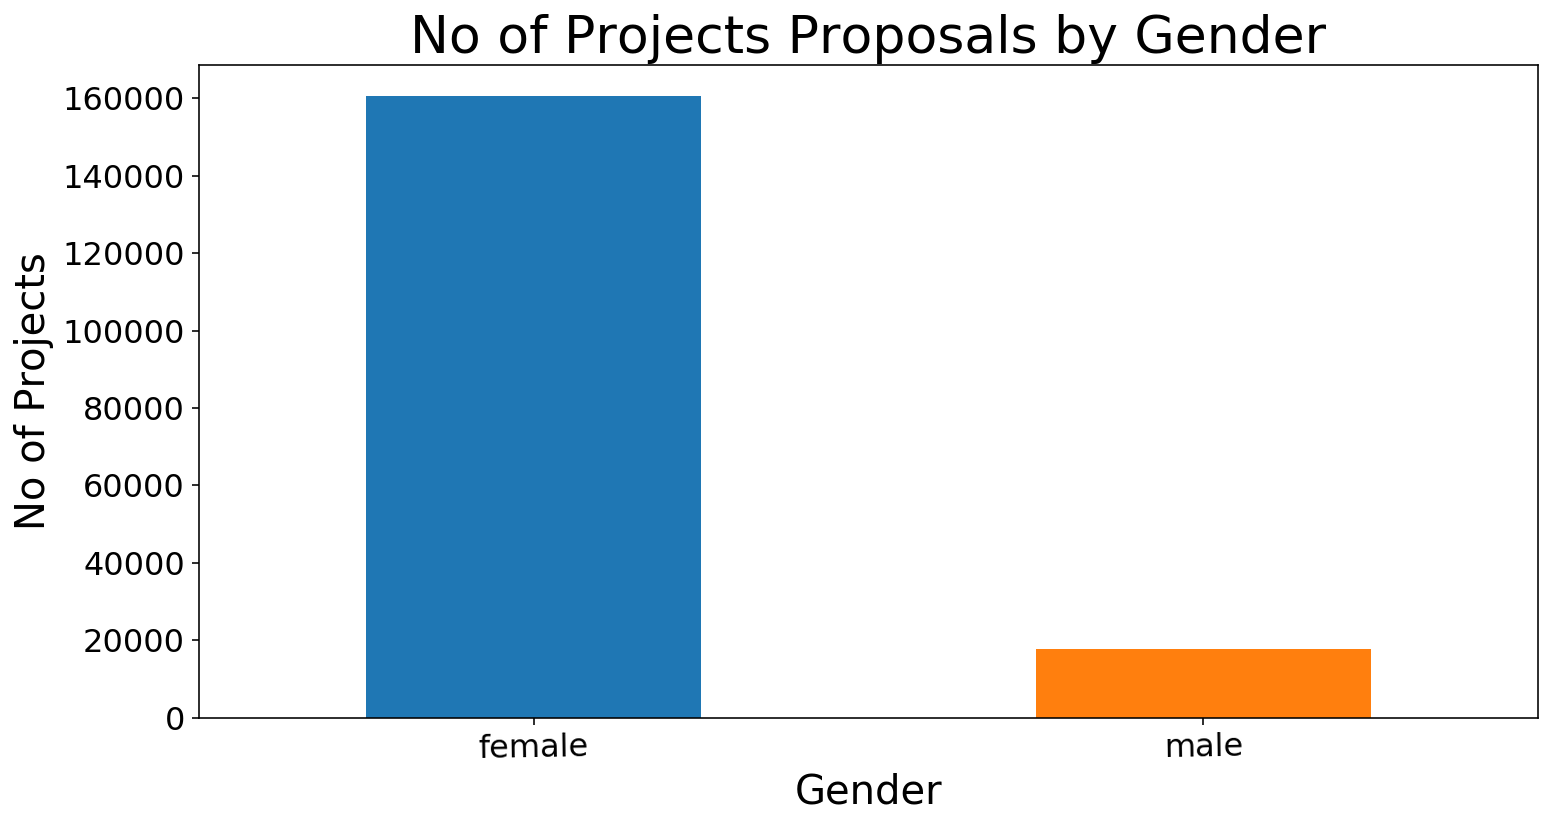

In [200]:
train_temp_mf.gender.value_counts().plot(kind='bar', rot = 1, fontsize=16, figsize = (12,6))
plt.title('No of Projects Proposals by Gender', fontsize=26)
plt.xlabel('Gender', fontsize=20)
plt.ylabel('No of Projects', fontsize=20)
plt.show()

In [201]:
((train_temp.groupby(['gender'])['project_is_approved'].sum() / \
 train_temp.gender.value_counts()
 ) * 100)

gender
female      84.961146
male        84.202185
neutral     79.431183
none       100.000000
dtype: float64

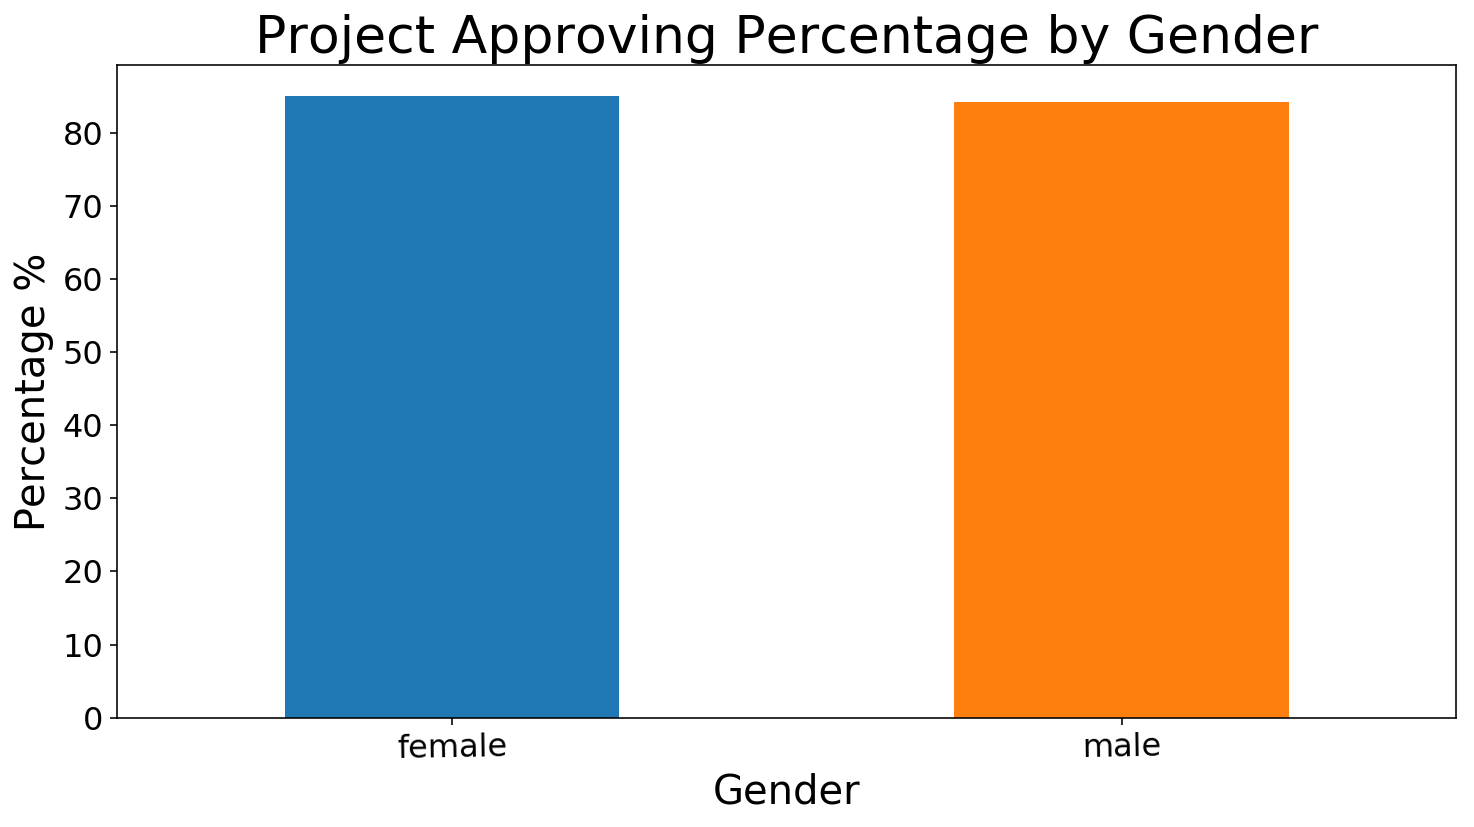

In [203]:
((train_temp_mf.groupby(['gender'])['project_is_approved'].sum() / \
 train_temp_mf.gender.value_counts()
 ) * 100).sort_values(ascending=False).plot(kind='bar', figsize=(12,6), fontsize=16, rot=1)
plt.title('Project Approving Percentage by Gender', fontsize=26)
plt.xlabel('Gender', fontsize=20)
plt.ylabel('Percentage %', fontsize=20)
plt.show()

In [39]:
# According to above finding, Gender is not the major factor in project proposal 
# approving since the approval % for each gender are about the same.

In [40]:
gender_features = pd.get_dummies(whole_df.gender, prefix = 'gender').iloc[:,:3]
# whole_df = pd.concat([whole_df,gender_dummy],axis=1)
# whole_df.head()

### 5.2 Adding Grade as features

In [41]:
whole_df.project_grade_category.isnull().unique()

array([False])

In [42]:
whole_df.project_grade_category.value_counts()

Grades PreK-2    105361
Grades 3-5        88327
Grades 6-8        40266
Grades 9-12       26161
Name: project_grade_category, dtype: int64

In [43]:
train_temp.project_grade_category.value_counts()

Grades PreK-2    73890
Grades 3-5       61682
Grades 6-8       28197
Grades 9-12      18311
Name: project_grade_category, dtype: int64

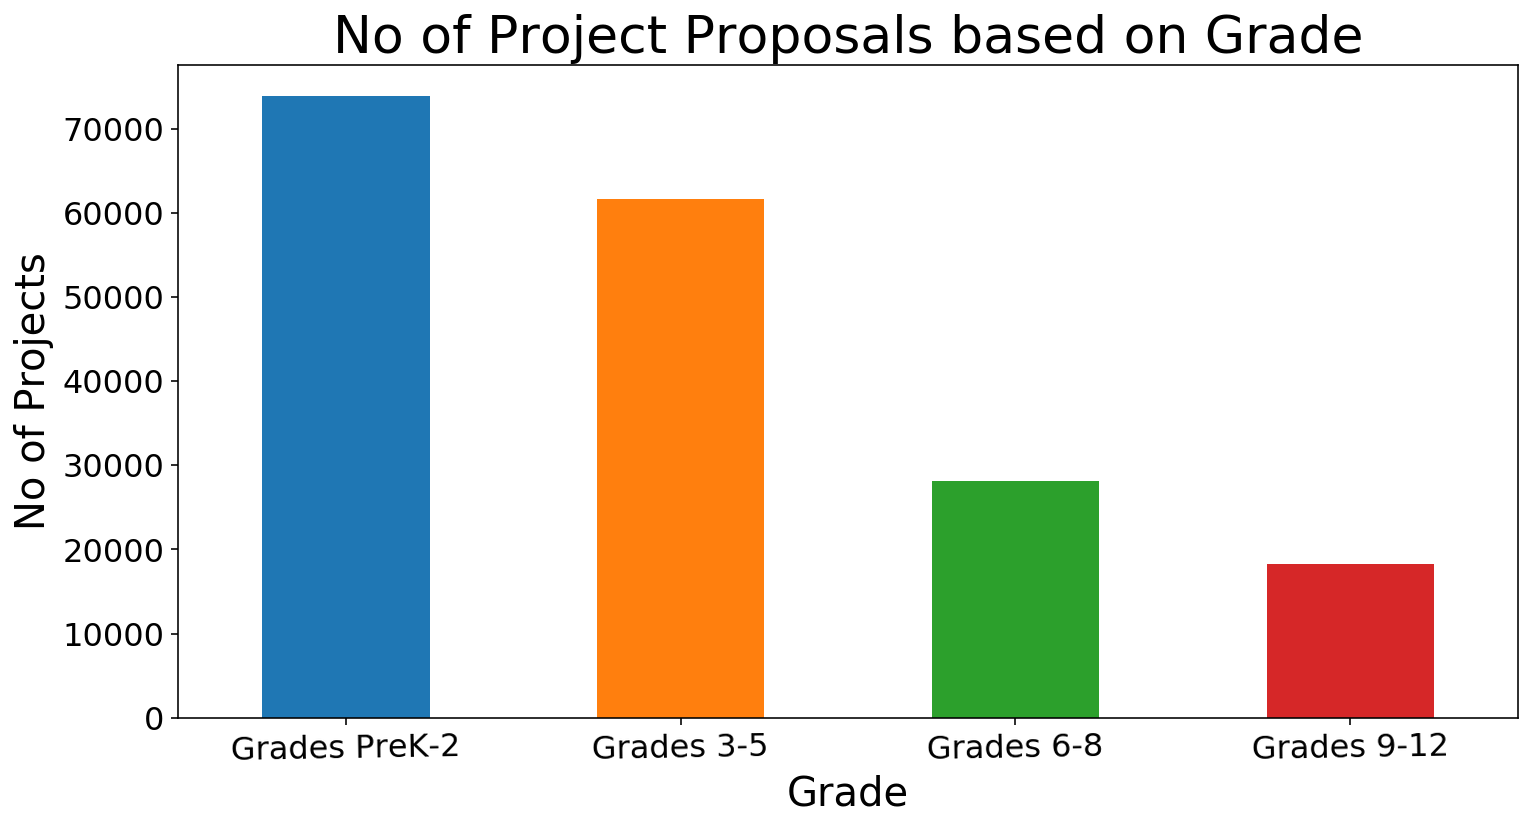

In [44]:
train_temp.project_grade_category.value_counts().plot(kind='bar',figsize=(12,6), fontsize=16, rot=1)
plt.title('No of Project Proposals based on Grade', fontsize=26)
plt.xlabel('Grade', fontsize=20)
plt.ylabel('No of Projects', fontsize=20)
plt.show()

In [45]:
((train_temp.groupby(['project_grade_category'])['project_is_approved'].sum() / \
 train_temp.project_grade_category.value_counts()
 ) * 100)

Grades 3-5       85.397685
Grades 6-8       84.345852
Grades 9-12      83.523565
Grades PreK-2    84.712410
dtype: float64

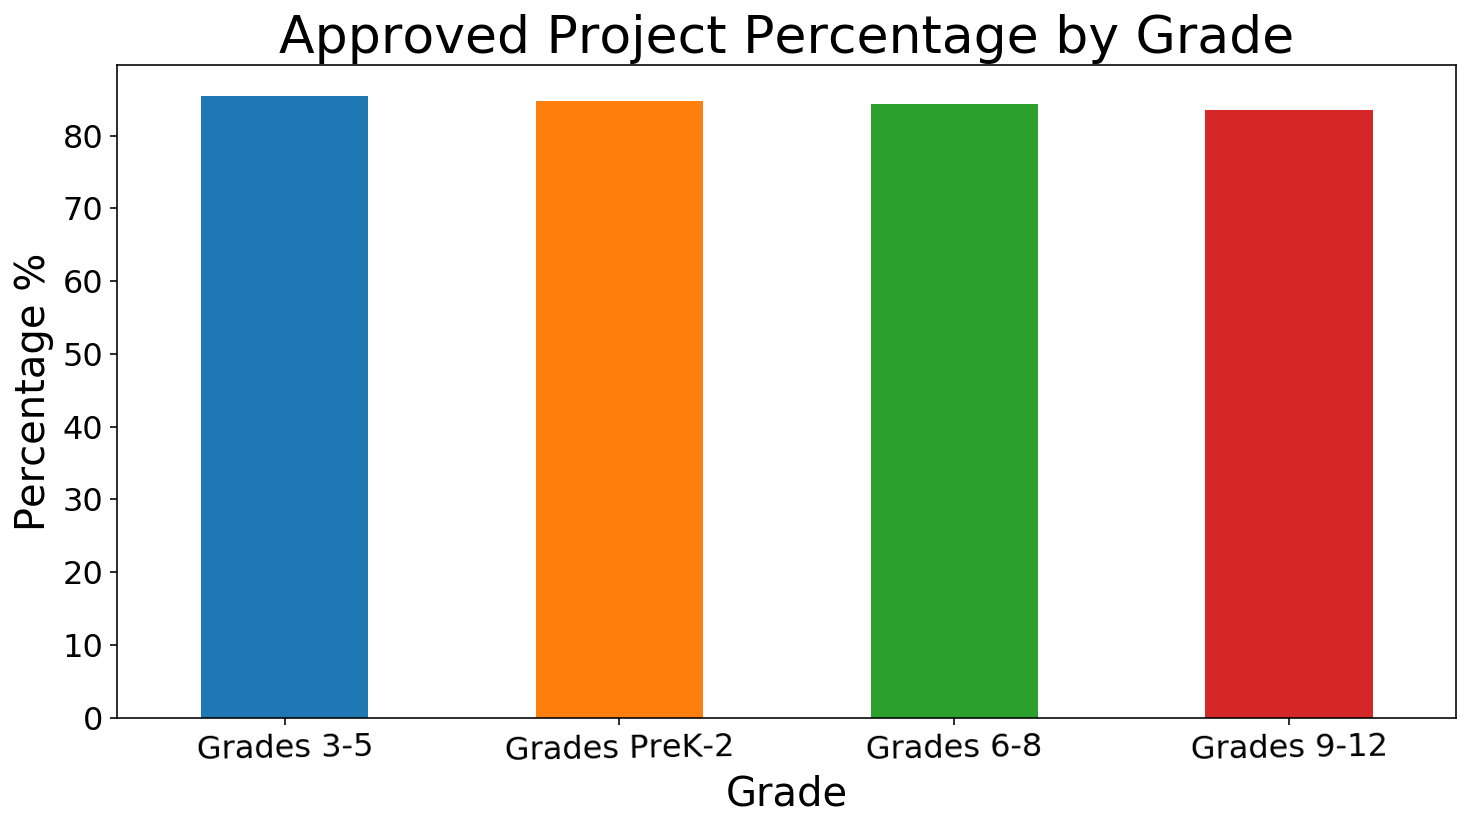

In [46]:
((train_temp.groupby(['project_grade_category'])['project_is_approved'].sum() / \
 train_temp.project_grade_category.value_counts()
 ) * 100).sort_values(ascending=False).plot(kind='bar', figsize=(12,6), fontsize=16, rot=1)
plt.title('Approved Project Percentage by Grade', fontsize=26)
plt.xlabel('Grade', fontsize=20)
plt.ylabel('Percentage %', fontsize=20)
plt.show()

In [47]:
grade_features = pd.get_dummies(whole_df.project_grade_category, prefix = 'grade')
grade_features.drop(['grade_Grades 9-12'], axis=1, inplace = True)
# whole_df = pd.concat([whole_df,grade_features],axis=1)
# whole_df.head()

### 5.3 Adding Subjects as features

In [48]:
print('Total Subject Categories :',len(whole_df.project_subject_categories.unique()))
whole_df.project_subject_categories.value_counts()

Total Subject Categories : 51


Literacy & Language                           56034
Math & Science                                40586
Literacy & Language, Math & Science           34947
Health & Sports                               24257
Music & The Arts                              12253
Special Needs                                 10199
Literacy & Language, Special Needs             9653
Applied Learning                               8972
Math & Science, Literacy & Language            5437
Applied Learning, Literacy & Language          5354
History & Civics                               4384
Math & Science, Special Needs                  4336
Literacy & Language, Music & The Arts          4130
Math & Science, Music & The Arts               3881
Applied Learning, Special Needs                3534
Health & Sports, Special Needs                 3388
History & Civics, Literacy & Language          3316
Warmth, Care & Hunger                          3178
Math & Science, Applied Learning               2989
Applied Lear

In [49]:
print('Total Subject Subcategories :',len(whole_df.project_subject_subcategories.unique()))
whole_df.project_subject_subcategories.value_counts()

Total Subject Subcategories : 416


Literacy                                        22634
Literacy, Mathematics                           19793
Literature & Writing, Mathematics               14224
Literacy, Literature & Writing                  13241
Mathematics                                     12913
Literature & Writing                            10629
Special Needs                                   10199
Health & Wellness                                8561
Applied Sciences, Mathematics                    8024
Literacy, Special Needs                          5905
Applied Sciences                                 5717
Gym & Fitness, Health & Wellness                 5454
Visual Arts                                      5277
ESL, Literacy                                    5089
Music                                            3453
Literature & Writing, Special Needs              3241
Warmth, Care & Hunger                            3178
Health & Wellness, Special Needs                 2916
Mathematics, Special Needs  

In [50]:
# Since subcategories is more specific and detail than categories by looking at their 
# total unique title, only subcategories shall be used as features.

In [51]:
print("No of Sub categories under category called Literacy & Language :", \
len(train_df[train_df.project_subject_categories == 'Literacy & Language']['project_subject_subcategories'].unique()))
train_df[train_df.project_subject_categories == 'Literacy & Language']\
                            ['project_subject_subcategories'].unique()


No of Sub categories under category called Literacy & Language : 10


array(['Literacy', 'Literature & Writing', 'ESL, Literacy',
       'Literacy, Literature & Writing', 'ESL, Literature & Writing',
       'Foreign Languages, Literacy', 'ESL', 'Foreign Languages',
       'Foreign Languages, Literature & Writing',
       'ESL, Foreign Languages'], dtype=object)

In [52]:
cat_features = pd.get_dummies(whole_df.project_subject_categories, prefix = 'cat')
cat_features.columns
#cat_features.drop(['cat_History & Civics, Warmth, Care & Hunger'], axis=1, inplace = True)

Index(['cat_Applied Learning', 'cat_Applied Learning, Health & Sports',
       'cat_Applied Learning, History & Civics',
       'cat_Applied Learning, Literacy & Language',
       'cat_Applied Learning, Math & Science',
       'cat_Applied Learning, Music & The Arts',
       'cat_Applied Learning, Special Needs',
       'cat_Applied Learning, Warmth, Care & Hunger', 'cat_Health & Sports',
       'cat_Health & Sports, Applied Learning',
       'cat_Health & Sports, History & Civics',
       'cat_Health & Sports, Literacy & Language',
       'cat_Health & Sports, Math & Science',
       'cat_Health & Sports, Music & The Arts',
       'cat_Health & Sports, Special Needs',
       'cat_Health & Sports, Warmth, Care & Hunger', 'cat_History & Civics',
       'cat_History & Civics, Applied Learning',
       'cat_History & Civics, Health & Sports',
       'cat_History & Civics, Literacy & Language',
       'cat_History & Civics, Math & Science',
       'cat_History & Civics, Music & The Arts',


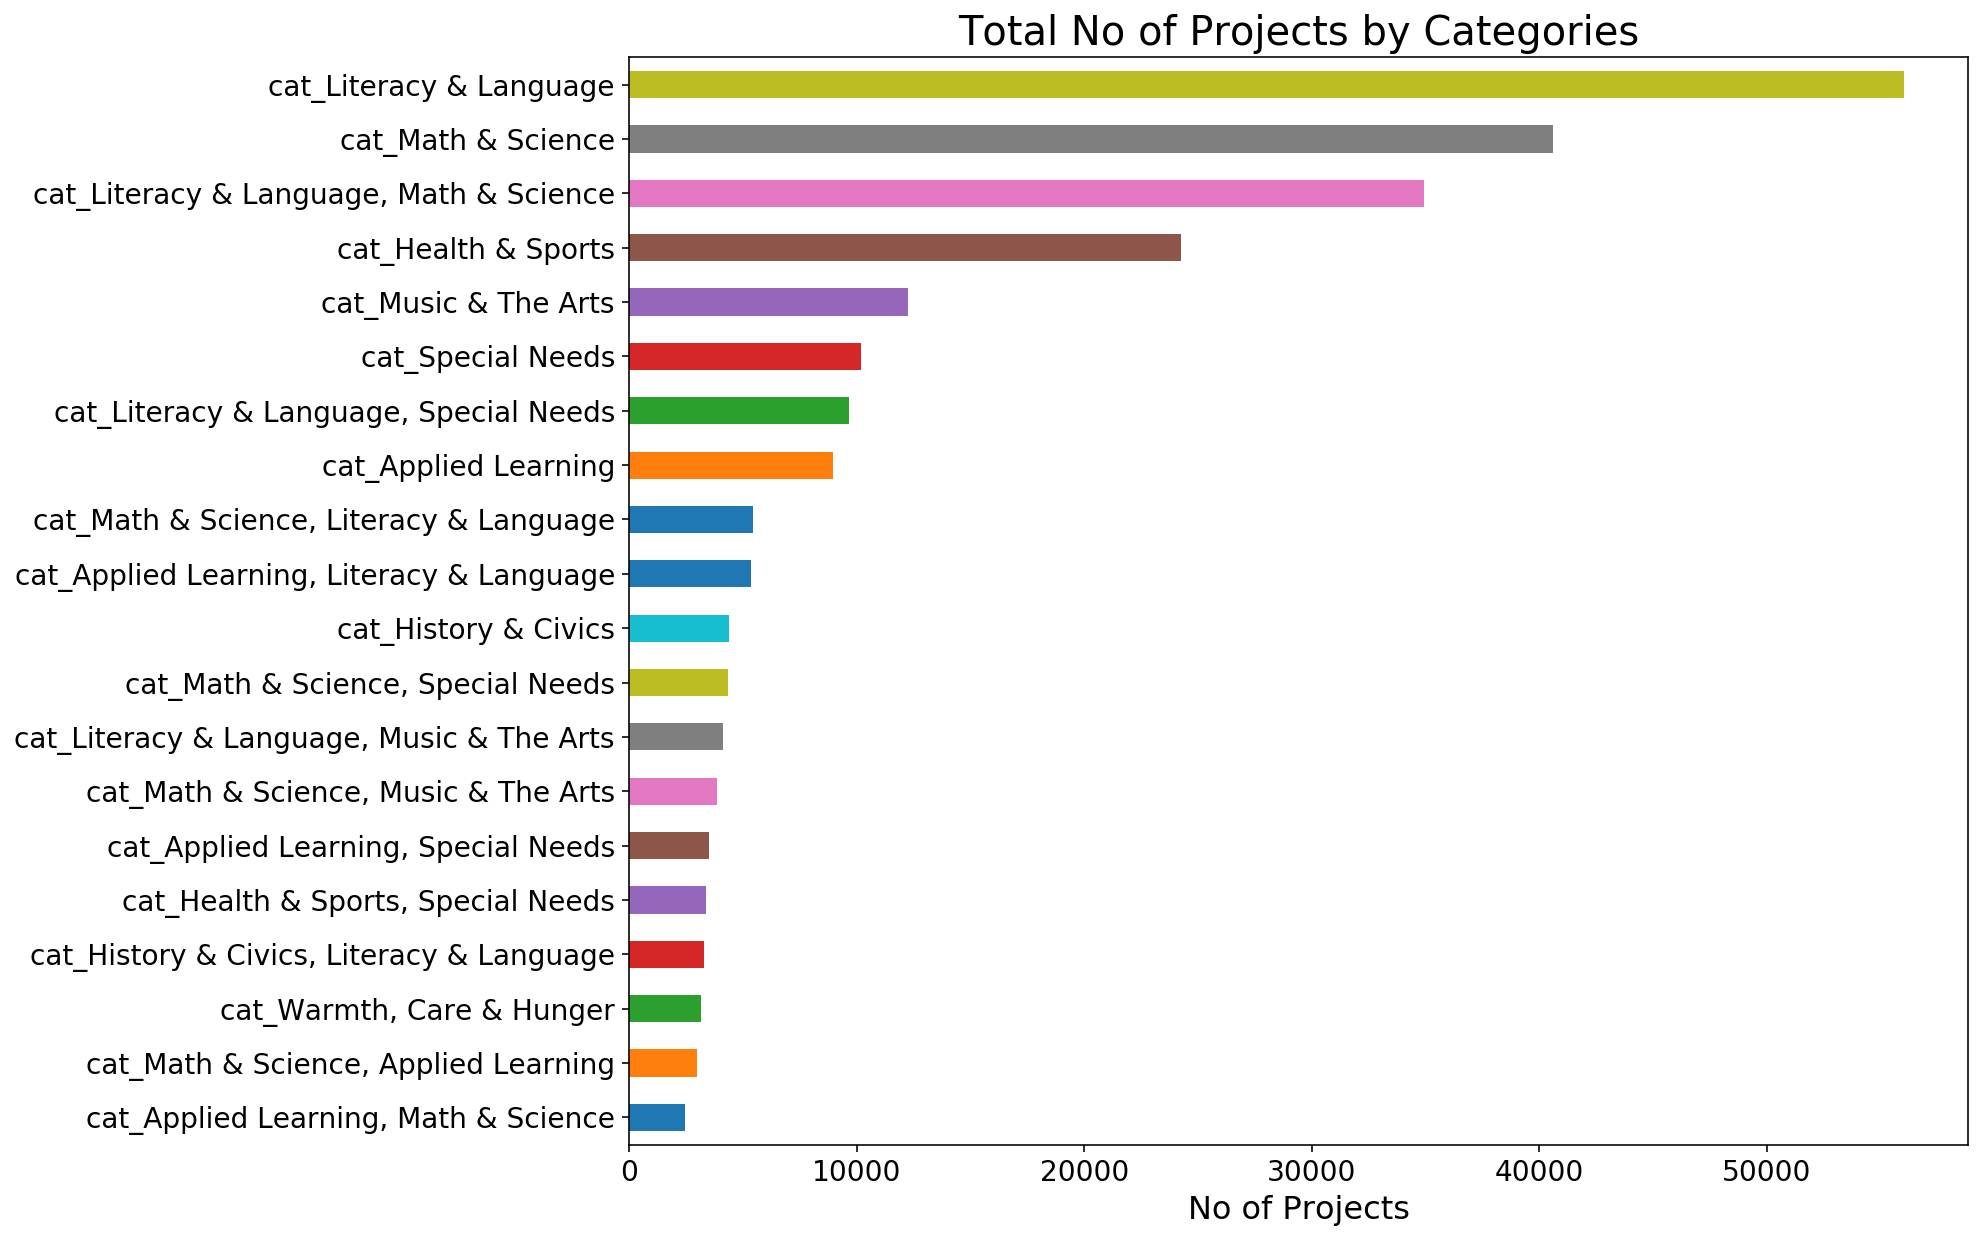

In [53]:
cat_features.sum().sort_values(ascending=False).head(20) \
                     .sort_values(ascending=True) \
                     .plot(kind='barh', figsize=(12,10), fontsize=14)
plt.title('Total No of Projects by Categories', fontsize=20)
plt.xlabel('No of Projects', fontsize=16)
plt.show()

In [54]:
cat_checking = train_df.groupby('project_subject_categories')['project_is_approved'].count()
cat_checking.to_frame().reset_index().sort_values(by='project_subject_categories', ascending=True)

project_subject_categories  project_is_approved
0                             Applied Learning                 6310
1            Applied Learning, Health & Sports                 1018
2           Applied Learning, History & Civics                  303
3        Applied Learning, Literacy & Language                 3725
4             Applied Learning, Math & Science                 1711
5           Applied Learning, Music & The Arts                 1241
6              Applied Learning, Special Needs                 2481
7      Applied Learning, Warmth, Care & Hunger                   22
8                              Health & Sports                16951
9            Health & Sports, Applied Learning                  297
10           Health & Sports, History & Civics                   67
11        Health & Sports, Literacy & Language                 1308
12             Health & Sports, Math & Science                  470
13           Health & Sports, Music & The Arts                  262
14              Health & Sports, Special Needs                 2368
15      Health & Sports, Warmth, Care & Hunger                   31
16                            History & Civics                 3065
17          History & Civics, Applied Learning                   65
18           History & Civics, Health & Sports                   20
19       History & Civics, Literacy & Language                 2288
20            History & Civics, Math & Science                  525
21          History & Civics, Music & The Arts                  544
22             History & Civics, Special Needs                  417
23     History & Civics, Warmth, Care & Hunger                    1
24                         Literacy & Language                39257
25       Literacy & Language, Applied Learning                 1038
26        Literacy & Language, Health & Sports                  127
27       Literacy & Language, History & Civics                 1315
28         Literacy & Language, Math & Science                24499
29       Literacy & Language, Music & The Arts                 2878
30          Literacy & Language, Special Needs                 6685
31  Literacy & Language, Warmth, Care & Hunger                   25
32                              Math & Science                28555
33            Math & Science, Applied Learning                 2071
34             Math & Science, Health & Sports                  697
35            Math & Science, History & Civics                 1087
36         Math & Science, Literacy & Language                 3843
37            Math & Science, Music & The Arts                 2761
38               Math & Science, Special Needs                 3010
39       Math & Science, Warmth, Care & Hunger                   19
40                            Music & The Arts                 8527
41          Music & The Arts, Applied Learning                   21
42           Music & The Arts, Health & Sports                   32
43          Music & The Arts, History & Civics                   29
44             Music & The Arts, Special Needs                  235
45     Music & The Arts, Warmth, Care & Hunger                    3
46                               Special Needs                 7065
47              Special Needs, Health & Sports                   64
48             Special Needs, Music & The Arts                  521
49        Special Needs, Warmth, Care & Hunger                   35
50                       Warmth, Care & Hunger                 2191

In [55]:
train_df.project_subject_categories.unique()

array(['Literacy & Language', 'Music & The Arts, Health & Sports',
       'Math & Science, Literacy & Language', 'Health & Sports',
       'Applied Learning, Literacy & Language', 'Math & Science',
       'Literacy & Language, Math & Science', 'Special Needs',
       'Applied Learning, Special Needs',
       'Applied Learning, Music & The Arts',
       'Math & Science, Special Needs', 'Health & Sports, Special Needs',
       'Literacy & Language, History & Civics',
       'Health & Sports, Literacy & Language', 'Music & The Arts',
       'Literacy & Language, Special Needs',
       'Special Needs, Music & The Arts', 'History & Civics',
       'Health & Sports, Applied Learning', 'Applied Learning',
       'Math & Science, Applied Learning',
       'Literacy & Language, Music & The Arts',
       'Math & Science, Music & The Arts',
       'History & Civics, Special Needs',
       'History & Civics, Literacy & Language', 'Warmth, Care & Hunger',
       'Math & Science, History & Civics',


In [56]:
# coutbycat = train_df.project_subject_categories.unique()
#coutbycat.to_frame().reset_index().sort_values(by='index', ascending=True)

In [57]:
#cat_checking[''] = train_df.project_subject_categories.value_counts()

In [58]:
# cat_checking = pd.DataFrame(columns = ['Cat','total_projects','approved'])
# cat_checking['Cat'] = train_df.project_subject_categories.unique()
# cat_checking['total_projects'] = train_df.groupby('project_subject_categories')['project_subject_subcategories'].count()
# cat_checking['approved'] = train_df.groupby('project_subject_categories')['project_subject_subcategories'].count()
# cat_checking['approve rate'] = cat_checking['total_projects'] / cat_checking['approved']
# cat_checking.head()

In [59]:
subcat_features = pd.get_dummies(whole_df.project_subject_subcategories, prefix = 'subcat')
subcat_features.drop(['subcat_Economics, Other'], axis=1, inplace = True)
subcat_features.shape
# whole_df = pd.concat([whole_df,subcat_features],axis=1)
# whole_df.head()

(260115, 415)

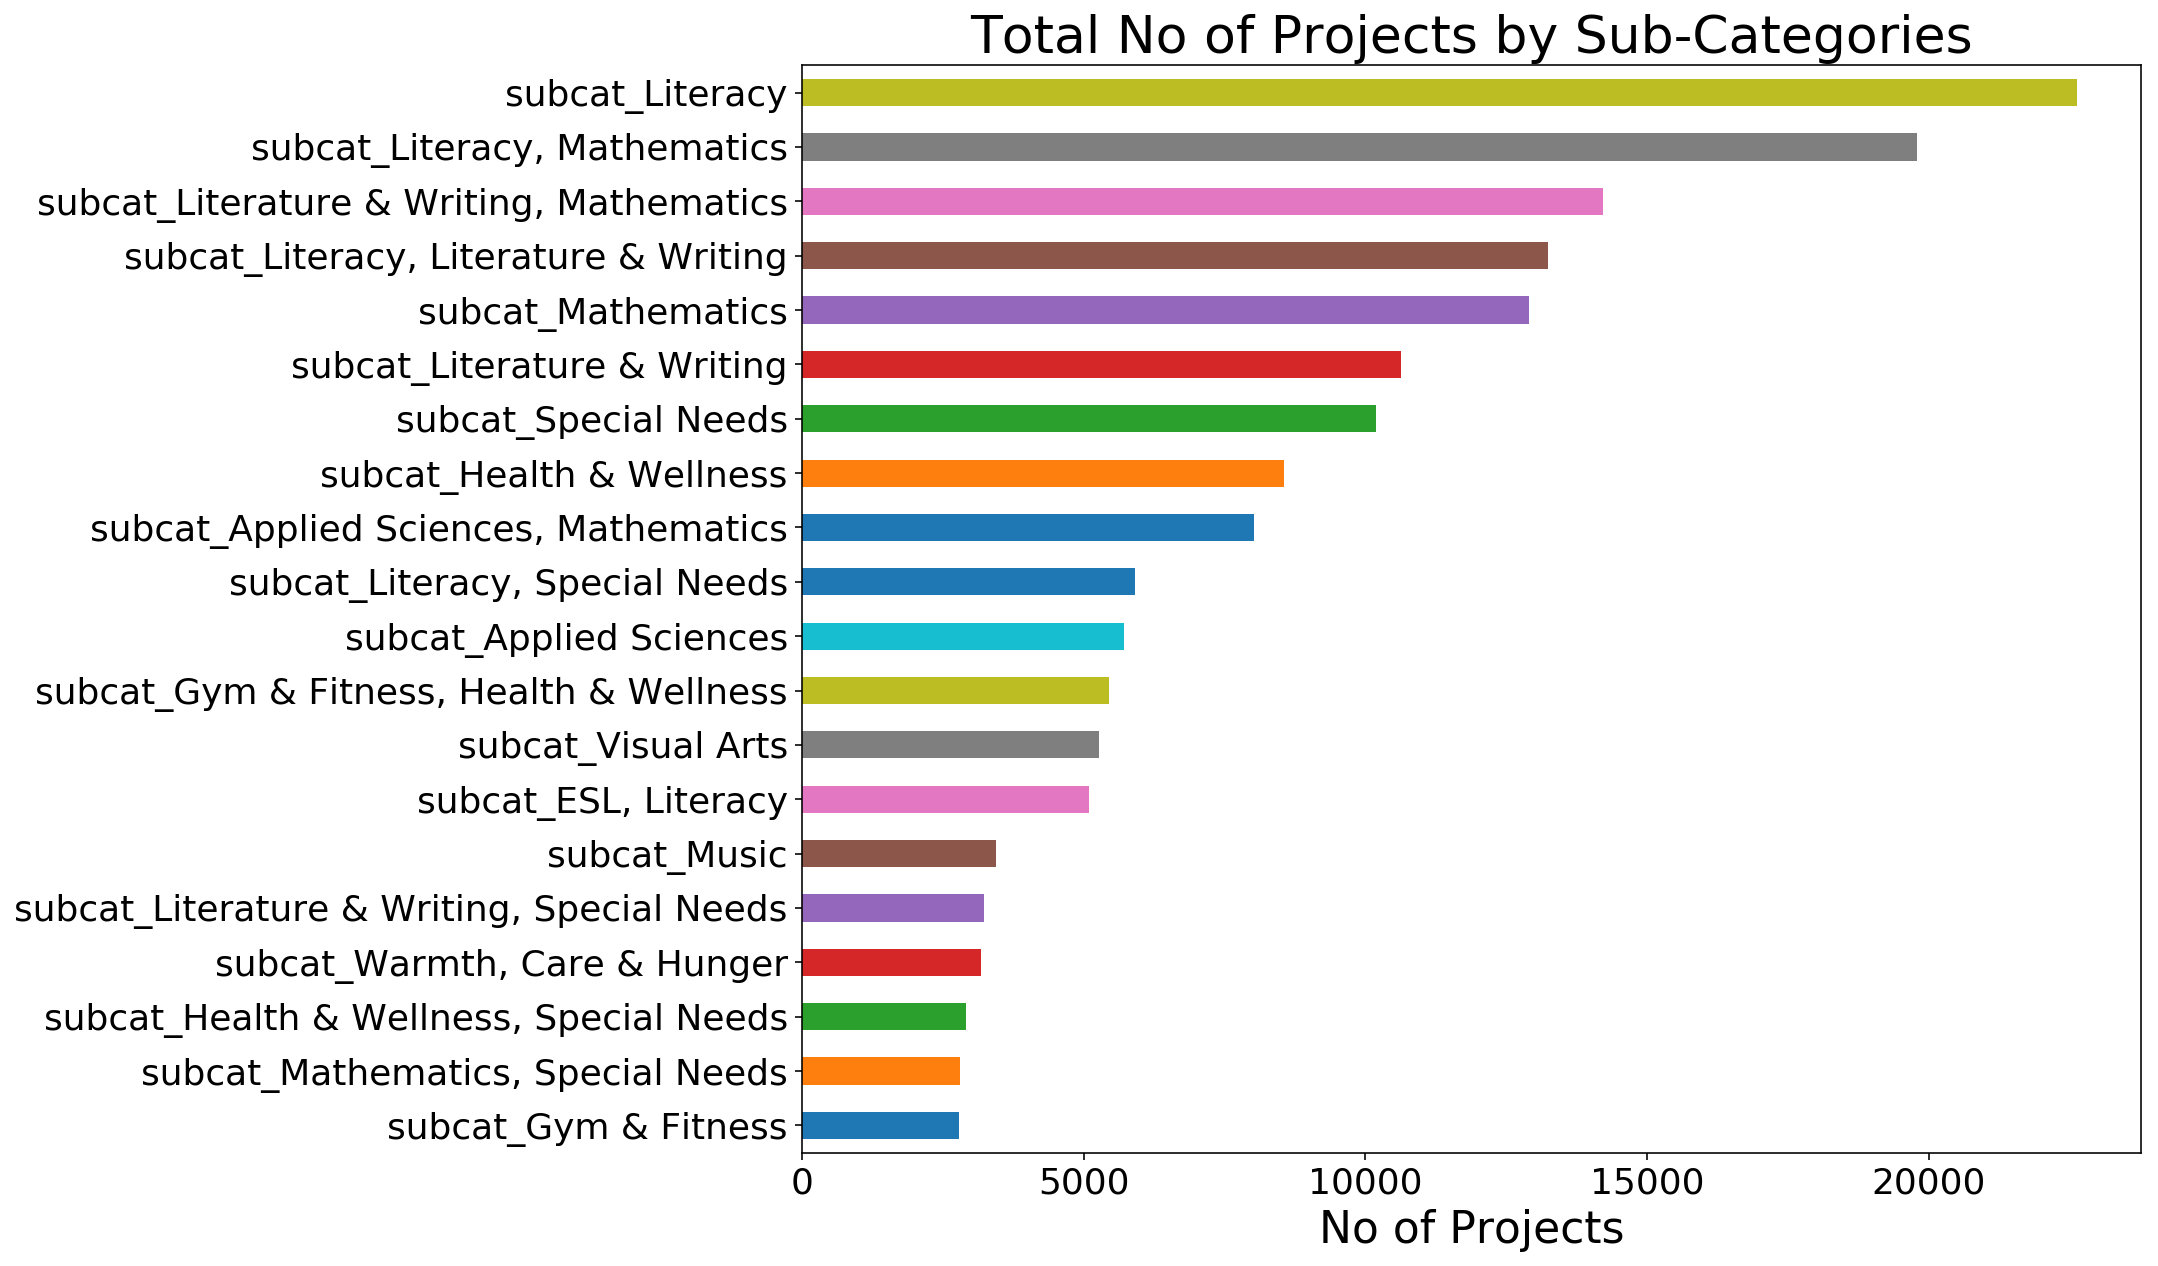

In [60]:
subcat_features.sum().sort_values(ascending=False).head(20) \
                     .sort_values(ascending=True) \
                     .plot(kind='barh', figsize=(12,10), fontsize=18)
plt.title('Total No of Projects by Sub-Categories', fontsize=26)
plt.xlabel('No of Projects', fontsize=22)
plt.show()

In [61]:
subcat_temp = whole_df[~whole_df.project_is_approved.isnull()]

col = subcat_features.columns + ',' + train_df.columns[-1]

In [62]:
# whole_df.project_subject_subcategories = whole_df.project_subject_subcategories \
#                                                     .apply(lambda x: x.split(', '))


In [63]:
# whole_df.project_subject_subcategories.head(10)

In [64]:
# mlb_subcat = MultiLabelBinarizer()

# subcat_features = pd.DataFrame(mlb_subcat.fit_transform(whole_df.project_subject_subcategories),\
#                                columns = mlb_subcat.classes_)
# subcat_features.head(2)

In [65]:
# mlb_subcat.classes_

In [66]:
# print("# of features : {}".format(len(mlb_subcat.classes_)))

In [67]:
# subcat_features.columns = ['subcat_' + x for x in subcat_features.columns]
# subcat_features.head(2)

### 5.4 Oberving if School state should be added as features

In [68]:
whole_df.school_state.value_counts().head(10)

CA    36418
TX    17648
NY    17308
FL    14788
NC    12087
IL    10509
GA     9558
SC     9082
MI     7641
PA     7386
Name: school_state, dtype: int64

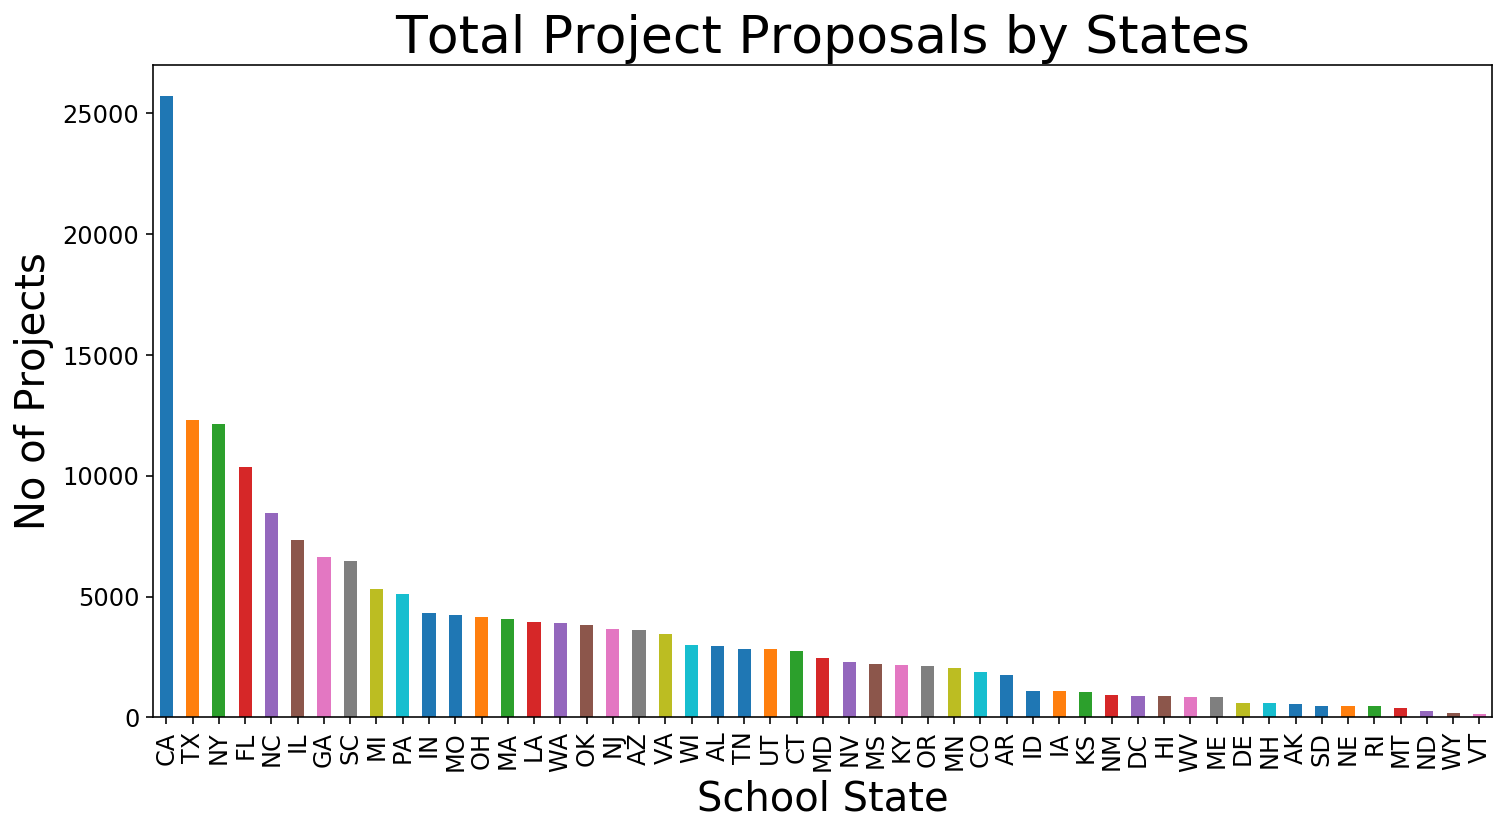

In [69]:
train_df.school_state.value_counts().plot(kind="bar", figsize=(12,6), fontsize=12)
plt.title('Total Project Proposals by States', fontsize=26)
plt.xlabel('School State', fontsize=20)
plt.ylabel('No of Projects', fontsize=20)
plt.show()

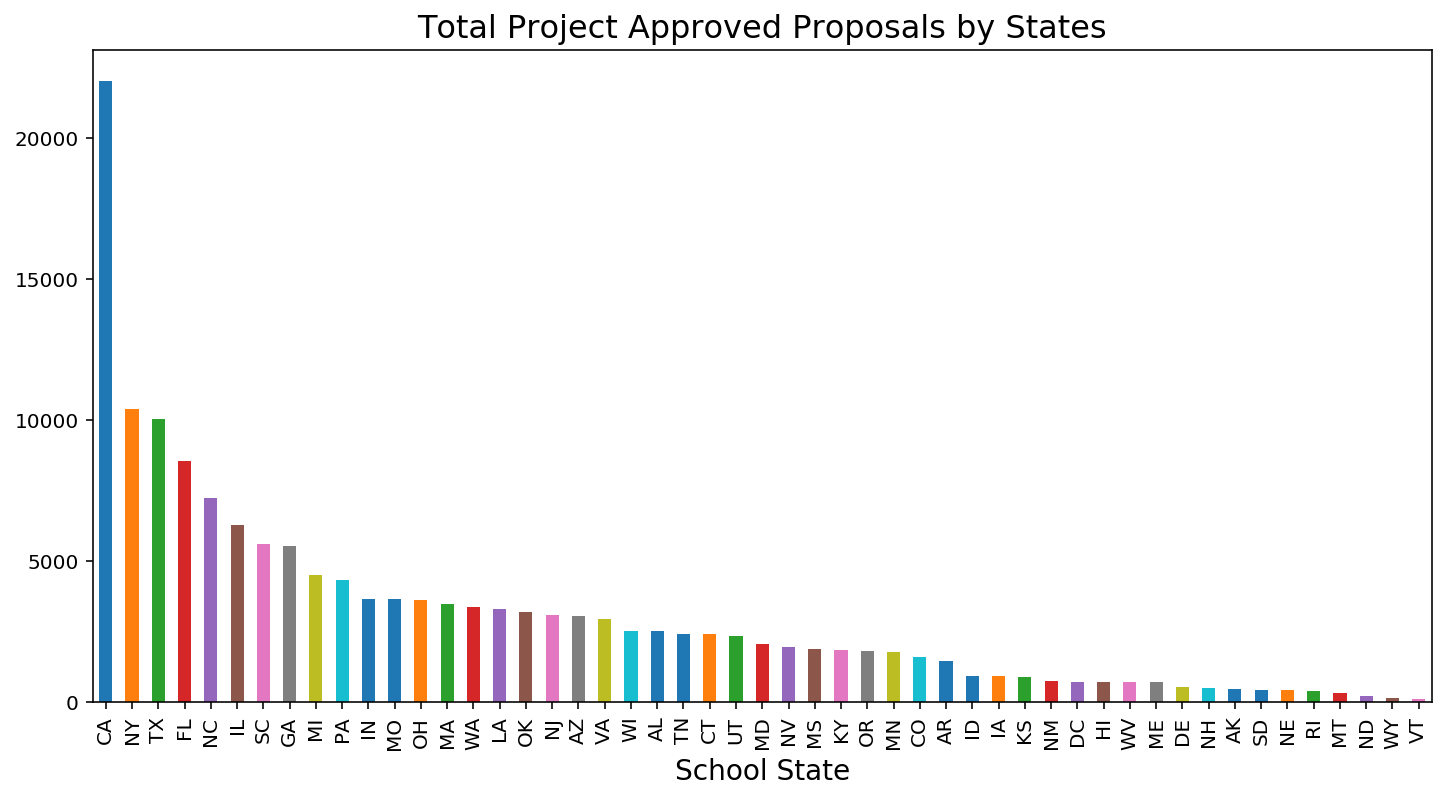

In [70]:
train_df.groupby(['school_state'])['project_is_approved'].sum() \
                                                         .sort_values(ascending=False) \
                                                         .plot(kind="bar", 
                                                                     figsize=(12,6), 
                                                                     fontsize=10)
plt.title('Total Project Approved Proposals by States', fontsize=16)
plt.xlabel('School State', fontsize=14)
plt.show()

In [71]:
((train_df.groupby(['school_state'])['project_is_approved'].sum() / \
 train_df.school_state.value_counts()) * 100).head(10)

AK    84.919210
AL    84.839255
AR    83.210017
AZ    84.172662
CA    85.643121
CO    84.578696
CT    87.129429
DC    81.263858
DE    89.134126
FL    82.450043
dtype: float64

In [72]:
((train_df.groupby(['school_state'])['project_is_approved'].sum() / \
 train_df.school_state.value_counts()) * 100).sort_values(ascending=False) \
.plot(kind='bar', figsize=(14,8), fontsize=12)
plt.title('Project Approving Percentage by States', fontsize=26)
plt.xlabel('School State', fontsize=20)
plt.ylabel('Percentage %', fontsize=20)
plt.show()

In [73]:
# According to above finding, School State doesn't have effects on project proposal 
# approving since the approval % for each states are nearly the same.

In [74]:
sch_state_features = pd.get_dummies(whole_df.school_state, prefix = 'sch_state')
sch_state_features.drop(['sch_state_VT'], axis=1, inplace = True)
# whole_df = pd.concat([whole_df,sch_state_dummy],axis=1)
# whole_df.head()

### 5.5 Observing the proposal date and time

In [75]:
train_temp.project_submitted_datetime = pd.to_datetime(train_temp.project_submitted_datetime)
train_temp.head(3)

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   

            project_subject_subcategories             project_title  \
0                                Literacy  Super Sight Word Centers   
1            Performing Arts, Team Sports    Keep Calm and Dance On   
2  Applied Sciences, Literature & Writing     Lets 3Doodle to Learn   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                            26                    1  
1                                             1                    0  
2                                             5                    1

In [76]:
train_temp['date'] = train_temp.project_submitted_datetime.dt.date
train_temp['year'] = train_temp.project_submitted_datetime.dt.year
train_temp['month'] = train_temp.project_submitted_datetime.dt.month
train_temp['day'] = train_temp.project_submitted_datetime.dt.day
train_temp['time'] = train_temp.project_submitted_datetime.dt.time

In [77]:
train_temp.head()

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   
3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.    male   
4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.    male   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   
3           NC        2016-08-12 15:42:11             Grades 3-5   
4           CA        2016-08-06 09:09:11             Grades 6-8   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   
3                      Health & Sports   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1            Performing Arts, Team Sports   
2  Applied Sciences, Literature & Writing   
3                       Health & Wellness   
4                       Health & Wellness   

                                       project_title    ...     \
0                           Super Sight Word Centers    ...      
1                             Keep Calm and Dance On    ...      
2                              Lets 3Doodle to Learn    ...      
3  \"Kid Inspired\" Equipment to Increase Activit...    ...      
4   We need clean water for our culinary arts class!    ...      

  project_essay_3 project_essay_4  \
0             NaN             NaN   
1             NaN             NaN   
2             NaN             NaN   
3             NaN             NaN   
4             NaN             NaN   

                            project_resource_summary  \
0  My students need 6 Ipod Nano's to create and d...   
1  My students need matching shirts to wear for d...   
2  My students need the 3doodler. We are an SEM s...   
3  My students need balls and other activity equi...   
4  My students need a water filtration system for...   

  teacher_number_of_previously_posted_projects project_is_approved  \
0                                           26                   1   
1                                            1                   0   
2                                            5                   1   
3                                           16                   0   
4                                           42                   1   

         date  year month  day      time  
0  2016-11-18  2016    11   18  14:45:59  
1  2017-04-26  2017     4   26  15:57:28  
2  2017-01-01  2017     1    1  22:57:44  
3  2016-08-12  2016     8   12  15:42:11  
4  2016-08-06  2016     8    6  09:09:11  

[5 rows x 22 columns]

In [78]:
plt.figure(figsize = (14,8))
ax = sns.lineplot(x=train_temp.date, y=train_temp.teacher_number_of_previously_posted_projects, 
                  err_style=None)
plt.show()

plt.figure(figsize = (14,8))
ax = sns.lineplot(x=train_temp.date, y=train_temp.project_is_approved, 
                 color='Green', err_style=None)
plt.show()

In [79]:
def checking_feature(feature):
    train_temp[feature].value_counts().sort_index(ascending=True).plot(kind="bar", figsize=(12,6), fontsize=18, rot=1)
    plt.title('Total Project Proposals by {}'.format(feature), fontsize=22)
    plt.xlabel('{}'.format(feature), fontsize=20)
    plt.show()

    train_temp.groupby([feature])['project_is_approved'].sum() \
                                                     .plot(kind="bar", figsize=(12,6), 
                                                        fontsize=18, rot = 1)
    plt.title('Total Approved Project Proposals by {}'.format(feature), fontsize=22)
    plt.xticks()
    plt.xlabel('{}'.format(feature), fontsize=20)
    plt.show()

    ((train_temp.groupby([feature])['project_is_approved'].sum() / \
     train_temp[feature].value_counts()) * 100) \
    .plot(kind='bar', figsize=(12,6), fontsize=18, rot = 1)
    plt.title('Project Approving Percentage by {}'.format(feature), fontsize=22)
    plt.xlabel('{}'.format(feature), fontsize=20)
    plt.show()

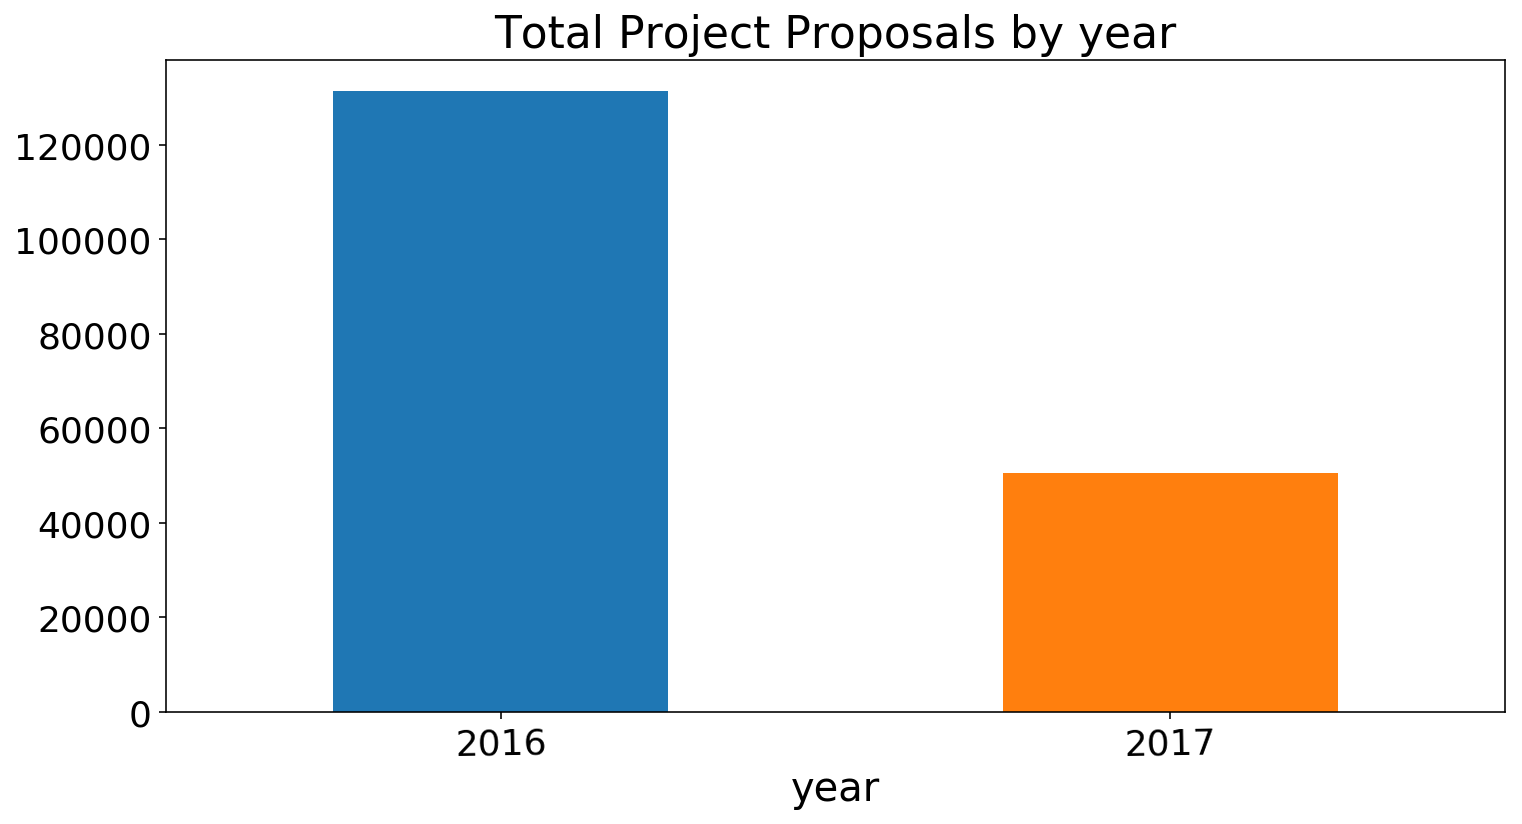

In [80]:
checking_feature('year')

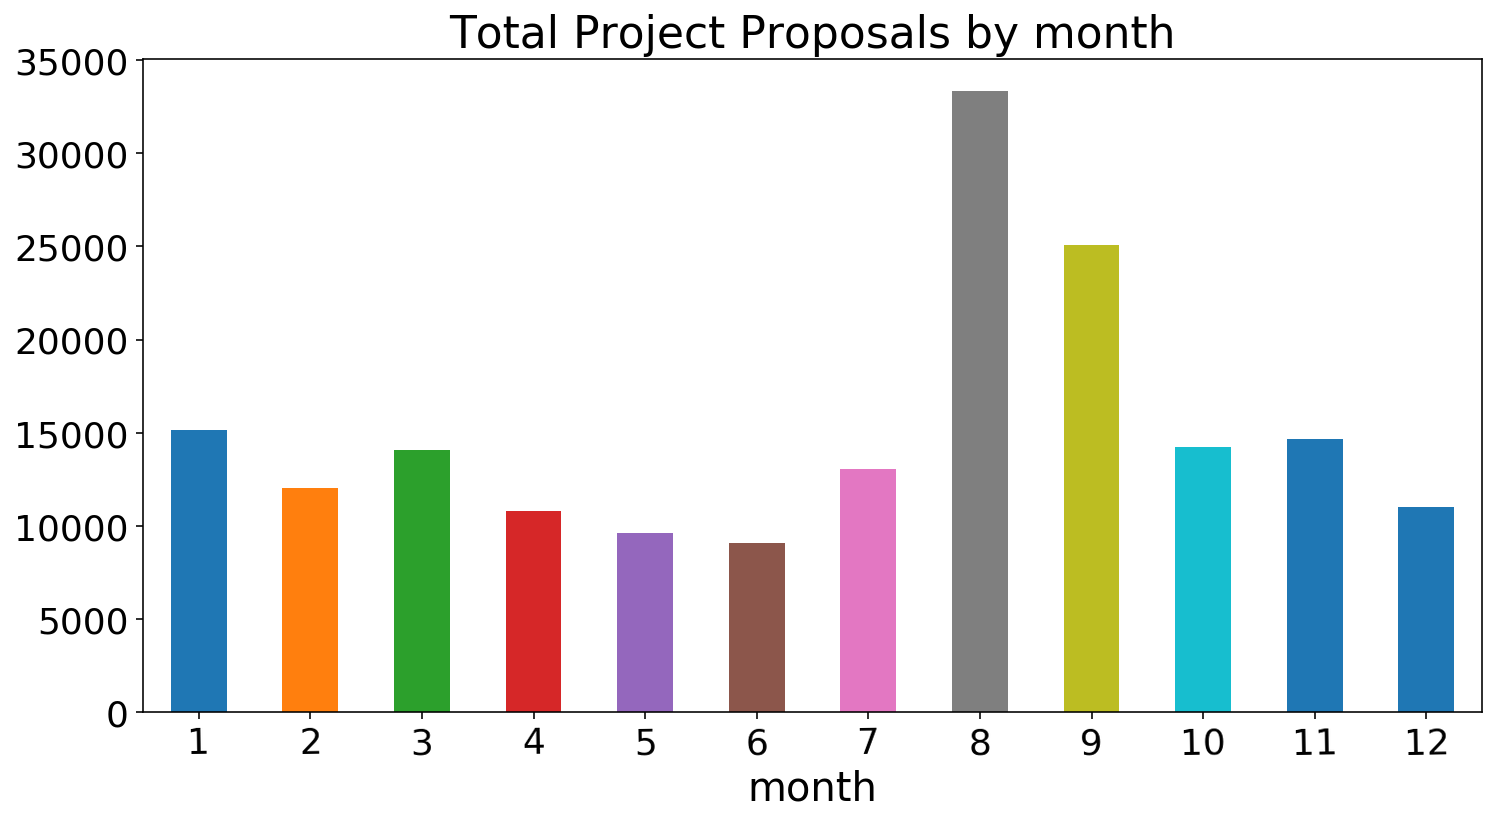

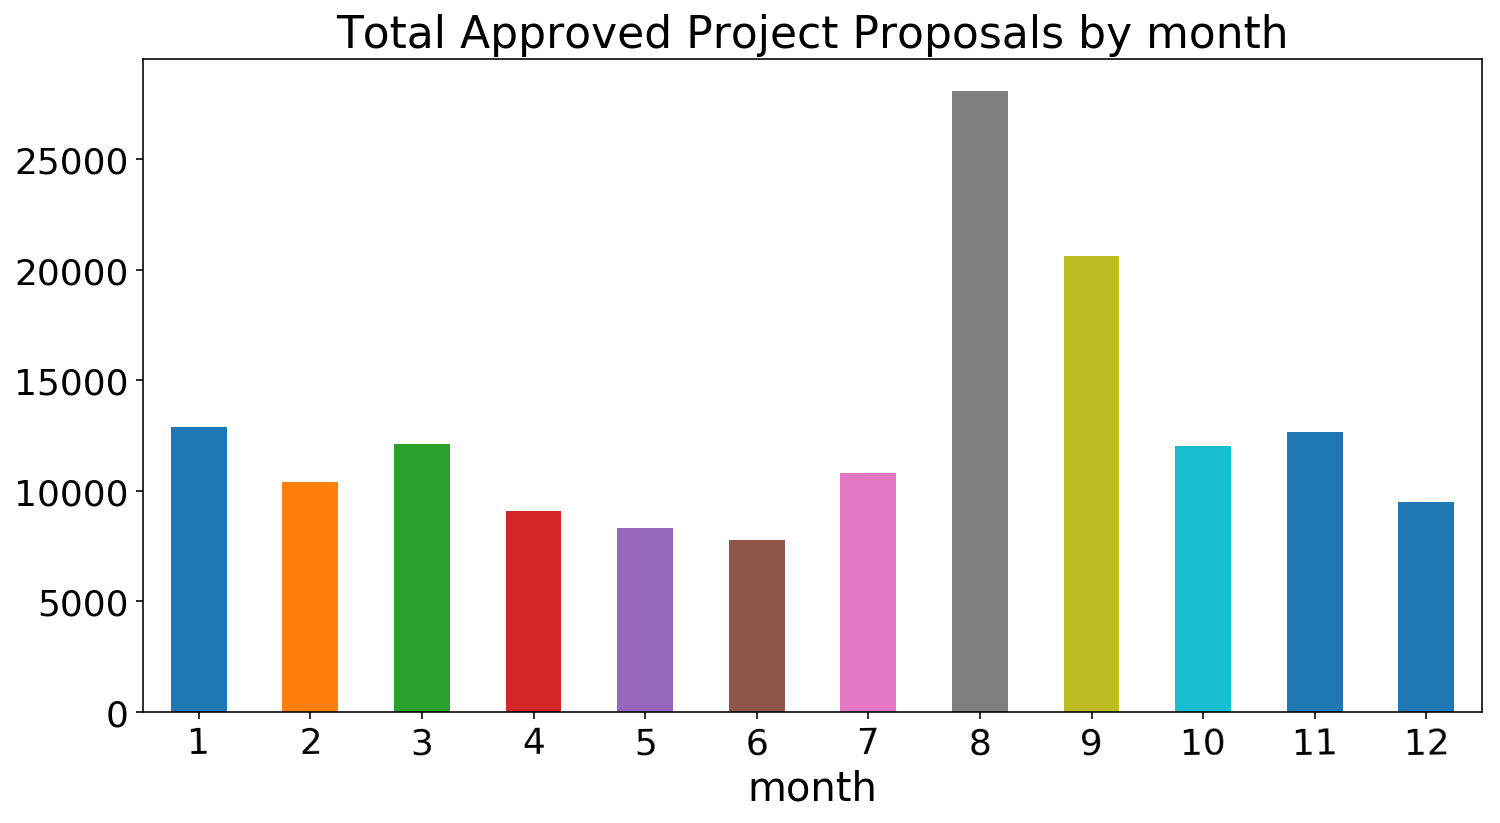

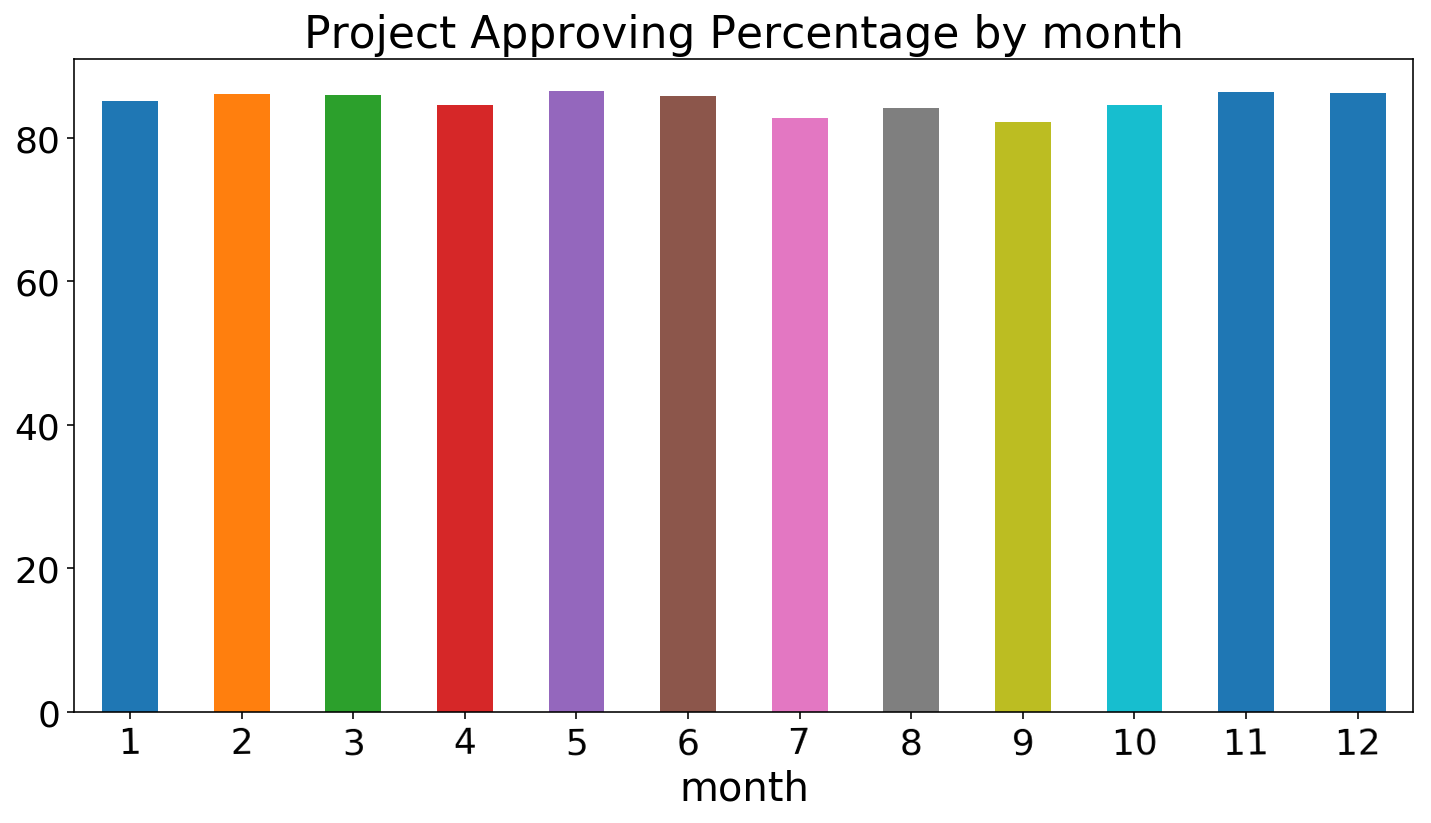

In [81]:
checking_feature('month')

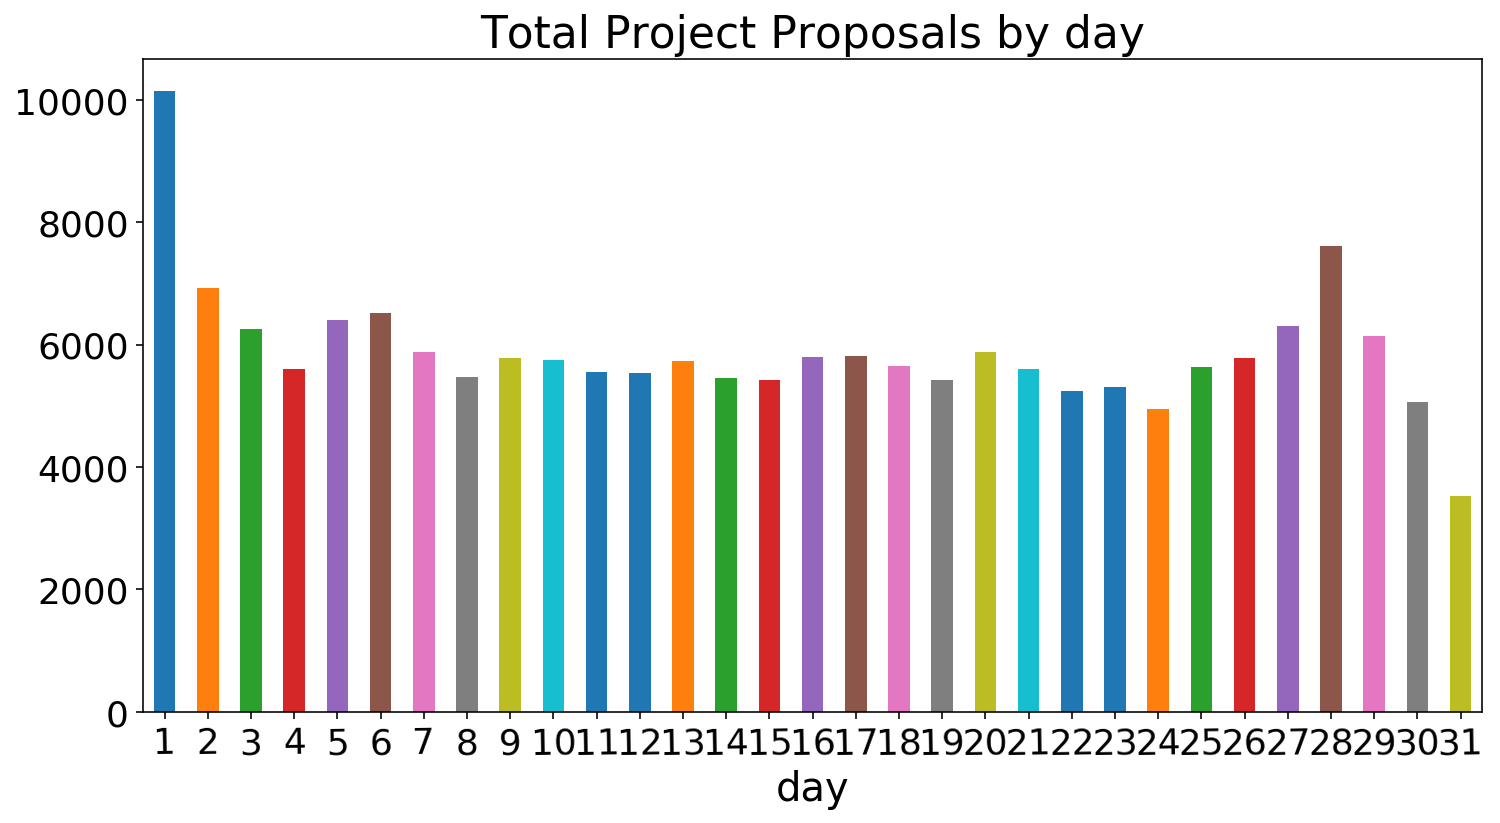

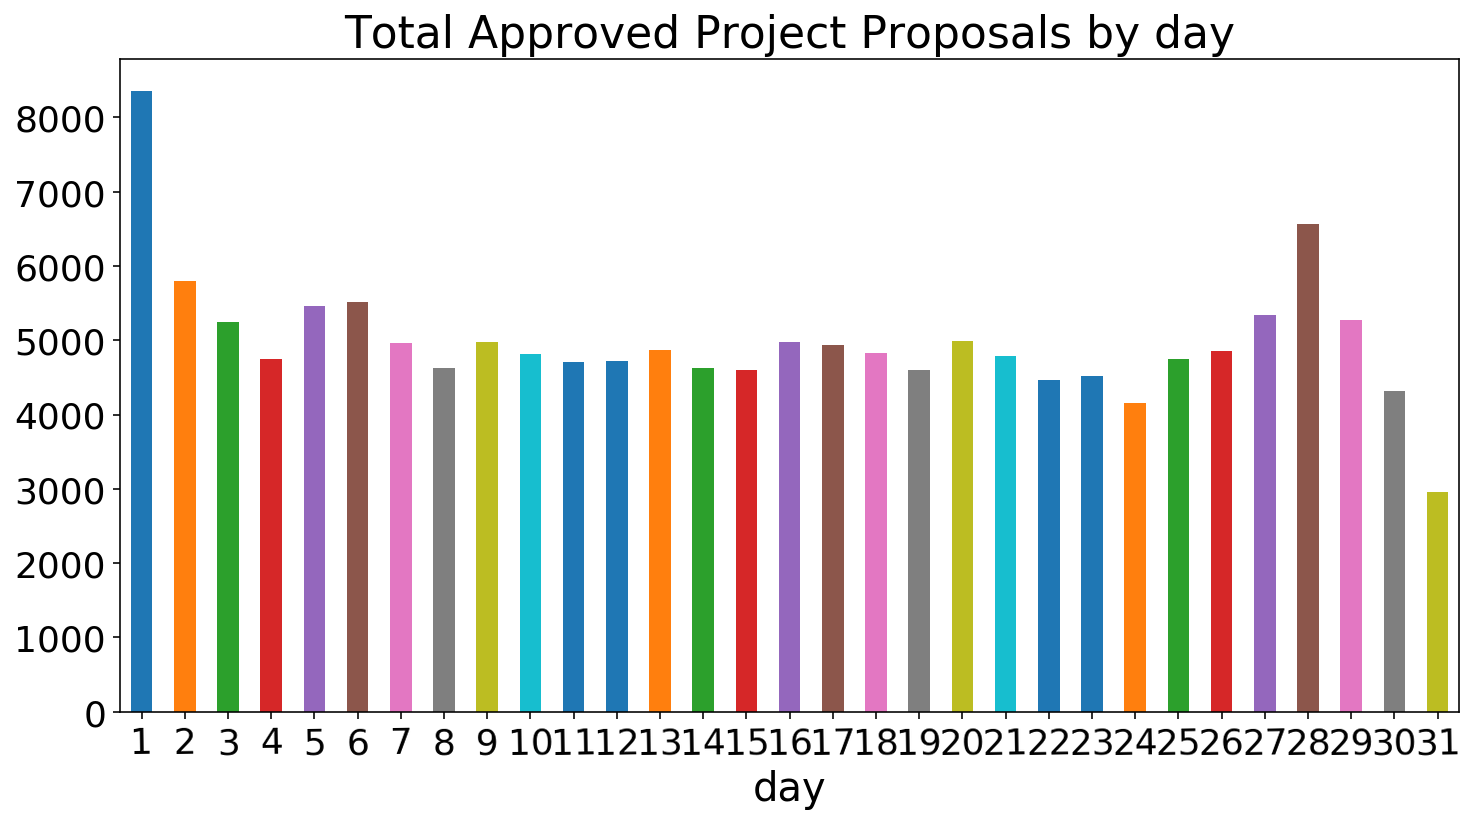

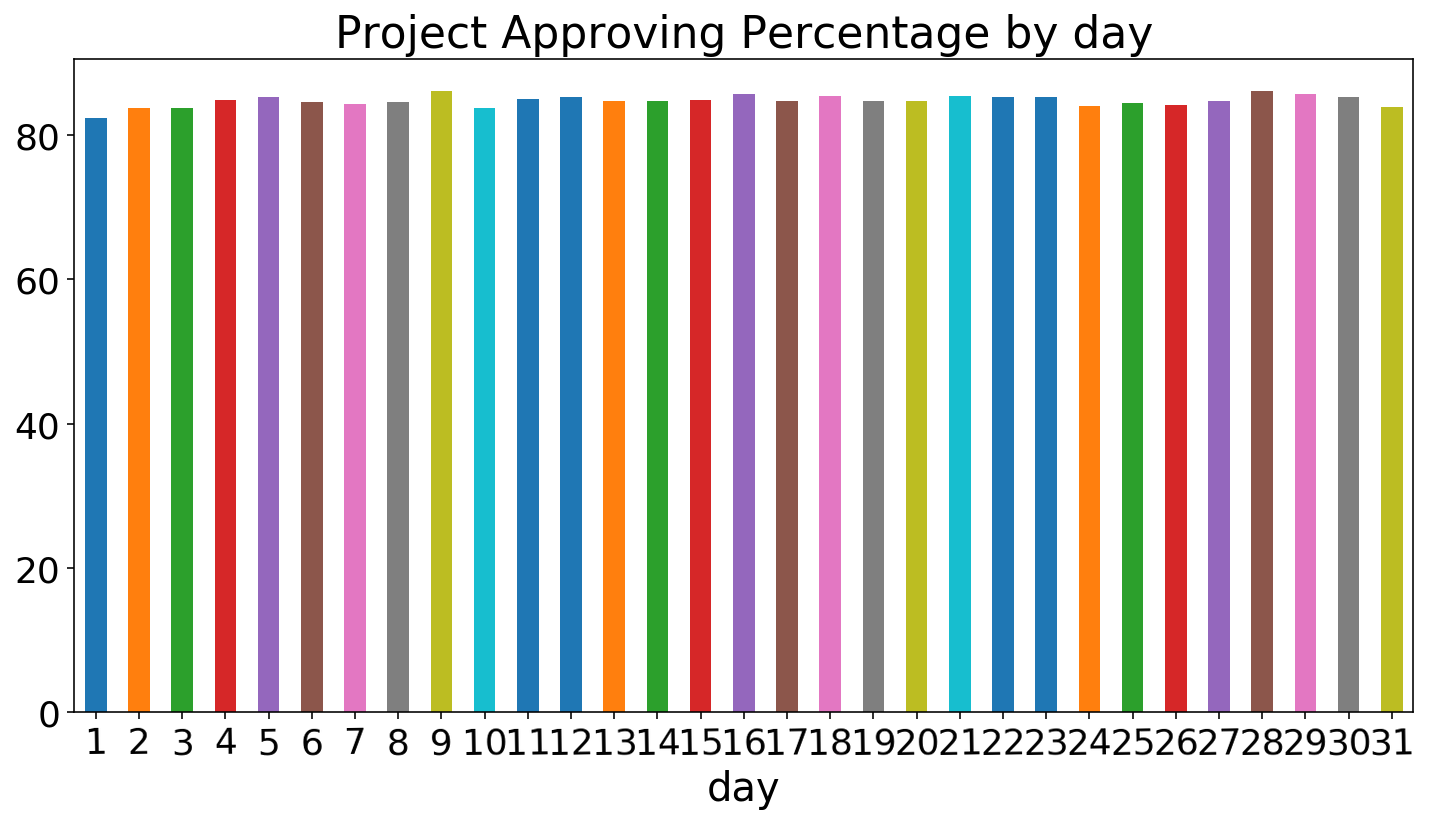

In [82]:
checking_feature('day')

### 5.6 Adding Project Essay as features

In [83]:
train_temp.project_essay_1.isnull().value_counts()

False    182080
Name: project_essay_1, dtype: int64

In [84]:
train_temp.project_essay_2.isnull().value_counts()

False    182080
Name: project_essay_2, dtype: int64

In [85]:
# No null value in Project essay 1 and Project essay 2 since it's compulsary to write.

In [86]:
train_temp.project_essay_3.isnull().value_counts()

True     175706
False      6374
Name: project_essay_3, dtype: int64

In [87]:
train_temp.project_essay_4.isnull().value_counts()

True     175706
False      6374
Name: project_essay_4, dtype: int64

In [88]:
sum(train_temp[train_temp.project_essay_3.isnull() == True].index == train_temp[train_temp.project_essay_4.isnull() == True].index)

175706

In [89]:
# Since all the indexes of project_essay_3 and project_essay_4 are same, they are not
# required or necessary to fill up together at some point.
# Besides, I can focus on working either project_essay_3 or 4 to investigate now.

In [90]:
train_temp[train_temp.project_essay_3.isnull()].date.min()

datetime.date(2016, 5, 17)

In [91]:
start_date = datetime.date(2016, 5, 17)
train_temp[train_temp.date > start_date].head(5)

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   
3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.    male   
4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.    male   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   
3           NC        2016-08-12 15:42:11             Grades 3-5   
4           CA        2016-08-06 09:09:11             Grades 6-8   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   
3                      Health & Sports   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1            Performing Arts, Team Sports   
2  Applied Sciences, Literature & Writing   
3                       Health & Wellness   
4                       Health & Wellness   

                                       project_title    ...     \
0                           Super Sight Word Centers    ...      
1                             Keep Calm and Dance On    ...      
2                              Lets 3Doodle to Learn    ...      
3  \"Kid Inspired\" Equipment to Increase Activit...    ...      
4   We need clean water for our culinary arts class!    ...      

  project_essay_3 project_essay_4  \
0             NaN             NaN   
1             NaN             NaN   
2             NaN             NaN   
3             NaN             NaN   
4             NaN             NaN   

                            project_resource_summary  \
0  My students need 6 Ipod Nano's to create and d...   
1  My students need matching shirts to wear for d...   
2  My students need the 3doodler. We are an SEM s...   
3  My students need balls and other activity equi...   
4  My students need a water filtration system for...   

  teacher_number_of_previously_posted_projects project_is_approved  \
0                                           26                   1   
1                                            1                   0   
2                                            5                   1   
3                                           16                   0   
4                                           42                   1   

         date  year month  day      time  
0  2016-11-18  2016    11   18  14:45:59  
1  2017-04-26  2017     4   26  15:57:28  
2  2017-01-01  2017     1    1  22:57:44  
3  2016-08-12  2016     8   12  15:42:11  
4  2016-08-06  2016     8    6  09:09:11  

[5 rows x 22 columns]

In [92]:
# Look like after 17.05.2016, the project proposal format is changed.

In [93]:
whole_df['date'] = whole_df.project_submitted_datetime.dt.date
whole_df.head(3)

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   

            project_subject_subcategories             project_title  \
0                                Literacy  Super Sight Word Centers   
1            Performing Arts, Team Sports    Keep Calm and Dance On   
2  Applied Sciences, Literature & Writing     Lets 3Doodle to Learn   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   

   teacher_number_of_previously_posted_projects  project_is_approved  budget  \
0                                            26                  1.0  899.94   
1                                             1                  0.0  400.00   
2                                             5                  1.0  469.99   

         date  
0  2016-11-18  
1  2017-04-26  
2  2017-01-01

In [94]:
start_date = datetime.date(2016, 5, 17)

In [95]:
def combine_essay_1_2(col):
    if col[0] < start_date:
        return (col[1] + col[2])
    else:
        return col[1]

In [96]:
def combine_essay_3_4(col):
    if col[0] < start_date:
        return (col[1] + col[2])
    else:
        return col[3]

In [97]:
whole_df['project_essay_1_2'] = whole_df[['date',
                                          'project_essay_1',
                                          'project_essay_2']].apply(combine_essay_1_2,axis=1)
whole_df['project_essay_3_4'] = whole_df[['date',
                                          'project_essay_3',
                                          'project_essay_4',
                                          'project_essay_2']].apply(combine_essay_3_4,axis=1)


In [98]:
whole_df.head()


id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   
3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.    male   
4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.    male   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   
3           NC        2016-08-12 15:42:11             Grades 3-5   
4           CA        2016-08-06 09:09:11             Grades 6-8   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   
3                      Health & Sports   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1            Performing Arts, Team Sports   
2  Applied Sciences, Literature & Writing   
3                       Health & Wellness   
4                       Health & Wellness   

                                       project_title  \
0                           Super Sight Word Centers   
1                             Keep Calm and Dance On   
2                              Lets 3Doodle to Learn   
3  \"Kid Inspired\" Equipment to Increase Activit...   
4   We need clean water for our culinary arts class!   

                         ...                          \
0                        ...                           
1                        ...                           
2                        ...                           
3                        ...                           
4                        ...                           

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   
3  The student's project which is totally \"kid-i...             NaN   
4  For some reason in our kitchen the water comes...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   
3             NaN  My students need balls and other activity equi...   
4             NaN  My students need a water filtration system for...   

  teacher_number_of_previously_posted_projects  project_is_approved  budget  \
0                                           26                  1.0  899.94   
1                                            1                  0.0  400.00   
2                                            5                  1.0  469.99   
3                                           16                  0.0  684.47   
4                                           42                  1.0  711.00   

         date                                  project_essay_1_2  \
0  2016-11-18  Most of my kindergarten students come from low...   
1  2017-04-26  Our elementary school is a culturally rich sch...   
2  2017-01-01  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   
3  2016-08-12  My students are the greatest students but are ...   
4  2016-08-06  My students are athletes and students who are ...   

                                   project_essay_3_4  
0  I currently have a differentiated sight word c...  
1  We strive to provide our diverse population of...  
2  We are looking to add some 3Doodler to our cla...  
3  T

In [99]:
print(whole_df.project_essay_1_2.isnull().value_counts())
print(whole_df.project_essay_3_4.isnull().value_counts())

False    260115
Name: project_essay_1_2, dtype: int64
False    260115
Name: project_essay_3_4, dtype: int64


In [100]:
whole_df.project_essay_1_2[0]


'Most of my kindergarten students come from low-income households and are considered \\"at-risk\\". These kids walk to school alongside their parents and most have never been further than walking distance from their house. For 80% of my students, English is not their first language or the language spoken at home. \\r\\n\\r\\nWhile my kindergarten kids have many obstacles in front of them, they come to school each day excited and ready to learn. Most students started the year out never being in a school setting. At the start of the year many had never been exposed to letters. Each day they soak up more knowledge and try their hardest to succeed. They are highly motivated to learn new things every day. We are halfway through the year and they are starting to take off. They know know all letters, some sight words, numbers to 20, and a majority of their letter sounds because of their hard work and determination. I am excited to see the places we will go from here!'

In [101]:
whole_df.project_essay_1_2[182197]


'\\"Nobody is bored when he is trying to make something beautiful, or to discover something that is true.\\"  \\r\\nWilliam Ralph Inge \\r\\n\\r\\nWriting is the foundation of a Language Arts/Social Justice Magnet School.  We need to publish our written work to share our ideas with the world.  Bright tomorrows beckon!My students are young agents of change with much to say about changing our world for the better.  They have a strong desire to reach out with the printed word to explore their social ideals, creativity, and opinions about many issues facing the world today.  They have a strong connection to the written word and the desire to share their thoughts with the larger community.  Their ability to print and publish their work is presently limited by a lack of resources.'

In [102]:
str_to_remove = string.punctuation
print(str_to_remove)
str_to_remove = str_to_remove.replace("%","").replace("-","")
#str_to_remove += '•' + '✔' + '\n' + '\r' + '\xa0'
print(str_to_remove)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$&'()*+,./:;<=>?@[\]^_`{|}~


In [103]:
def cleaning_text(string):
    
    string = string.replace('\\r','').replace('\\n','').replace('\r','') \
                   .replace('\n','')
#     string = string.replace('\\r\\n\\r\\n','').replace('\\r\\n','') \
#                    .replace('\r\n\r\n','') \
#                    .replace('\r\n','').replace('\r','').replace('\n','')
    clean_string = "".join([char for char in string if char not in str_to_remove])
                        
    return clean_string

In [104]:
whole_df.project_essay_1_2 = whole_df.project_essay_1_2.apply(cleaning_text)
whole_df.project_essay_3_4 = whole_df.project_essay_3_4.apply(cleaning_text)
#whole_df.project_title = whole_df.project_title.apply(cleaning_text)
#whole_df.project_resource_summary = whole_df.project_resource_summary.apply(cleaning_text)


In [105]:
whole_df.project_essay_1_2[0]


'Most of my kindergarten students come from low-income households and are considered at-risk These kids walk to school alongside their parents and most have never been further than walking distance from their house For 80% of my students English is not their first language or the language spoken at home While my kindergarten kids have many obstacles in front of them they come to school each day excited and ready to learn Most students started the year out never being in a school setting At the start of the year many had never been exposed to letters Each day they soak up more knowledge and try their hardest to succeed They are highly motivated to learn new things every day We are halfway through the year and they are starting to take off They know know all letters some sight words numbers to 20 and a majority of their letter sounds because of their hard work and determination I am excited to see the places we will go from here'

In [106]:
whole_df.project_essay_1_2[182197]


'Nobody is bored when he is trying to make something beautiful or to discover something that is true  William Ralph Inge Writing is the foundation of a Language ArtsSocial Justice Magnet School  We need to publish our written work to share our ideas with the world  Bright tomorrows beckonMy students are young agents of change with much to say about changing our world for the better  They have a strong desire to reach out with the printed word to explore their social ideals creativity and opinions about many issues facing the world today  They have a strong connection to the written word and the desire to share their thoughts with the larger community  Their ability to print and publish their work is presently limited by a lack of resources'

## Below are Mark down for Future Progress
_______________________________________________________________________

In [107]:
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        if word.pos_ == 'NOUN':
            sent.append(word.lemma_)
    return " ".join(sent)

In [108]:
# whole_df.project_essay_1_2 = whole_df.project_essay_1_2.apply(lemmatizer)

In [109]:
# whole_df.project_essay_1_2[182197]

_______________________________________________________________________

In [110]:
stopping_words = stopwords.words('english')
print("Checking what words are contained in stopwords :\n",stopping_words)


Checking what words are contained in stopwords :
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'n

In [111]:
stopping_words.extend(['student','need','students','require','needs','requires'])

In [112]:
def text_feature_extraction(column,ngram=(1,1),minimun_df=1,maximum_features=None):
    cvec = CountVectorizer(stop_words='english',ngram_range=ngram,
                           min_df=minimun_df,max_features=maximum_features,
                           strip_accents='ascii')

    cvec.fit(whole_df[column])
    
    print("# of features : {}".format(len(cvec.get_feature_names())))

    column_df = pd.DataFrame(cvec.transform(whole_df[column]).todense(),
                                  columns=cvec.get_feature_names())
    
    return column_df

## Below are Mark down for Future Progress
_______________________________________________________________________

pe_1_2_features = text_feature_extraction("project_essay_1_2",(2,4),0.01)
pe_1_2_features.columns = [ 'pe_1_2_'+ x for x in pe_1_2_features.columns]

pe_1_2_features.head()


pe_1_2_features.sum().head(20)


pe_3_4_features = text_feature_extraction("project_essay_3_4",(2,4),0.01)
pe_3_4_features.columns = [ 'pe_3_4_'+ x for x in pe_3_4_features.columns]

pe_3_4_features.head()


pe_3_4_features.sum().head(20)


_______________________________________________________________________

In [113]:
whole_df.project_resource_summary[0]

"My students need 6 Ipod Nano's to create and differentiated and engaging way to practice sight words during a literacy station."

In [114]:
whole_df.project_resource_summary = whole_df.project_resource_summary.apply(cleaning_text)
#whole_df.project_resource_summary = whole_df.project_resource_summary.apply(lemmatizer)

In [204]:
nlp_test = list(nlp.pipe(whole_df.project_resource_summary))

In [214]:
for word in nlp_test[0]:
    print(word, word.lemma_, word.pos_)

print(nlp_test[2])
print(' '.join([word.lemma_ for word in nlp_test[2] if word.is_oov]))

My -PRON- ADJ
students student NOUN
need need VERB
6 6 NUM
Ipod ipod PROPN
Nanos nanos PROPN
to to PART
create create VERB
and and CCONJ
differentiated differentiate VERB
and and CCONJ
engaging engaging ADJ
way way NOUN
to to PART
practice practice VERB
sight sight NOUN
words word NOUN
during during ADP
a a DET
literacy literacy NOUN
station station NOUN
My students need the 3doodler We are an SEM school which means students learn using a profile that tells them what way they learn best Having this 3doodler will help my students learn
-PRON- student need the 3doodler -PRON- be an sem school which mean student learn use a profile that tell -PRON- what way -PRON- learn good have this 3doodler will help -PRON- student learn


In [115]:
whole_df.project_resource_summary[0]

'My students need 6 Ipod Nanos to create and differentiated and engaging way to practice sight words during a literacy station'

In [116]:
# Since i didn't do lemmatizer yet, there are some repeated words like book and books. So best is not to use too low min_df
#re_sum_temp = text_feature_extraction("project_resource_summary", (3,4), 0.005)

In [117]:
#re_sum_temp.sum()

In [118]:
project_resource_summary_features = text_feature_extraction("project_resource_summary",
                                                            (2,3),0.01)
project_resource_summary_features.columns = [ 'proj_resource_sum_'+ x for x in project_resource_summary_features.columns]

# of features : 45


In [119]:
project_resource_summary_features.head()


proj_resource_sum_21st century  proj_resource_sum_alternative seating  \
0                               0                                      0   
1                               0                                      0   
2                               0                                      0   
3                               0                                      0   
4                               0                                      0   

   proj_resource_sum_class set  proj_resource_sum_classroom library  \
0                            0                                    0   
1                            0                                    0   
2                            0                                    0   
3                            0                                    0   
4                            0                                    0   

   proj_resource_sum_enhance learning  proj_resource_sum_flexible seating  \
0                                   0                                   0   
1                                   0                                   0   
2                                   0                                   0   
3                                   0                                   0   
4                                   0                                   0   

   proj_resource_sum_flexible seating options  proj_resource_sum_hokki stools  \
0                                           0                               0   
1                                           0                               0   
2                                           0                               0   
3                                           0                               0   
4                                           0                               0   

   proj_resource_sum_learning environment  proj_resource_sum_need access  \
0                                       0                              0   
1                                       0                              0   
2                                       0                              0   
3                                       0                              0   
4                                       0                              0   

                ...                 proj_resource_sum_students need hands  \
0               ...                                                     0   
1               ...                                                     0   
2               ...                                                     0   
3               ...                                                     0   
4               ...                                                     0   

   proj_resource_sum_students need headphones  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   proj_resource_sum_students need ipad  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   proj_resource_sum_students need ipads  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   proj_resource_sum_students need materials  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   proj_resource_sum_students need new  \
0                                    0   
1                                    0   
2              

In [120]:
project_resource_summary_features.sum().sort_values(ascending=False)

proj_resource_sum_students need                262360
proj_resource_sum_flexible seating               8567
proj_resource_sum_need chromebooks               8064
proj_resource_sum_students need chromebooks      8004
proj_resource_sum_need ipad                      6436
proj_resource_sum_need books                     6385
proj_resource_sum_students need ipad             6363
proj_resource_sum_students need books            6104
proj_resource_sum_need new                       5915
proj_resource_sum_seating options                5817
proj_resource_sum_students need new              5682
proj_resource_sum_wobble chairs                  4751
proj_resource_sum_need flexible                  4589
proj_resource_sum_need ipads                     4550
proj_resource_sum_students need flexible         4520
proj_resource_sum_students need ipads            4496
proj_resource_sum_need flexible seating          4313
proj_resource_sum_need variety                   4101
proj_resource_sum_students n

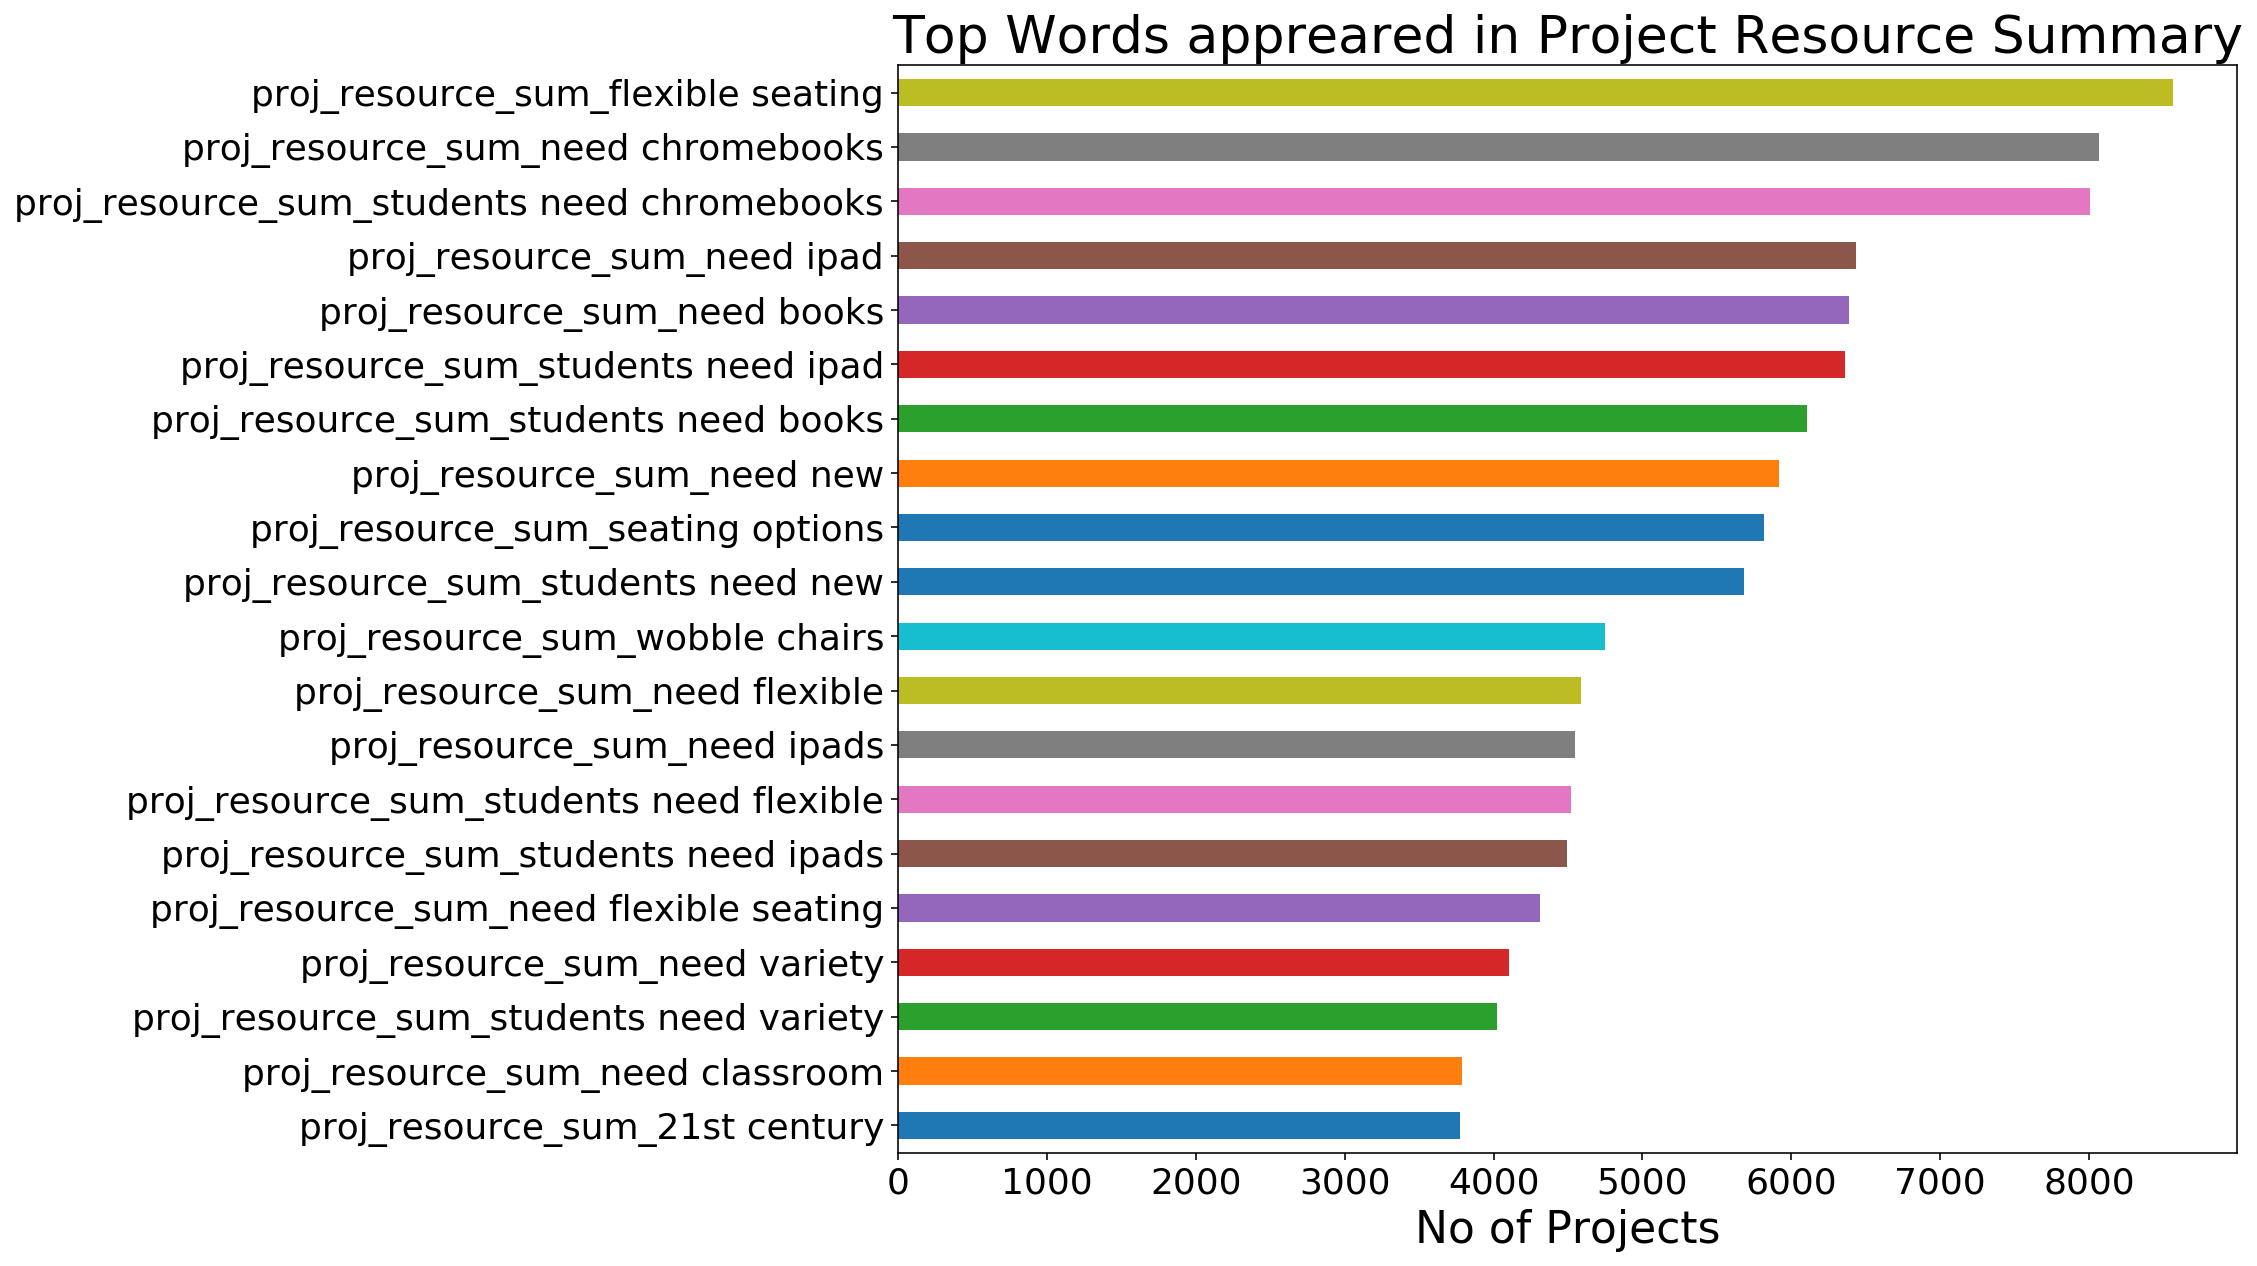

In [189]:
project_resource_summary_features.sum().drop(['proj_resource_sum_students need'],inplace=False).sort_values(ascending=False) \
                                       .head(20).sort_values(ascending=True) \
                                       .plot(kind='barh', figsize=(12,10), fontsize=18)
plt.title('Top Words appreared in Project Resource Summary', fontsize=26)
plt.xlabel('No of Projects', fontsize=22)
plt.show()

In [122]:
#Take a look at the most commonly occuring words in the Project resource summary

#Separate the text for approval and not approval
texthigh = ''.join(words for words in whole_df[whole_df['project_is_approved']==1.0]['project_resource_summary'])
textlow = ''.join(words for words in whole_df[whole_df['project_is_approved']==0.0]['project_resource_summary'])

#Generate the words clouds for higher and lower paying jobs
wordcloudhigh=WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(texthigh)
wordcloudlow= WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(textlow)

#Plot the wordclouds
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(wordcloudhigh,interpolation='bilinear')
plt.title('Most commonly occuring words in Approved Proposal',fontsize=15)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(wordcloudlow,interpolation='bilinear')
plt.title('Most commonly occuring words in Not-Approved Proposal',fontsize=15)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

In [123]:
whole_df.project_title.head()

0                             Super Sight Word Centers
1                               Keep Calm and Dance On
2                                Lets 3Doodle to Learn
3    \"Kid Inspired\" Equipment to Increase Activit...
4     We need clean water for our culinary arts class!
Name: project_title, dtype: object

In [124]:
whole_df.project_title = whole_df.project_title.apply(cleaning_text)
#whole_df.project_title = whole_df.project_title.apply(lemmatizer)

In [125]:
whole_df.project_title.head()

0                             Super Sight Word Centers
1                               Keep Calm and Dance On
2                                Lets 3Doodle to Learn
3    Kid Inspired Equipment to Increase Activities ...
4      We need clean water for our culinary arts class
Name: project_title, dtype: object

In [126]:
project_title_features = text_feature_extraction("project_title",(2,3),100)
project_title_features.columns = [ 'proj_title_'+ x for x in project_title_features.columns]

# of features : 465


In [127]:
project_title_features.shape

(260115, 465)

In [128]:
project_title_features.head()

proj_title_1st grade  proj_title_1st graders  proj_title_21st century  \
0                     0                       0                        0   
1                     0                       0                        0   
2                     0                       0                        0   
3                     0                       0                        0   
4                     0                       0                        0   

   proj_title_21st century classroom  proj_title_21st century learners  \
0                                  0                                 0   
1                                  0                                 0   
2                                  0                                 0   
3                                  0                                 0   
4                                  0                                 0   

   proj_title_21st century learning  proj_title_21st century skills  \
0                                 0                               0   
1                                 0                               0   
2                                 0                               0   
3                                 0                               0   
4                                 0                               0   

   proj_title_21st century technology  proj_title_2nd grade  \
0                                   0                     0   
1                                   0                     0   
2                                   0                     0   
3                                   0                     0   
4                                   0                     0   

   proj_title_2nd graders            ...             proj_title_wobble learn  \
0                       0            ...                                   0   
1                       0            ...                                   0   
2                       0            ...                                   0   
3                       0            ...                                   0   
4                       0            ...                                   0   

   proj_title_wobble stools  proj_title_wobble wobble  proj_title_wobble work  \
0                         0                         0                       0   
1                         0                         0                       0   
2                         0                         0                       0   
3                         0                         0                       0   
4                         0                         0                       0   

   proj_title_world technology  proj_title_year new  proj_title_year right  \
0                            0                    0                      0   
1                            0                    0                      0   
2                            0                    0                      0   
3                            0                    0                      0   
4                            0                    0                      0   

   proj_title_young learners  proj_title_young minds  proj_title_young readers  
0                          0                       0                         0  
1                          0                       0                         0  
2                          0                       0                         0  
3                          0                       0                         0  
4                          0                       0                         0  

[5 rows x 465 columns]

In [129]:
project_title_features.sum().sort_values(ascending=False).head(20)

proj_title_flexible seating       6131
proj_title_21st century           2471
proj_title_wiggle work            1258
proj_title_students need          1137
proj_title_classroom library      1080
proj_title_help students           987
proj_title_alternative seating     974
proj_title_special needs           948
proj_title_love reading            906
proj_title_books books             833
proj_title_learning fun            754
proj_title_special education       724
proj_title_hands learning          691
proj_title_steam ahead             691
proj_title_second grade            613
proj_title_learning technology     602
proj_title_listening center        589
proj_title_school supplies         586
proj_title_middle school           571
proj_title_2nd grade               533
dtype: int64

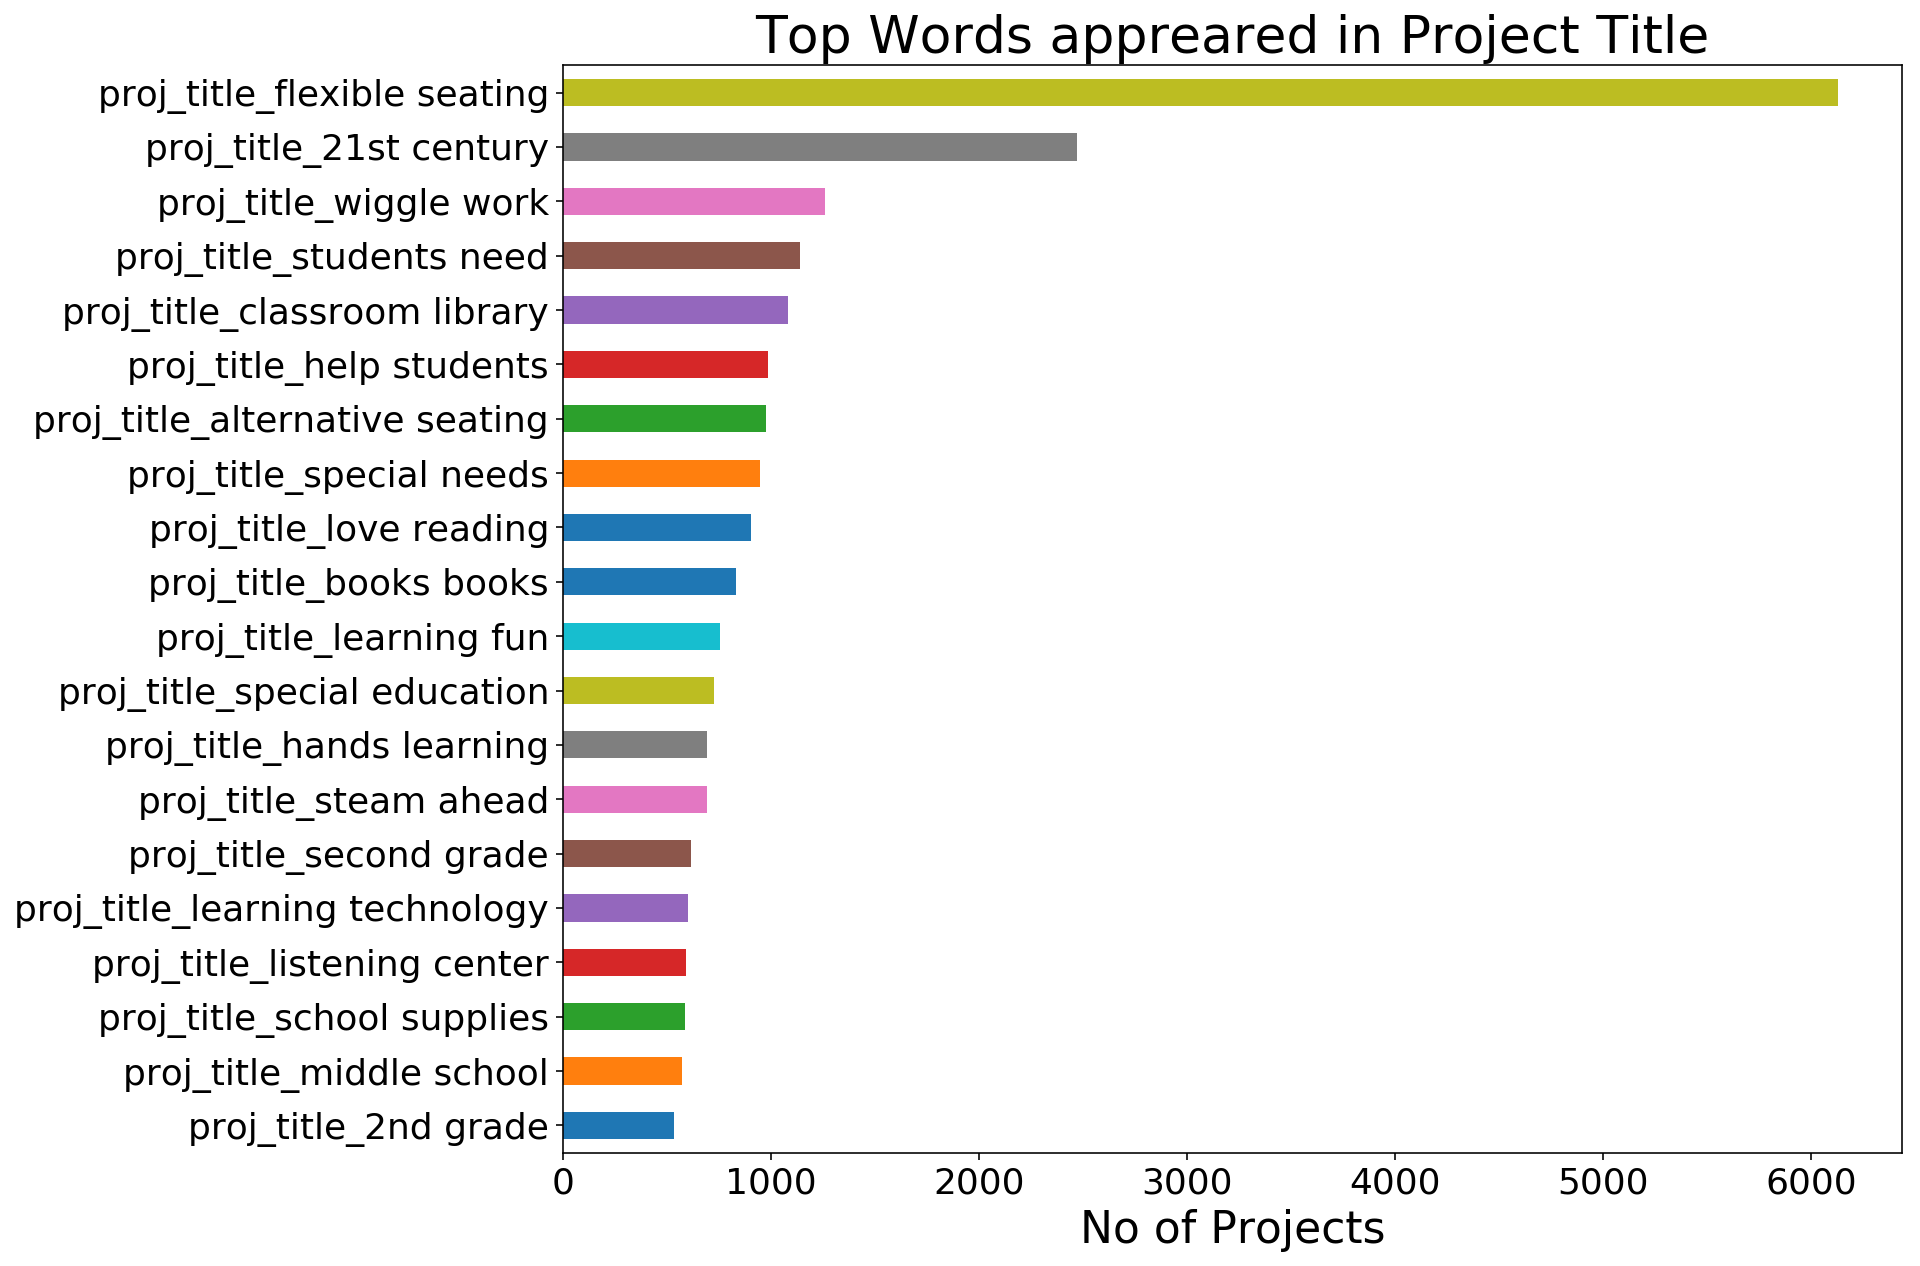

In [130]:
project_title_features.sum().sort_values(ascending=False) \
                                       .head(20).sort_values(ascending=True) \
                                       .plot(kind='barh', figsize=(12,10), fontsize=18)
plt.title('Top Words appreared in Project Title', fontsize=26)
plt.xlabel('No of Projects', fontsize=22)
plt.show()

([], <a list of 0 Text yticklabel objects>)

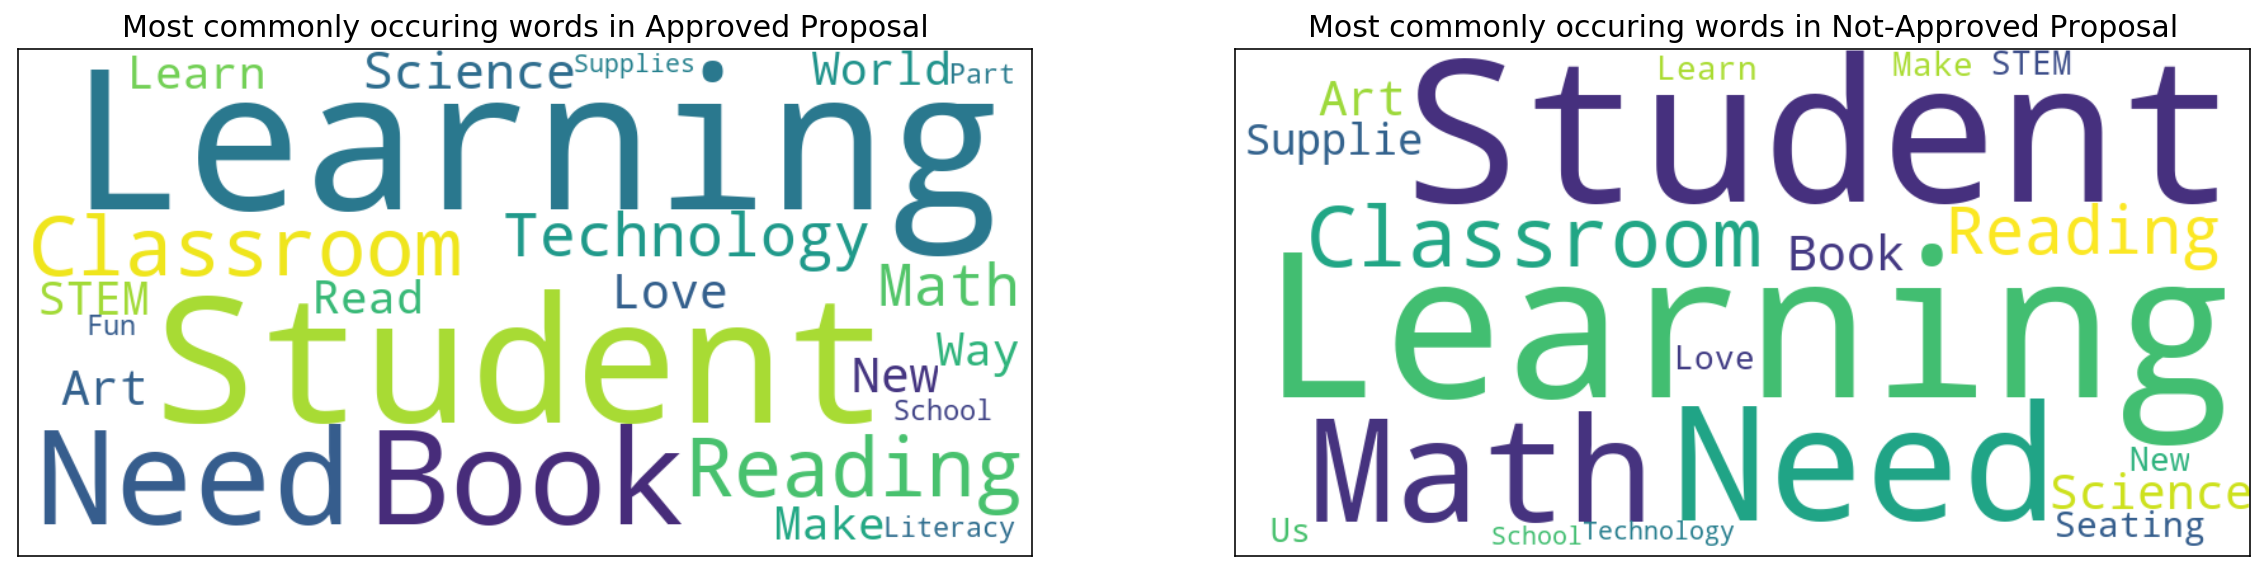

In [131]:
#Take a look at the most commonly occuring words in the Project resource summary

#Separate the text for approval and not approval
texthigh = ''.join(words for words in whole_df[whole_df['project_is_approved']==1.0]['project_title'])
textlow = ''.join(words for words in whole_df[whole_df['project_is_approved']==0.0]['project_title'])

#Generate the words clouds for higher and lower paying jobs
wordcloudhigh=WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(texthigh)
wordcloudlow= WordCloud(min_font_size=10,scale = 2,prefer_horizontal=1, background_color='White').generate(textlow)

#Plot the wordclouds
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(wordcloudhigh,interpolation='bilinear')
plt.title('Most commonly occuring words in Approved Proposal',fontsize=15)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(wordcloudlow,interpolation='bilinear')
plt.title('Most commonly occuring words in Not-Approved Proposal',fontsize=15)
plt.xticks([])
plt.yticks([])

In [132]:
project_title_features.columns = [ 'proj_title_'+ x for x in project_title_features.columns]

# 6. Selecting and Adding Features

In [133]:
whole_df.head(3)

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   

            project_subject_subcategories             project_title  \
0                                Literacy  Super Sight Word Centers   
1            Performing Arts, Team Sports    Keep Calm and Dance On   
2  Applied Sciences, Literature & Writing     Lets 3Doodle to Learn   

                         ...                          \
0                        ...                           
1                        ...                           
2                        ...                           

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nanos to create and di...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler We are an SEM sc...   

  teacher_number_of_previously_posted_projects  project_is_approved  budget  \
0                                           26                  1.0  899.94   
1                                            1                  0.0  400.00   
2                                            5                  1.0  469.99   

         date                                  project_essay_1_2  \
0  2016-11-18  Most of my kindergarten students come from low...   
1  2017-04-26  Our elementary school is a culturally rich sch...   
2  2017-01-01  HelloMy name is Mrs Brotherton I teach 5th gra...   

                                   project_essay_3_4  
0  I currently have a differentiated sight word c...  
1  We strive to provide our diverse population of...  
2  We are looking to add some 3Doodler to our cla...  

[3 rows x 21 columns]

In [134]:
whole_df = pd.concat([whole_df,subcat_features,project_title_features,project_resource_summary_features],axis=1)
whole_df.head(3)

id                        teacher_id teacher_prefix  gender  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.  female   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.  female   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.  female   

  school_state project_submitted_datetime project_grade_category  \
0           NV        2016-11-18 14:45:59          Grades PreK-2   
1           GA        2017-04-26 15:57:28             Grades 3-5   
2           UT        2017-01-01 22:57:44             Grades 3-5   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   

            project_subject_subcategories             project_title  \
0                                Literacy  Super Sight Word Centers   
1            Performing Arts, Team Sports    Keep Calm and Dance On   
2  Applied Sciences, Literature & Writing     Lets 3Doodle to Learn   

                ...               proj_resource_sum_students need hands  \
0               ...                                                   0   
1               ...                                                   0   
2               ...                                                   0   

  proj_resource_sum_students need headphones  \
0                                          0   
1                                          0   
2                                          0   

  proj_resource_sum_students need ipad proj_resource_sum_students need ipads  \
0                                    0                                     0   
1                                    0                                     0   
2                                    0                                     0   

  proj_resource_sum_students need materials  \
0                                         0   
1                                         0   
2                                         0   

   proj_resource_sum_students need new  \
0                                    0   
1                                    0   
2                                    0   

   proj_resource_sum_students need supplies  \
0                                         0   
1                                         0   
2                                         0   

   proj_resource_sum_students need variety  \
0                                        0   
1                                        0   
2                                        0   

  proj_resource_sum_students need wobble proj_resource_sum_wobble chairs  
0                                      0                               0  
1                                      0                               0  
2                                      0                               0  

[3 rows x 946 columns]

In [135]:
whole_df.shape

(260115, 946)

# 7. Modelling

In [136]:
train = whole_df[(whole_df.project_is_approved == 1.0) | \
                 (whole_df.project_is_approved == 0.0)]
test = whole_df[(whole_df.project_is_approved != 1.0) & \
                 (whole_df.project_is_approved != 0.0)]

In [137]:
print(train.shape)
print(test.shape)


(182080, 946)
(78035, 946)


In [138]:
train.project_is_approved = train.project_is_approved.apply(lambda x : int(x))


In [139]:
train[['project_is_approved','budget','teacher_number_of_previously_posted_projects']].corr()

project_is_approved    budget  \
project_is_approved                                      1.000000 -0.033018   
budget                                                  -0.033018  1.000000   
teacher_number_of_previously_posted_projects             0.065579 -0.037980   

                                              teacher_number_of_previously_posted_projects  
project_is_approved                                                               0.065579  
budget                                                                           -0.037980  
teacher_number_of_previously_posted_projects                                      1.000000

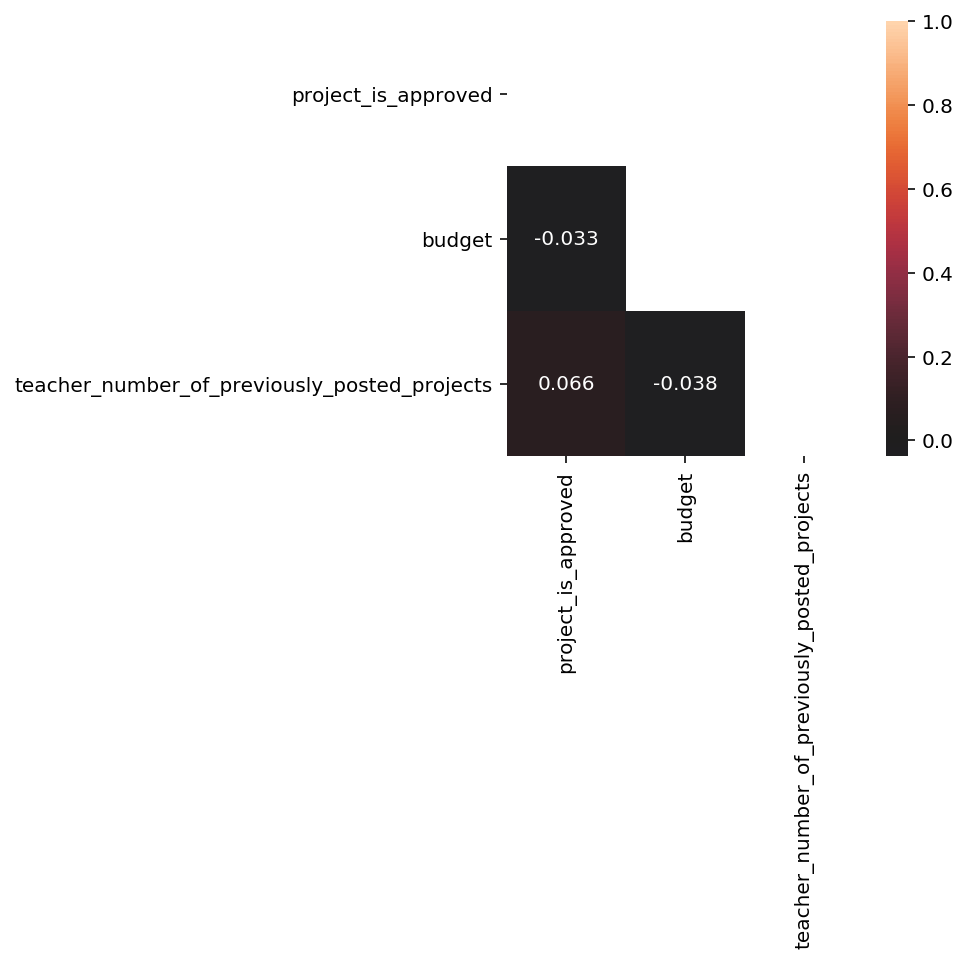

In [140]:
plt.figure(figsize=(4,4))
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(train[['project_is_approved', 'budget',
                            'teacher_number_of_previously_posted_projects']].corr(), 
                     dtype = np.bool )
mask[np.triu_indices_from(mask)] = True
# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
sns.heatmap(train[['project_is_approved','budget', 
                   'teacher_number_of_previously_posted_projects']].corr(), 
            mask=mask, annot=True, center=0)
plt.yticks(rotation=0)
plt.show()


In [141]:
print(whole_df.shape[1])
print("No of same features in train and test are not : ",\
      sum(train.columns == test.columns))
# Confirmed that all the features are same in train and test

946
No of same features in train and test are not :  946


In [142]:
# Calculating Baseline accuracy and it's imbalance class

baseline_accuracy = 1. - train.project_is_approved.mean()
baseline_accuracy

0.15231766256590507

In [143]:
non_features = ['id', 'teacher_id', 'teacher_prefix', 'gender', 'school_state', 
                'project_submitted_datetime', 'project_grade_category',
                'project_subject_categories', 'project_subject_subcategories',
                'project_title', 'project_essay_1', 'project_essay_2', 
                'project_essay_3', 'project_essay_4', 'project_resource_summary',
                'project_is_approved', 'date', 'project_essay_1_2','project_essay_3_4']


In [144]:
# Setting Features and target
X = train[train.columns.difference(non_features)]
y = train.project_is_approved

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=24)
print(X_train.shape)
print(X_test.shape)

(127456, 927)
(54624, 927)


In [145]:
whole_df.columns


Index(['id', 'teacher_id', 'teacher_prefix', 'gender', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title',
       ...
       'proj_resource_sum_students need hands',
       'proj_resource_sum_students need headphones',
       'proj_resource_sum_students need ipad',
       'proj_resource_sum_students need ipads',
       'proj_resource_sum_students need materials',
       'proj_resource_sum_students need new',
       'proj_resource_sum_students need supplies',
       'proj_resource_sum_students need variety',
       'proj_resource_sum_students need wobble',
       'proj_resource_sum_wobble chairs'],
      dtype='object', length=946)

In [146]:
X.columns


Index(['budget', 'proj_resource_sum_21st century',
       'proj_resource_sum_alternative seating', 'proj_resource_sum_class set',
       'proj_resource_sum_classroom library',
       'proj_resource_sum_enhance learning',
       'proj_resource_sum_flexible seating',
       'proj_resource_sum_flexible seating options',
       'proj_resource_sum_hokki stools',
       'proj_resource_sum_learning environment',
       ...
       'subcat_Special Needs', 'subcat_Special Needs, Team Sports',
       'subcat_Special Needs, Visual Arts',
       'subcat_Special Needs, Warmth, Care & Hunger', 'subcat_Team Sports',
       'subcat_Team Sports, Visual Arts', 'subcat_Visual Arts',
       'subcat_Visual Arts, Warmth, Care & Hunger',
       'subcat_Warmth, Care & Hunger',
       'teacher_number_of_previously_posted_projects'],
      dtype='object', length=927)

### Using SelectKBest 

In [147]:
# trying SelectKBest for selecting Features
X_SKB = SelectKBest(chi2, k=20).fit(X, y)
print(len(X_SKB.scores_))
X_SKB.scores_

927


array([1.09307861e+05, 7.66755993e+00, 1.76430134e+00, 6.61132253e+01,
       4.92764675e+01, 1.73844674e-01, 1.02495537e+02, 4.31254837e+01,
       1.67653025e+02, 1.83784110e+01, 7.51205852e-01, 1.86240729e+02,
       2.19431144e+01, 2.46329492e+02, 6.19791957e+01, 1.31736112e+00,
       1.41650725e+02, 1.32090258e+02, 5.37835546e+02, 1.14051443e+02,
       1.10090866e+02, 3.28298756e+01, 7.81273530e+02, 3.74795589e+01,
       8.78009608e+02, 6.69920387e+01, 9.50285114e+01, 6.06986479e+01,
       1.70279045e+01, 4.49586380e-01, 1.04348324e+00, 2.43981305e+01,
       2.45514752e+02, 6.38749660e+01, 2.02982062e+00, 1.37010417e+02,
       5.20825533e+02, 1.13963277e+02, 1.14875615e+02, 3.26252664e+01,
       7.45461813e+02, 3.73137509e+01, 8.57311464e+02, 6.53507791e+01,
       9.80429110e+01, 8.08998954e+01, 1.68997850e-02, 3.91967297e+00,
       4.77586768e-01, 2.65609829e-01, 3.13855484e+00, 8.16262372e-01,
       2.57014286e+00, 1.32766488e+00, 3.77457188e+00, 1.41421949e+00,
      

In [148]:
df_scores = pd.DataFrame(X_SKB.scores_)
df_columns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
feature_Scores = pd.concat([df_columns,df_scores],axis=1)
feature_Scores.columns = ['Industry factors','Score']  #naming the dataframe columns
print(feature_Scores.nlargest(50,'Score'))  #print 10 best features

                                 Industry factors          Score
0                                          budget  109307.860580
926  teacher_number_of_previously_posted_projects   54696.262984
24                proj_resource_sum_need supplies     878.009608
42       proj_resource_sum_students need supplies     857.311464
22               proj_resource_sum_need materials     781.273530
40      proj_resource_sum_students need materials     745.461813
18                   proj_resource_sum_need hands     537.835546
36          proj_resource_sum_students need hands     520.825533
13             proj_resource_sum_need chromebooks     246.329492
32    proj_resource_sum_students need chromebooks     245.514752
11                   proj_resource_sum_need basic     186.240729
8                  proj_resource_sum_hokki stools     167.653025
838                               subcat_Literacy     161.653519
16                proj_resource_sum_need flexible     141.650725
35       proj_resource_su

In [149]:
def model_comparison(models, X_train, y_train, score_type, 
                     model1='Logistic Regression', model2='Random Forest', 
                     model3='XGBoost'):
    scores_dict = {}
    model_names = [model1, model2, model3]
    
    # Use the KFold class to add more options.
    kf_shuffle = KFold(n_splits=10,shuffle=True, random_state=42) 
    
    count=0
    for model in models:
        scores = cross_val_score(model, X_train, y_train, cv=kf_shuffle, 
                                 n_jobs=-1,scoring=score_type, verbose=1)
        scores_dict[model] = scores
        
        print("{} Avg Score: ".format(model_names[count]), \
                                      np.mean(scores_dict[models[count]]))
        print("{} Std Score: ".format(model_names[count]), \
                                      np.std(scores_dict[models[count]]))
        
        count += 1
        
#     print("{} Avg Score: ".format(model1),np.mean(scores_dict[models[0]]))
#     print("{} Std Score: ".format(model1),np.std(scores_dict[models[0]]))
#     print("{} Avg Score: ".format(model2),np.mean(scores_dict[models[1]]))
#     print("{} Std Score: ".format(model2),np.std(scores_dict[models[1]]))
        
    return pd.DataFrame(scores_dict)

In [150]:
def plot_models_compare_result(result,
                               model1='Logistic Regression',
                               model2='Random Forest', 
                               model3='XGBoost'):
    plt.figure(figsize=(8,6))
    result.boxplot()
    plt.xticks(np.arange(4),['',model1,model2,model3])
    plt.show()

In [151]:
def model_evaluation(y_pred,y_pred_pp,model):
    
    tp = np.sum((y_test == 1) & (y_pred == 1))
    fp = np.sum((y_test == 0) & (y_pred == 1))
    tn = np.sum((y_test == 0) & (y_pred == 0))
    fn = np.sum((y_test == 1) & (y_pred == 0))
    
    # Creating confusion_matrix dataframe
    confusion_matrix_df = pd.DataFrame([(tn,fp),(fn,tp)], 
                                     index=['Not Approved','Approved'],
                                     columns=['Prediced Not Approved',
                                              'Prediced Approved'])
    print(confusion_matrix_df)
    print("TN = {}, FP = {}".format(tn,fp))
    print("FN = {}, TP = {}".format(fn, tp))
    
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1score = 2 *((recall*precision)/(recall+precision))
    print('Sensitivity / Recall (true positive rate) :', recall)
    print('Precision (positive predictive value) :', precision)
    print('f1 score :', f1score)
        
    # Checking Accuracy
    accuracy = accuracy_score(y_test,y_pred)
    roc_auc = roc_auc_score(y_test,y_pred_pp[:,1])
    print("Accuracy : {}\n".format(accuracy))
    print("ROC AUC Score : {}\n".format(roc_auc))
    
    # Plotting Confusion Matrix with Heatmap
    confusion_matrix_df.index = [0,1]
    confusion_matrix_df.columns = [0,1]
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(confusion_matrix_df, annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print(classification_report(y_test,y_pred),'\n')
    
    y_pred_pp_df = pd.DataFrame(y_pred_pp, columns=['class_0_pp','class_1_pp'])
   
    # Plotting ROC curve

    # Finding the area under the curve for class 1 (High Salary : Salary > median) 
    fpr, tpr, _ = roc_curve(y_test, y_pred_pp_df.class_1_pp)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0,1], [0,1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver Operating Characteristic (ROC) for Approval Prediction - {}'.format(model), fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    
    return recall, precision, f1score, roc_auc, accuracy

### 6.1 Logistic, Random Forest and XGBoost

In [152]:
model_results = pd.DataFrame(columns = ['Recall','Precision','f1_score','ROC_AUC',
                                        'Accuracy'])

In [153]:
weights = ((y == 0).sum()) / (1.0 * (y == 1).sum())

In [155]:
logreg = LogisticRegression()
rfc = RandomForestClassifier()
xgb = XGBClassifier(scale_pos_weight=weights)

print(logreg)
print(rfc)
print(xgb)

# checking model's ccross_val_score to compare and plot boxplot from the scores
# models_compare_result = model_comparison([logreg,rfc,xgb], X_train, y_train, 'roc_auc')
# plot_models_compare_result(models_compare_result)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_

              Prediced Not Approved  Prediced Approved
Not Approved                      8               8386
Approved                         11              46219
TN = 8, FP = 8386
FN = 11, TP = 46219
Sensitivity / Recall (true positive rate) : 0.9997620592688731
Precision (positive predictive value) : 0.8464243201172054
f1 score : 0.916725343382754
Accuracy : 0.8462763620386643

ROC AUC Score : 0.6339682465318929

              precision    recall  f1-score   support

           0       0.42      0.00      0.00      8394
           1       0.85      1.00      0.92     46230

   micro avg       0.85      0.85      0.85     54624
   macro avg       0.63      0.50      0.46     54624
weighted avg       0.78      0.85      0.78     54624
 



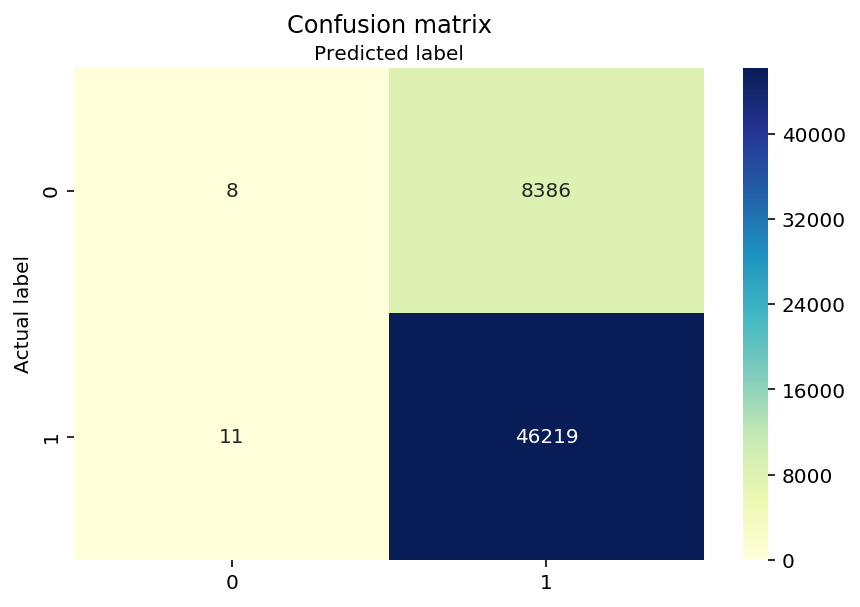

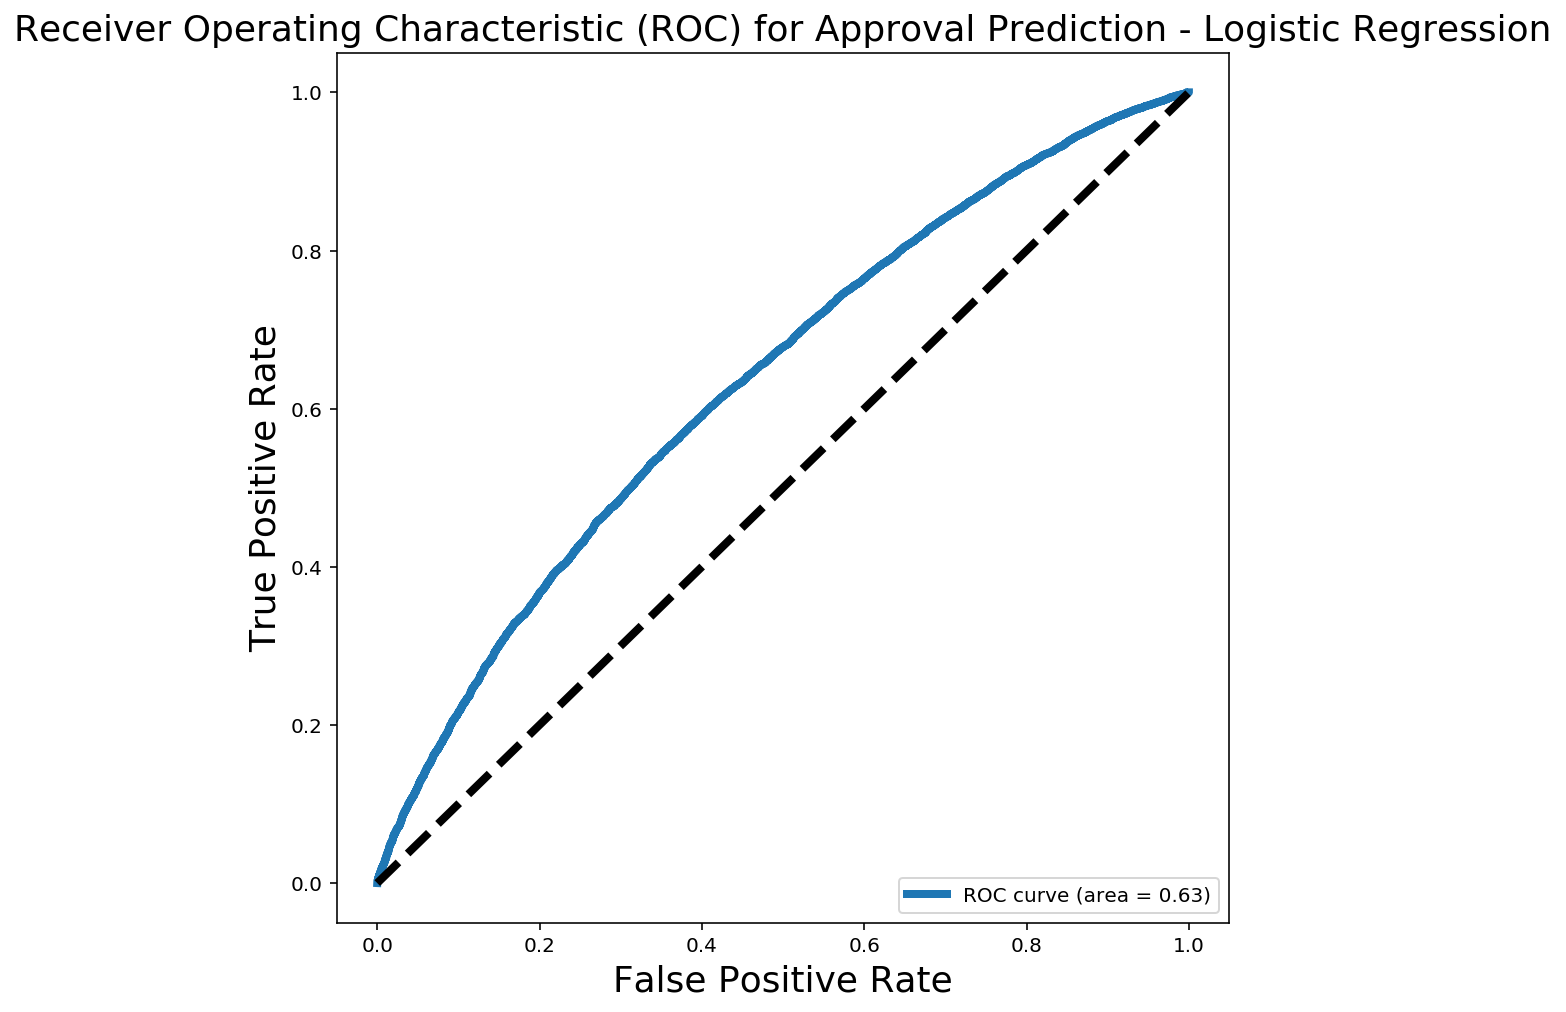

In [156]:
logreg.fit(X_train,y_train)

yhat = logreg.predict(X_test)
yhat_pp = logreg.predict_proba(X_test)

recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,yhat_pp,
                                                        "Logistic Regression")
model_results.loc['Logistic Regression'] = [recall, precision, f1_score, 
                                            roc_auc, accuracy]

              Prediced Not Approved  Prediced Approved
Not Approved                   1232               7162
Approved                       4492              41738
TN = 1232, FP = 7162
FN = 4492, TP = 41738
Sensitivity / Recall (true positive rate) : 0.9028336577979666
Precision (positive predictive value) : 0.8535378323108385
f1 score : 0.877493955639651
Accuracy : 0.7866505565319274

ROC AUC Score : 0.5607126916824234

              precision    recall  f1-score   support

           0       0.22      0.15      0.17      8394
           1       0.85      0.90      0.88     46230

   micro avg       0.79      0.79      0.79     54624
   macro avg       0.53      0.52      0.53     54624
weighted avg       0.76      0.79      0.77     54624
 



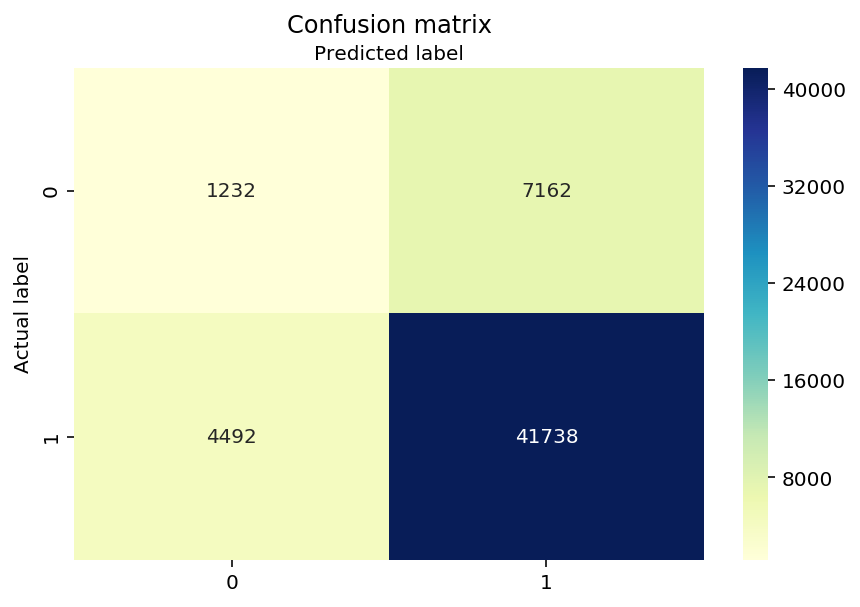

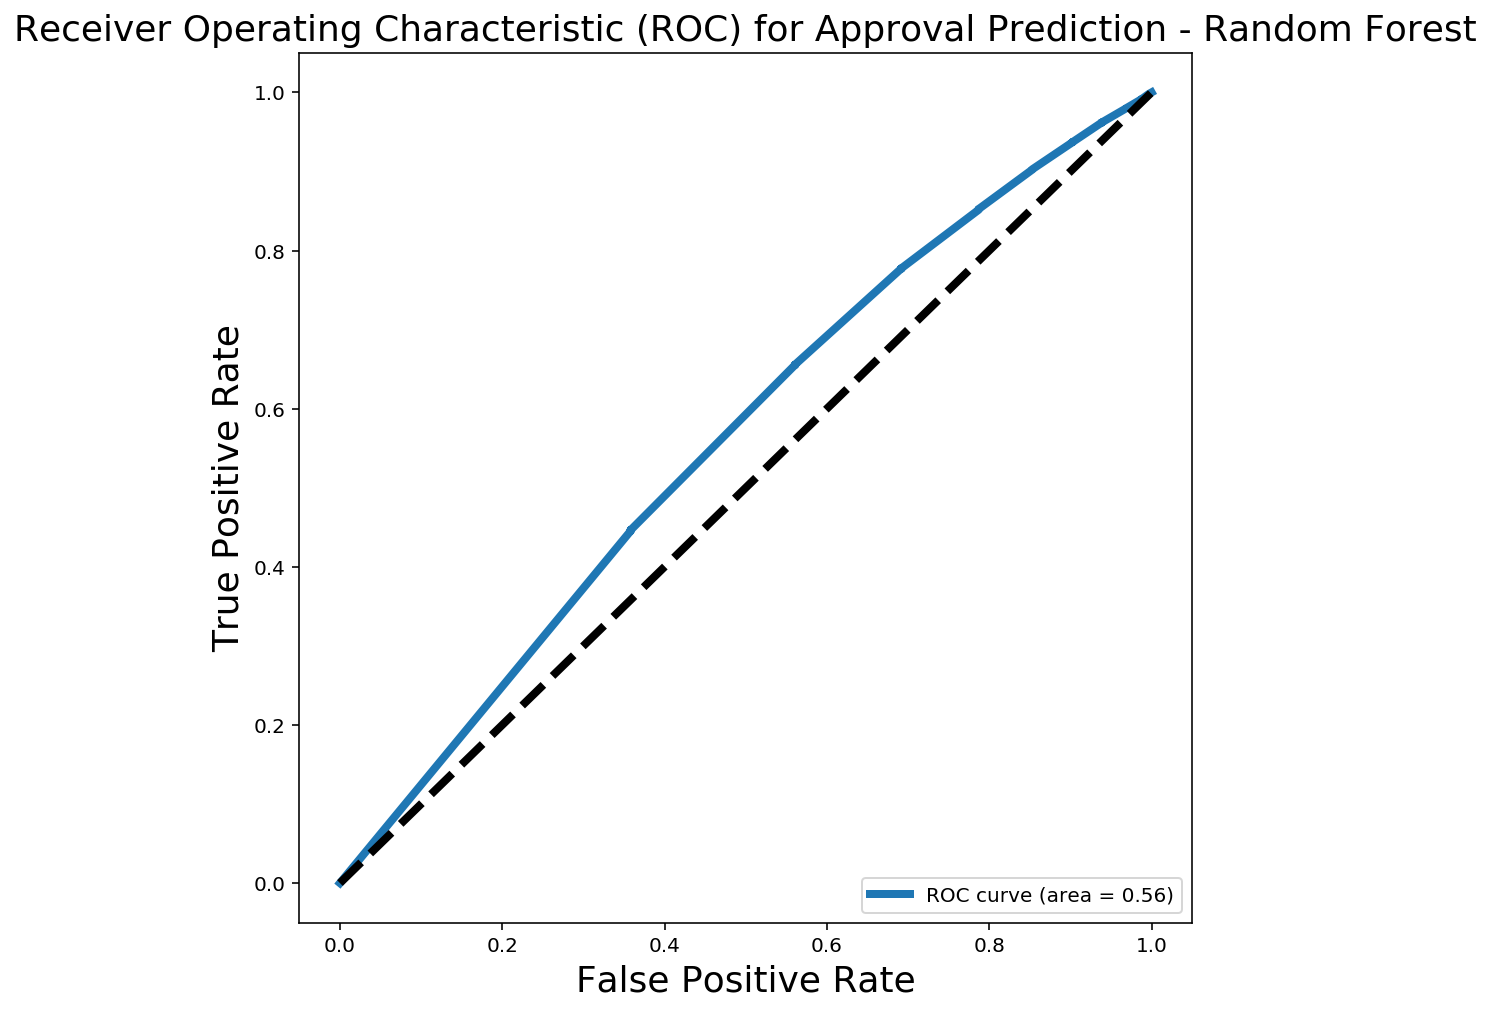

In [157]:
rfc.fit(X_train,y_train)

yhat = rfc.predict(X_test)
yhat_pp = rfc.predict_proba(X_test)

recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,
                                                                  yhat_pp,
                                                                  'Random Forest')
model_results.loc['Random Forest'] = [recall, precision, f1_score, roc_auc, accuracy]

              Prediced Not Approved  Prediced Approved
Not Approved                   5011               3383
Approved                      19394              26836
TN = 5011, FP = 3383
FN = 19394, TP = 26836
Sensitivity / Recall (true positive rate) : 0.5804888600475882
Precision (positive predictive value) : 0.888050564214567
f1 score : 0.7020628131172416
Accuracy : 0.5830221148213239

ROC AUC Score : 0.6301556376264763

              precision    recall  f1-score   support

           0       0.21      0.60      0.31      8394
           1       0.89      0.58      0.70     46230

   micro avg       0.58      0.58      0.58     54624
   macro avg       0.55      0.59      0.50     54624
weighted avg       0.78      0.58      0.64     54624
 



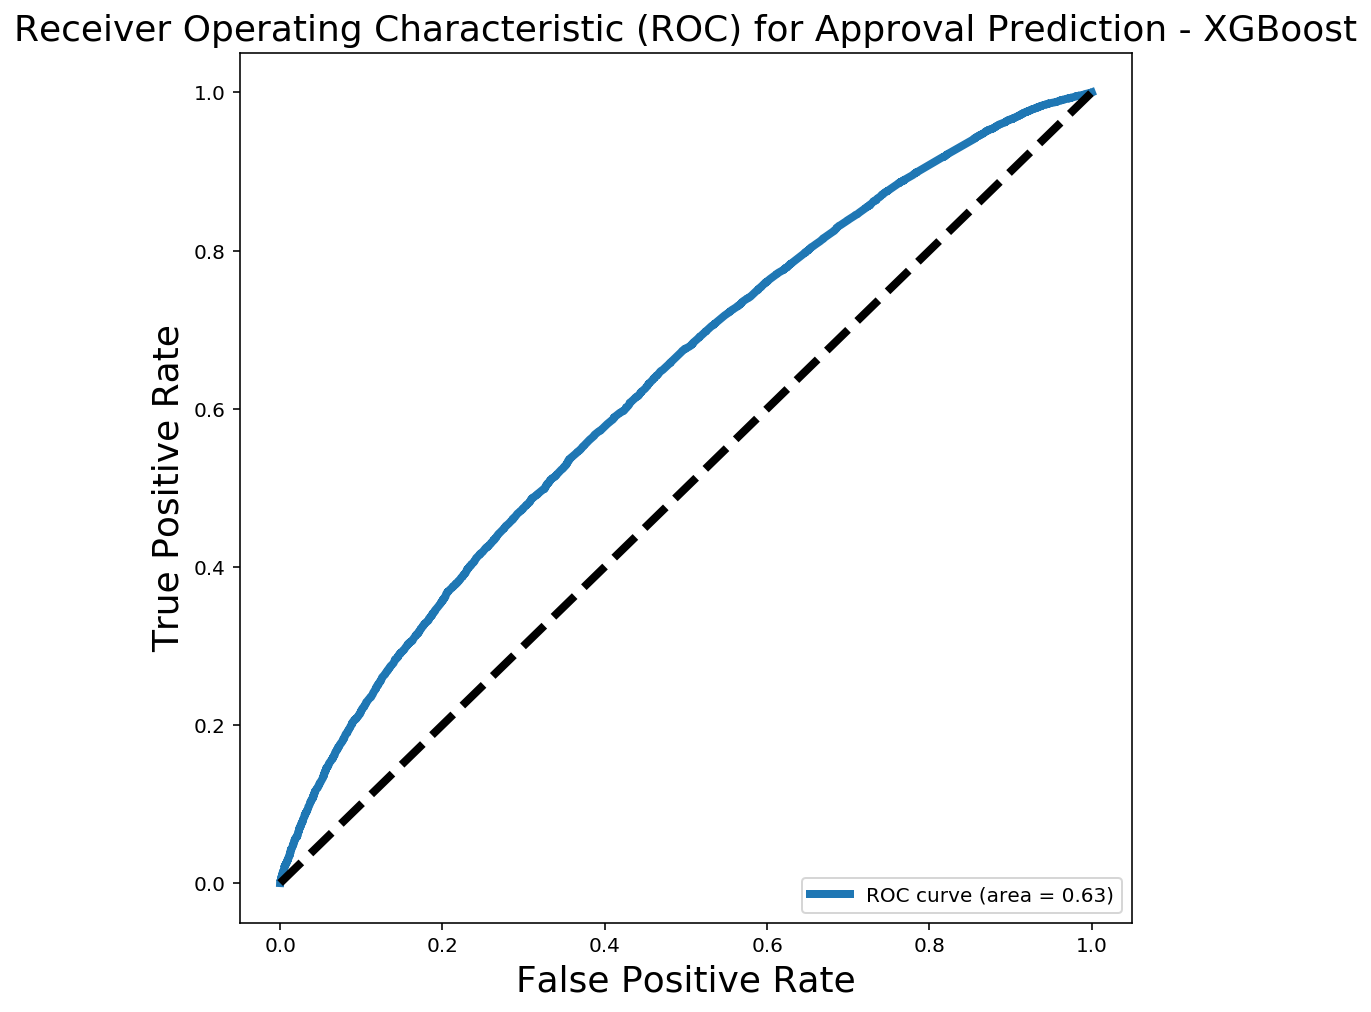

In [158]:
xgb.fit(X_train.values,y_train)

yhat = xgb.predict(X_test.values)
yhat_pp = xgb.predict_proba(X_test.values)

recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,yhat_pp,
                                                        "XGBoost")
model_results.loc['XGBoost'] = [recall, precision, f1_score, 
                                            roc_auc, accuracy]

### 6.2 Upsampling with SMOTE

In [159]:
sm=SMOTE(random_state=42)


In [160]:
X_train_smote, y_train_smote = sm.fit_sample(X_train,y_train)

print(X_train.shape)
print(X_train_smote.shape)
print(y_train_smote.shape)
print(np.bincount(y_train_smote))


(127456, 927)
(216232, 927)
(216232,)
[108116 108116]


In [161]:
logreg_smote = LogisticRegression()
rfc_smote = RandomForestClassifier()
#xgb_smote = XGBClassifier()

print(logreg_smote)
print(rfc_smote)
#print(xgb_smote)

# checking model's ccross_val_score to compare and plot boxplot from the scores
# models_compare_result = model_comparison([logreg_smote,rfc_smote,xgb_smote], X_train_smote, y_train_smote, 
#                                          'roc_auc')
# plot_models_compare_result(models_compare_result)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


              Prediced Not Approved  Prediced Approved
Not Approved                   5323               3071
Approved                      21219              25011
TN = 5323, FP = 3071
FN = 21219, TP = 25011
Sensitivity / Recall (true positive rate) : 0.5410123296560675
Precision (positive predictive value) : 0.8906416921871662
f1 score : 0.6731348907309721
Accuracy : 0.5553236672524897

ROC AUC Score : 0.6221795761637885

              precision    recall  f1-score   support

           0       0.20      0.63      0.30      8394
           1       0.89      0.54      0.67     46230

   micro avg       0.56      0.56      0.56     54624
   macro avg       0.55      0.59      0.49     54624
weighted avg       0.78      0.56      0.62     54624
 



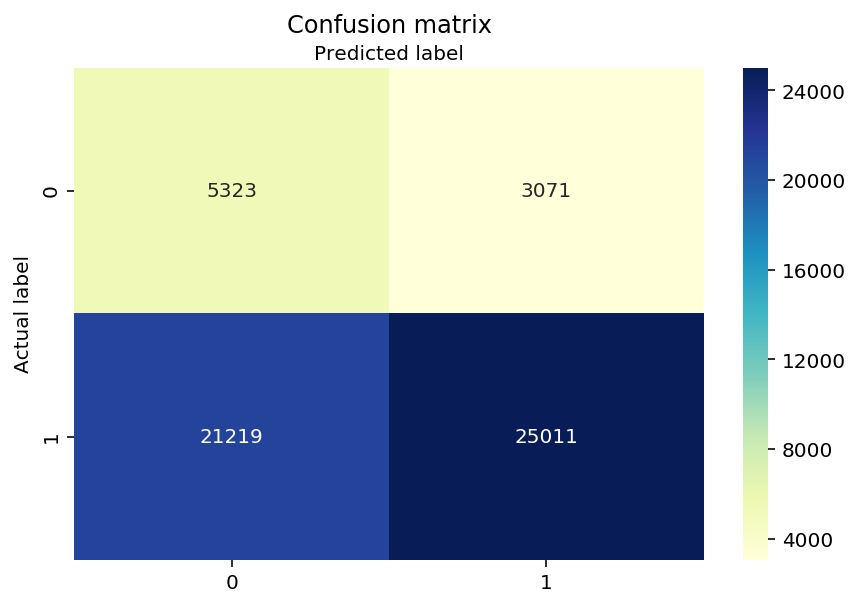

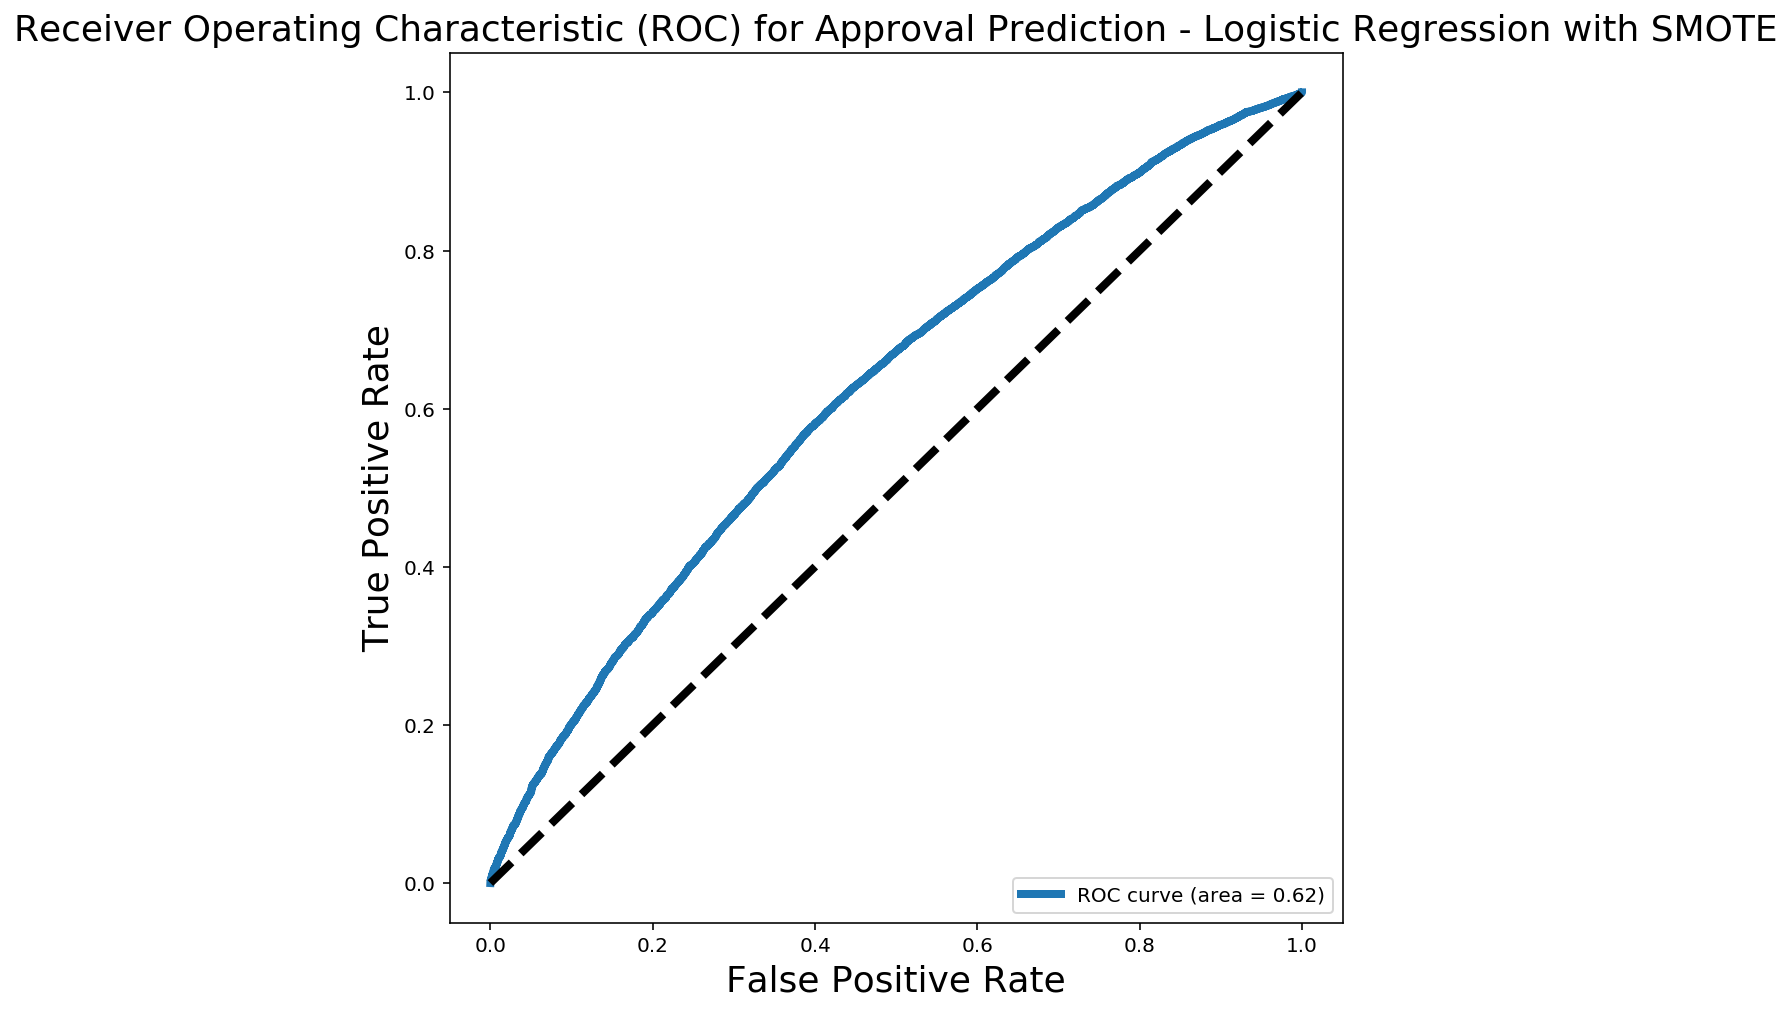

In [162]:
logreg_smote.fit(X_train_smote,y_train_smote)

yhat = logreg_smote.predict(X_test)
yhat_pp = logreg_smote.predict_proba(X_test)

recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,
                                                                  yhat_pp,
                                                                  "Logistic Regression with SMOTE")
model_results.loc['Logistic Regression with SMOTE'] = [recall, precision, f1_score, 
                                            roc_auc, accuracy]

              Prediced Not Approved  Prediced Approved
Not Approved                   1278               7116
Approved                       4876              41354
TN = 1278, FP = 7116
FN = 4876, TP = 41354
Sensitivity / Recall (true positive rate) : 0.8945273631840795
Precision (positive predictive value) : 0.8531875386837219
f1 score : 0.8733685322069693
Accuracy : 0.7804628002343292

ROC AUC Score : 0.5527131927974469

              precision    recall  f1-score   support

           0       0.21      0.15      0.18      8394
           1       0.85      0.89      0.87     46230

   micro avg       0.78      0.78      0.78     54624
   macro avg       0.53      0.52      0.52     54624
weighted avg       0.75      0.78      0.77     54624
 



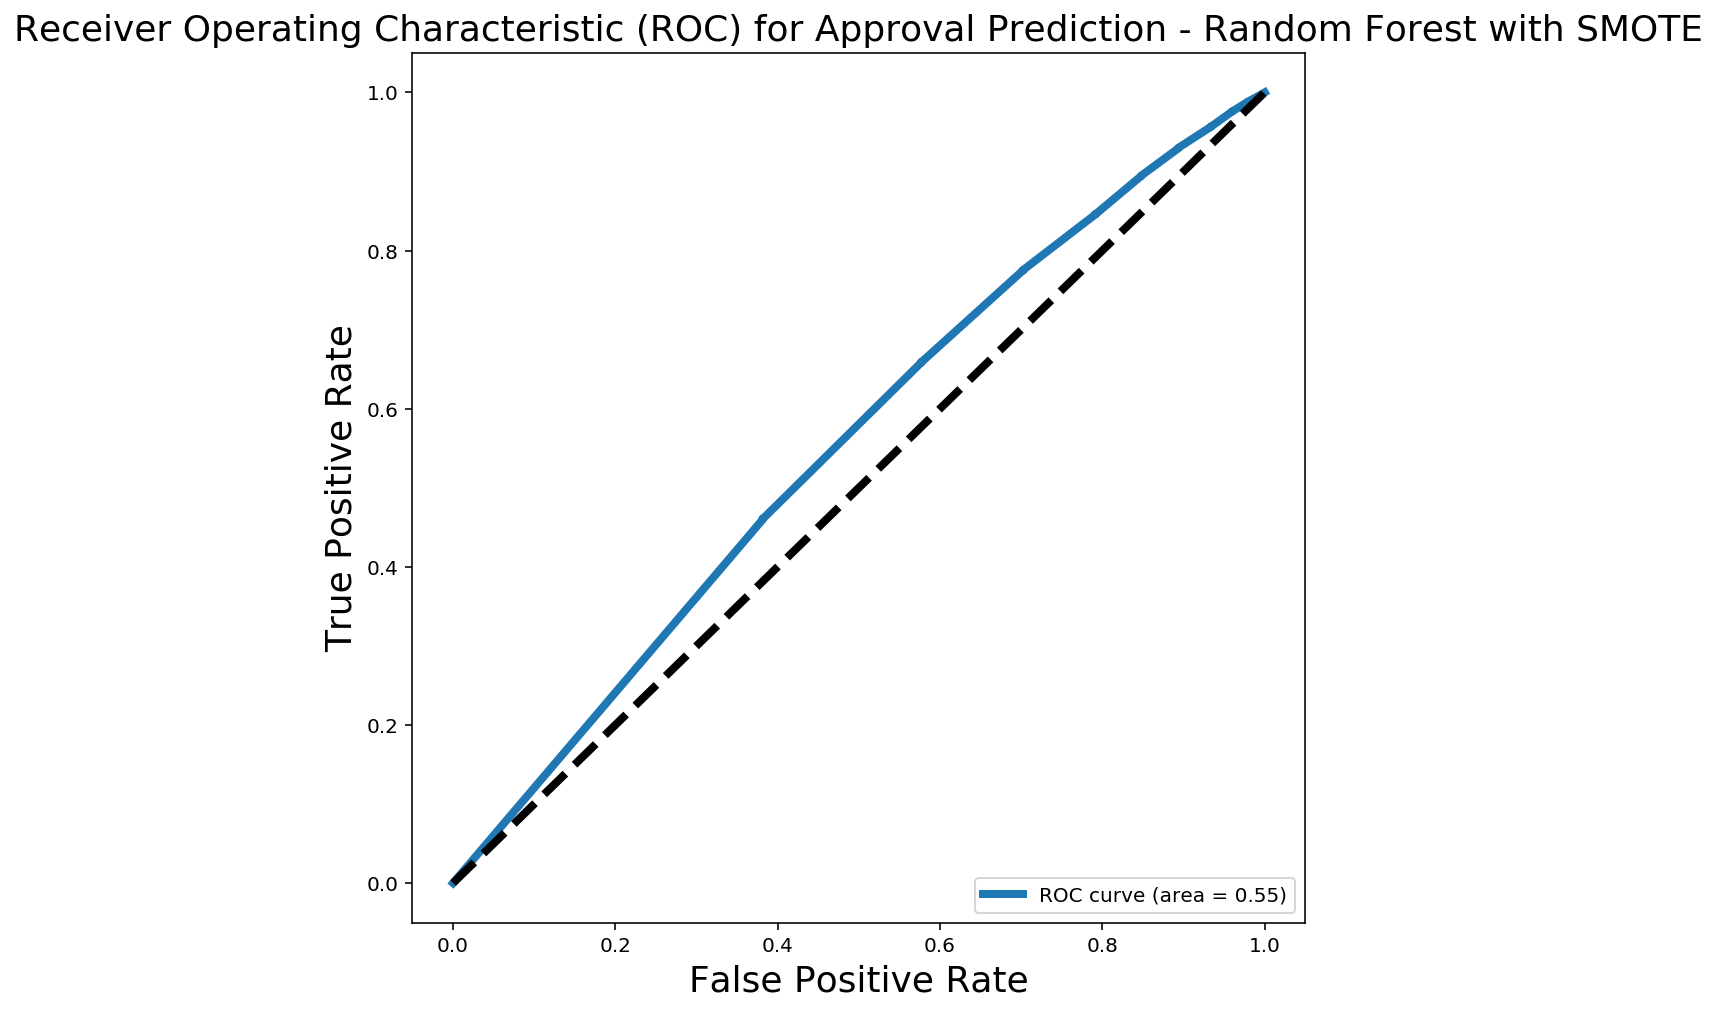

In [163]:
rfc_smote.fit(X_train_smote,y_train_smote)

yhat = rfc_smote.predict(X_test)
yhat_pp = rfc_smote.predict_proba(X_test)

recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,
                                                                  yhat_pp,
                                                                  'Random Forest with SMOTE')
model_results.loc['Random Forest with SMOTE'] = [recall, precision, f1_score, 
                                            roc_auc, accuracy]

In [164]:
# xgb_smote.fit(X_train_smote,y_train_smote)

# yhat = xgb_smote.predict(X_test.values)
# yhat_pp = xgb_smote.predict_proba(X_test.values)

# recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,
#                                                                   yhat_pp,
#                                                                   "XGBoost with SMOTE")
# model_results.loc['XGBoost with SMOTE'] = [recall, precision, f1_score, 
#                                             roc_auc, accuracy]

### 6.3 Upsampling with ADASYN

In [165]:
adasyn = ADASYN()
X_train_adasyn, y_train_adasyn = adasyn.fit_sample(X_train, y_train)

print(X_train.shape)
print(X_train_adasyn.shape)
print(y_train_adasyn.shape)
print(np.bincount(y_train_adasyn))

(127456, 927)
(215788, 927)
(215788,)
[107672 108116]


In [166]:
logreg_adasyn = LogisticRegression()
rfc_adasyn = RandomForestClassifier()
#xgb_adasyn = XGBClassifier()

print(logreg_adasyn)
print(rfc_adasyn)
#print(xgb_adasyn)

# # checking model's cross_val_score to compare and plot boxplot from the scores
# models_compare_result = model_comparison([logreg_adasyn,rfc_adasyn,xgb_adasyn], X_train_adasyn, 
#                                          y_train_adasyn, 'roc_auc')
# plot_models_compare_result(models_compare_result)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


              Prediced Not Approved  Prediced Approved
Not Approved                   5381               3013
Approved                      21669              24561
TN = 5381, FP = 3013
FN = 21669, TP = 24561
Sensitivity / Recall (true positive rate) : 0.5312783906554186
Precision (positive predictive value) : 0.890730398201204
f1 score : 0.6655736816432714
Accuracy : 0.5481473345049795

ROC AUC Score : 0.6198719860621682

              precision    recall  f1-score   support

           0       0.20      0.64      0.30      8394
           1       0.89      0.53      0.67     46230

   micro avg       0.55      0.55      0.55     54624
   macro avg       0.54      0.59      0.48     54624
weighted avg       0.78      0.55      0.61     54624
 



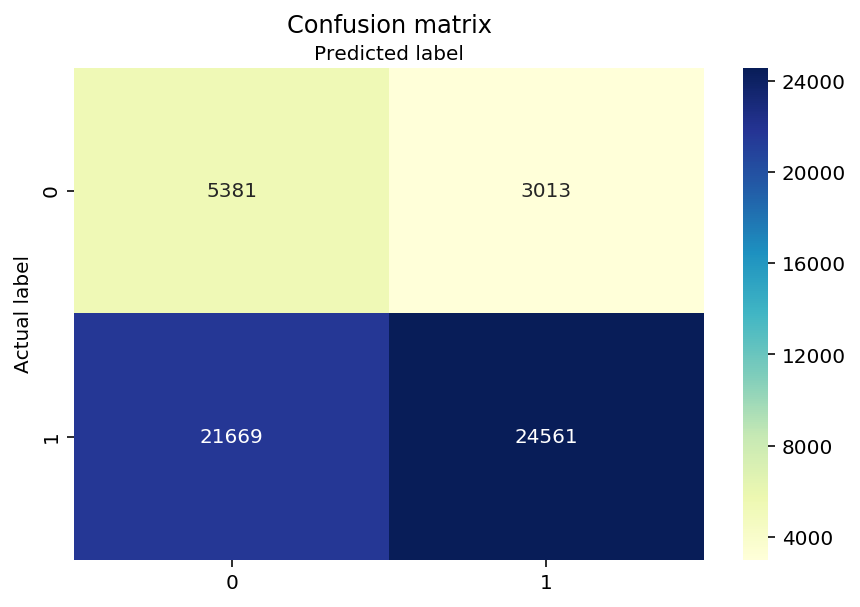

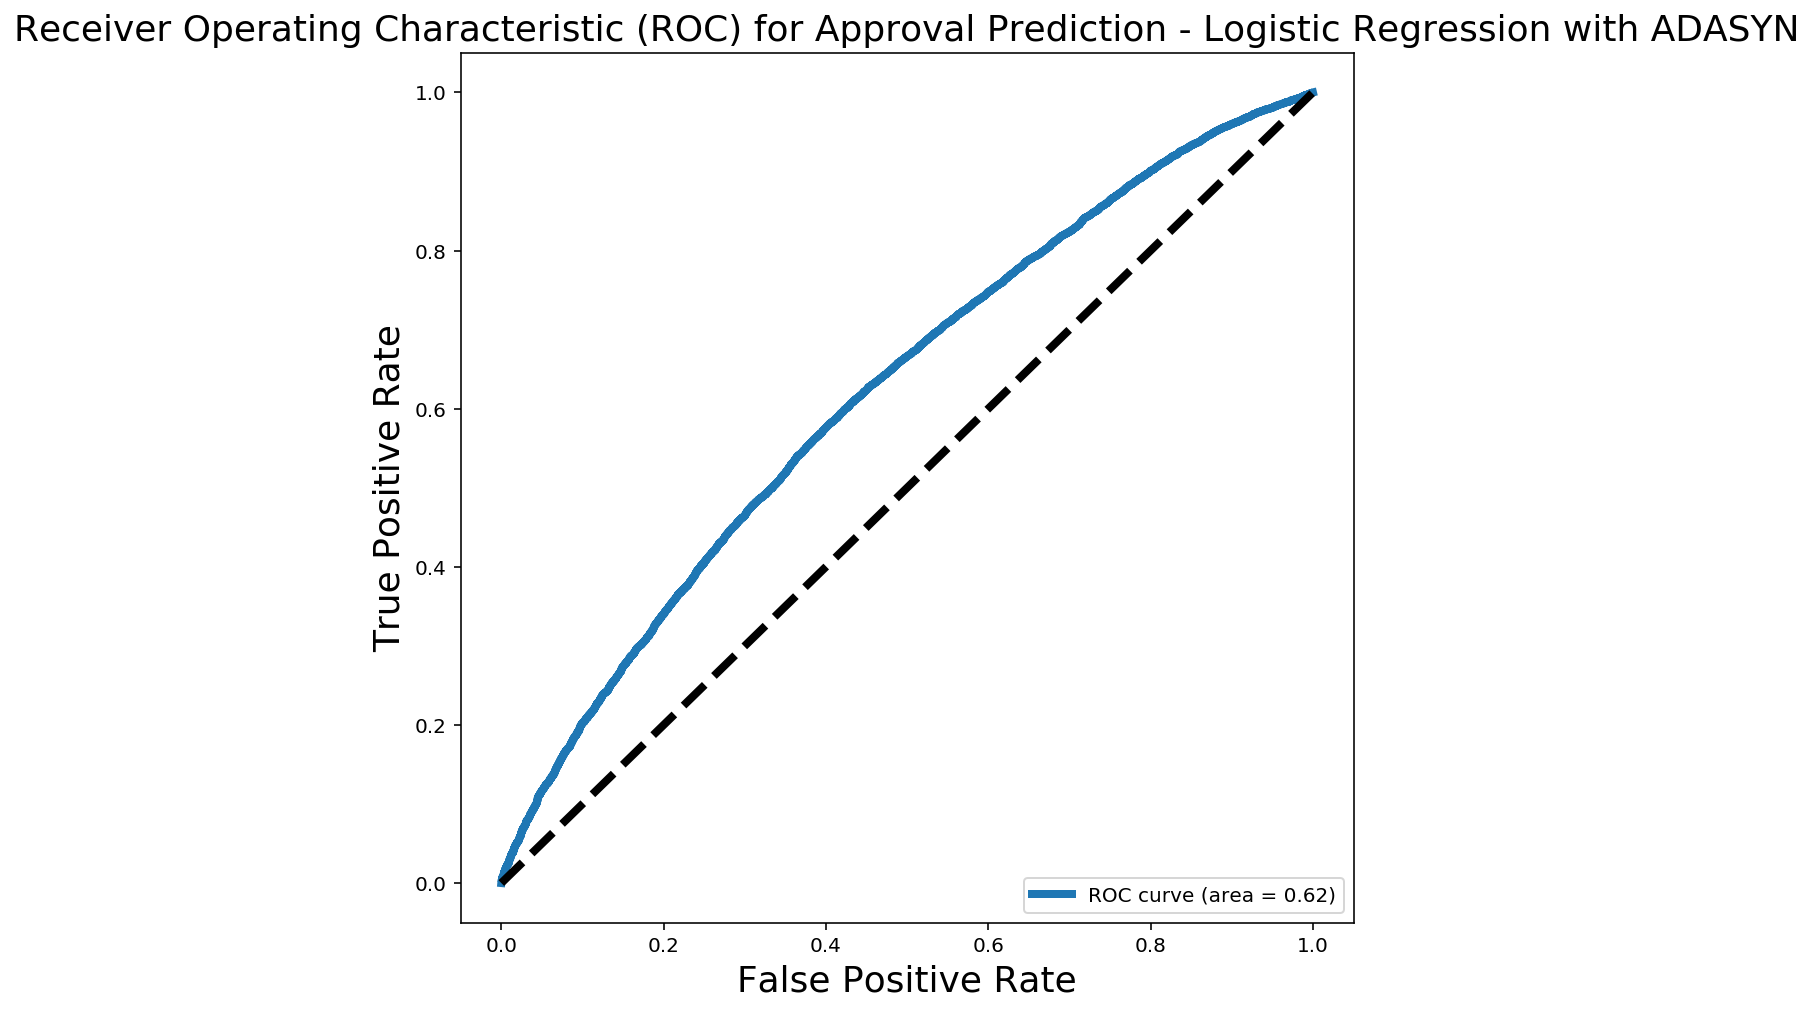

In [167]:
logreg_adasyn.fit(X_train_adasyn,y_train_adasyn)

yhat = logreg_adasyn.predict(X_test)
yhat_pp = logreg_adasyn.predict_proba(X_test)

recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,
                                                                  yhat_pp,
                                                                  "Logistic Regression with ADASYN")
model_results.loc['Logistic Regression with ADASYN'] = [recall, precision, f1_score, 
                                            roc_auc, accuracy]

              Prediced Not Approved  Prediced Approved
Not Approved                   1232               7162
Approved                       4492              41738
TN = 1232, FP = 7162
FN = 4492, TP = 41738
Sensitivity / Recall (true positive rate) : 0.9028336577979666
Precision (positive predictive value) : 0.8535378323108385
f1 score : 0.877493955639651
Accuracy : 0.7866505565319274

ROC AUC Score : 0.5607126916824234

              precision    recall  f1-score   support

           0       0.22      0.15      0.17      8394
           1       0.85      0.90      0.88     46230

   micro avg       0.79      0.79      0.79     54624
   macro avg       0.53      0.52      0.53     54624
weighted avg       0.76      0.79      0.77     54624
 



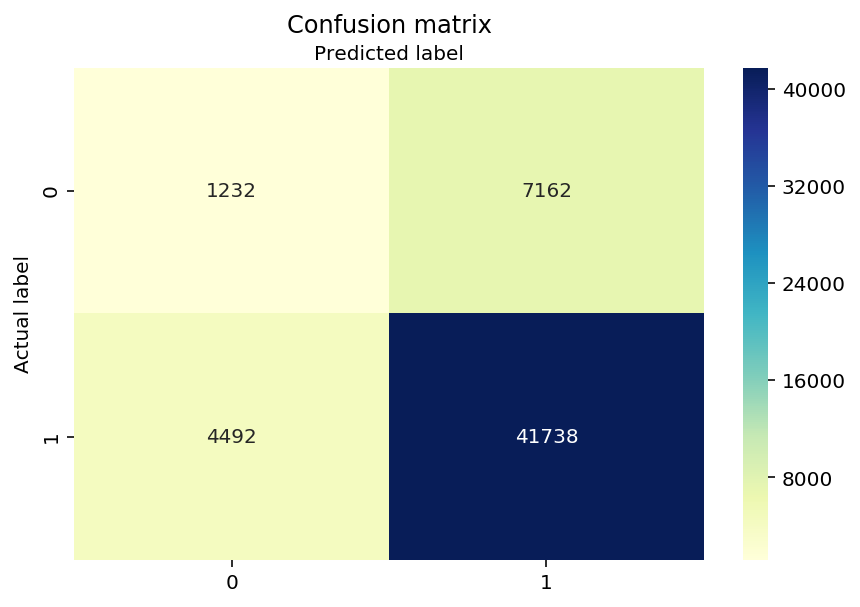

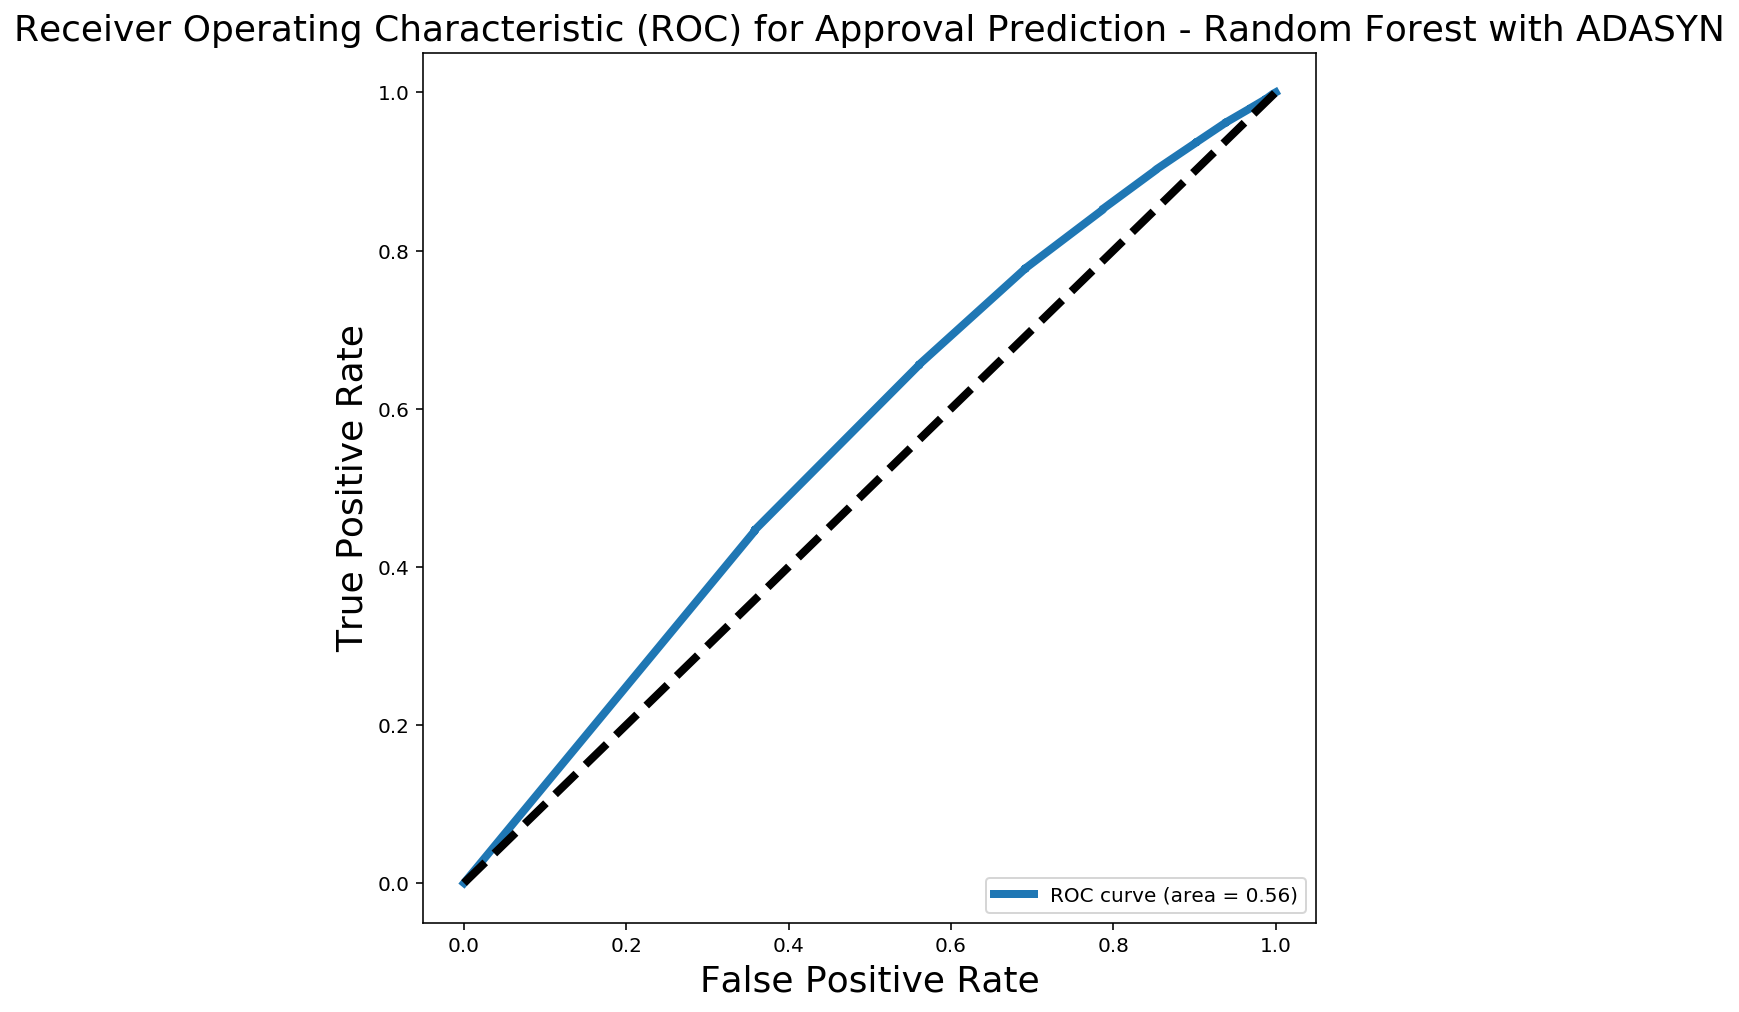

In [168]:
rfc_adasyn.fit(X_train_adasyn,y_train_adasyn)

yhat = rfc.predict(X_test)
yhat_pp = rfc.predict_proba(X_test)

recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,
                                                                  yhat_pp,
                                                                  'Random Forest with ADASYN')
model_results.loc['Random Forest with ADASYN'] = [recall, precision, f1_score, 
                                            roc_auc, accuracy]


In [169]:
# xgb_adasyn.fit(X_train_adasyn,y_train_adasyn)

# yhat = xgb_adasyn.predict(X_test.values)
# yhat_pp = xgb_adasyn.predict_proba(X_test.values)

# recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,
#                                                                   yhat_pp,
#                                                                   "XGBoost with ADASYN")
# model_results.loc['XGBoost with ADASYN'] = [recall, precision, f1_score, 
#                                             roc_auc, accuracy]

### 6.3 Upsampling with SVMSMOTE

svmsmote = SVMSMOTE(n_jobs=1)
X_train_svmsmote, y_train_svmsmote = svmsmote.fit_sample(X_train, y_train)

print(X_train.shape)
print(X_train_svmsmote.shape)
print(y_train_svmsmote.shape)
print(np.bincount(y_train_svmsmote))

logreg_svmsmote = LogisticRegression()
rfc_svmsmote = RandomForestClassifier()
#xgb_svmsmote = XGBClassifier()

print(logreg_svmsmote)
print(rfc_svmsmote)
#print(xgb_svmsmote)

# checking model's ccross_val_score to compare and plot boxplot from the scores
# models_compare_result = model_comparison([logreg_svmsmote,rfc_svmsmote, xgb_svmsmote], 
#                                          X_train_svmsmote, 
#                                          y_train_svmsmote, 
#                                          'roc_auc')
# plot_models_compare_result(models_compare_result)

logreg_svmsmote.fit(X_train_svmsmote,y_train_svmsmote)

yhat = logreg_svmsmote.predict(X_test)
yhat_pp = logreg_svmsmote.predict_proba(X_test)

recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,
                                                                  yhat_pp,
                                                                  "Logistic Regression with SVMSMOTE")
model_results.loc['Logistic Regression with SVMSMOTE'] = [recall, precision, f1_score, 
                                            roc_auc, accuracy]

rfc_svmsmote.fit(X_train_svmsmote,y_train_svmsmote)

yhat = rfc_svmsmote.predict(X_test)
yhat_pp = rfc_svmsmote.predict_proba(X_test)

recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,
                                                                  yhat_pp,
                                                                  'Random Forest with SVMSMOTE')
model_results.loc['Random Forest with SVMSMOTE'] = [recall, precision, f1_score, 
                                            roc_auc, accuracy]

In [170]:
# xgb_svmsmote.fit(X_train_svmsmote,y_train_svmsmote)

# yhat = xgb_svmsmote.predict(X_test.values)
# yhat_pp = xgb_svmsmote.predict_proba(X_test.values)

# recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,
#                                                                   yhat_pp,
#                                                                   "XGBoost with SVMSMOTE")
# model_results.loc['XGBoost with SVMSMOTE'] = [recall, precision, f1_score, 
#                                             roc_auc, accuracy]

### 6.4 Undersampling with NearMiss

In [171]:
nrm = NearMiss(n_jobs=1)
X_train_nearmiss, y_train_nearmiss = nrm.fit_sample(X_train, y_train)

print(X_train.shape)
print(X_train_nearmiss.shape)
print(y_train_nearmiss.shape)
print(np.bincount(y_train_nearmiss))

(127456, 927)
(38680, 927)
(38680,)
[19340 19340]


In [172]:
logreg_nearmiss = LogisticRegression()
rfc_nearmiss = RandomForestClassifier()
#xgb_nearmiss = XGBClassifier()

print(logreg_nearmiss)
print(rfc_nearmiss)
#print(xgb_nearmiss)

# checking model's ccross_val_score to compare and plot boxplot from the scores
# models_compare_result = model_comparison([logreg_nearmiss,rfc_nearmiss, xgb_nearmiss], 
#                                          X_train_nearmiss, 
#                                          y_train_nearmiss, 
#                                          'roc_auc')
# plot_models_compare_result(models_compare_result)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


              Prediced Not Approved  Prediced Approved
Not Approved                   6002               2392
Approved                      33596              12634
TN = 6002, FP = 2392
FN = 33596, TP = 12634
Sensitivity / Recall (true positive rate) : 0.27328574518710796
Precision (positive predictive value) : 0.8408092639424997
f1 score : 0.4124983675068565
Accuracy : 0.34116871704745166

ROC AUC Score : 0.47841957402800667

              precision    recall  f1-score   support

           0       0.15      0.72      0.25      8394
           1       0.84      0.27      0.41     46230

   micro avg       0.34      0.34      0.34     54624
   macro avg       0.50      0.49      0.33     54624
weighted avg       0.73      0.34      0.39     54624
 



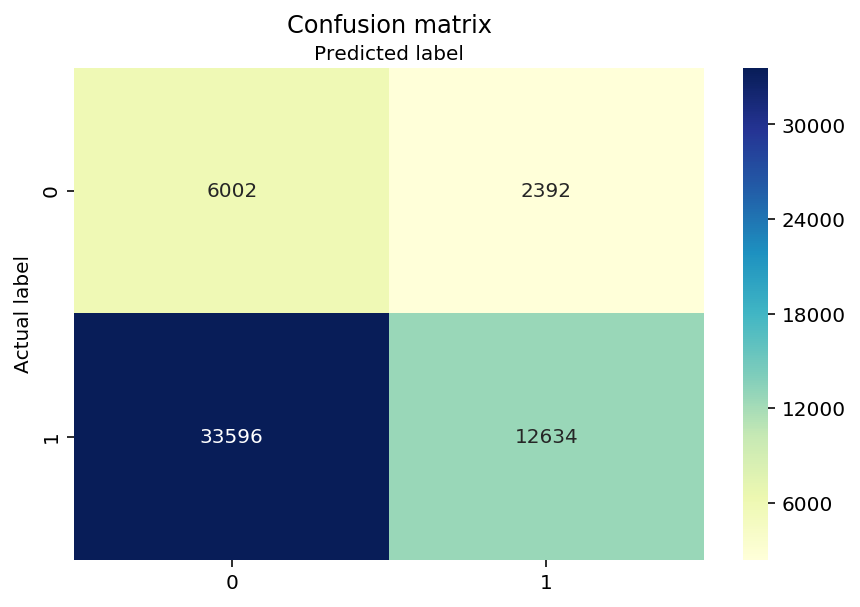

In [173]:
logreg_nearmiss.fit(X_train_nearmiss,y_train_nearmiss)

yhat = logreg_nearmiss.predict(X_test)
yhat_pp = logreg_nearmiss.predict_proba(X_test)

recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,
                                                                  yhat_pp,
                                                                  "Logistic Regression with NearMiss")
model_results.loc['Logistic Regression with NearMiss'] = [recall, precision, f1_score, 
                                            roc_auc, accuracy]

              Prediced Not Approved  Prediced Approved
Not Approved                   6262               2132
Approved                      34400              11830
TN = 6262, FP = 2132
FN = 34400, TP = 11830
Sensitivity / Recall (true positive rate) : 0.25589444083928187
Precision (positive predictive value) : 0.8472998137802608
f1 score : 0.39307549175970236
Accuracy : 0.33120972466315174

ROC AUC Score : 0.49689895329683226

              precision    recall  f1-score   support

           0       0.15      0.75      0.26      8394
           1       0.85      0.26      0.39     46230

   micro avg       0.33      0.33      0.33     54624
   macro avg       0.50      0.50      0.32     54624
weighted avg       0.74      0.33      0.37     54624
 



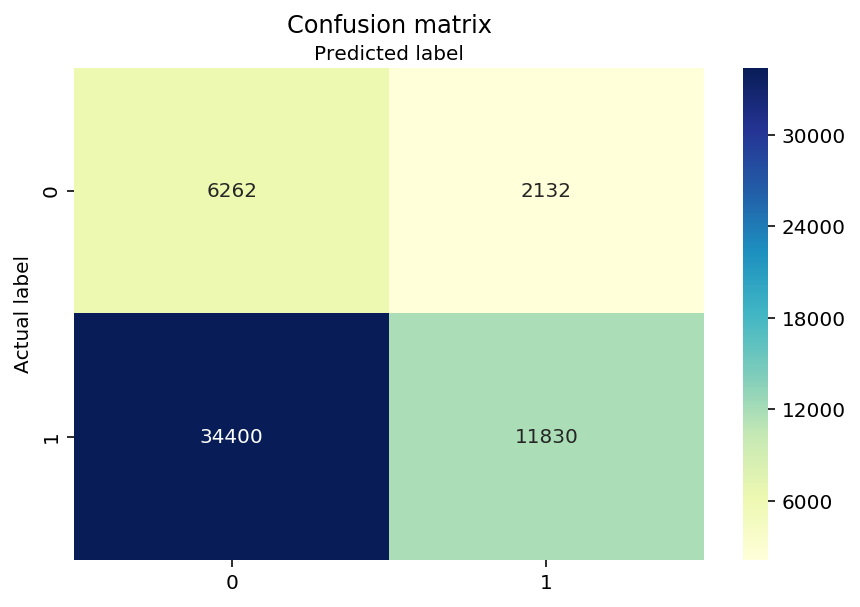

In [174]:
rfc_nearmiss.fit(X_train_nearmiss,y_train_nearmiss)

yhat = rfc_nearmiss.predict(X_test)
yhat_pp = rfc_nearmiss.predict_proba(X_test)

recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,
                                                                  yhat_pp,
                                                                  'Random Forest with NearMiss')
model_results.loc['Random Forest with NearMiss'] = [recall, precision, f1_score, 
                                            roc_auc, accuracy]


In [175]:
# xgb_nearmiss.fit(X_train_nearmiss,y_train_nearmiss)

# yhat = xgb_nearmiss.predict(X_test.values)
# yhat_pp = xgb_nearmiss.predict_proba(X_test.values)

# recall, precision, f1_score, roc_auc, accuracy = model_evaluation(yhat,
#                                                                   yhat_pp,
#                                                                   "XGBoost with NearMiss")
# model_results.loc['XGBoost with NearMiss'] = [recall, precision, f1_score, 
#                                             roc_auc, accuracy]

In [176]:
# Oversampling is better than undersamping in terms of both AUC, Precision and Recall.


In [177]:
model_results.sort_values(by='ROC_AUC', ascending=False)


Recall  Precision  f1_score   ROC_AUC  \
Logistic Regression                0.999762   0.846424  0.916725  0.633968   
XGBoost                            0.580489   0.888051  0.702063  0.630156   
Logistic Regression with SMOTE     0.541012   0.890642  0.673135  0.622180   
Logistic Regression with ADASYN    0.531278   0.890730  0.665574  0.619872   
Random Forest                      0.902834   0.853538  0.877494  0.560713   
Random Forest with ADASYN          0.902834   0.853538  0.877494  0.560713   
Random Forest with SMOTE           0.894527   0.853188  0.873369  0.552713   
Random Forest with NearMiss        0.255894   0.847300  0.393075  0.496899   
Logistic Regression with NearMiss  0.273286   0.840809  0.412498  0.478420   

                                   Accuracy  
Logistic Regression                0.846276  
XGBoost                            0.583022  
Logistic Regression with SMOTE     0.555324  
Logistic Regression with ADASYN    0.548147  
Random Forest                      0.786651  
Random Forest with ADASYN          0.786651  
Random Forest with SMOTE           0.780463  
Random Forest with NearMiss        0.331210  
Logistic Regression with NearMiss  0.341169

# 7. Getting Important Features From Selective Best Model

In [178]:
X_train.columns

Index(['budget', 'proj_resource_sum_21st century',
       'proj_resource_sum_alternative seating', 'proj_resource_sum_class set',
       'proj_resource_sum_classroom library',
       'proj_resource_sum_enhance learning',
       'proj_resource_sum_flexible seating',
       'proj_resource_sum_flexible seating options',
       'proj_resource_sum_hokki stools',
       'proj_resource_sum_learning environment',
       ...
       'subcat_Special Needs', 'subcat_Special Needs, Team Sports',
       'subcat_Special Needs, Visual Arts',
       'subcat_Special Needs, Warmth, Care & Hunger', 'subcat_Team Sports',
       'subcat_Team Sports, Visual Arts', 'subcat_Visual Arts',
       'subcat_Visual Arts, Warmth, Care & Hunger',
       'subcat_Warmth, Care & Hunger',
       'teacher_number_of_previously_posted_projects'],
      dtype='object', length=927)

In [179]:
sum(X_train.columns == X_test.columns)

927

In [181]:
features_importance_df = pd.DataFrame({'Features': X.columns,
                                       'feature_importances': xgb.feature_importances_})
features_importance_df.head()

Features  feature_importances
0                                 budget             0.008324
1         proj_resource_sum_21st century             0.000000
2  proj_resource_sum_alternative seating             0.003420
3            proj_resource_sum_class set             0.011415
4    proj_resource_sum_classroom library             0.008981

In [182]:
features_importance_df.sort_values(by='feature_importances', ascending=False).head(20)

Features  feature_importances
24                proj_resource_sum_need supplies             0.076762
22               proj_resource_sum_need materials             0.063319
18                   proj_resource_sum_need hands             0.046693
13             proj_resource_sum_need chromebooks             0.043816
44         proj_resource_sum_students need wobble             0.035792
926  teacher_number_of_previously_posted_projects             0.030735
32    proj_resource_sum_students need chromebooks             0.030189
838                               subcat_Literacy             0.029355
8                  proj_resource_sum_hokki stools             0.028012
37     proj_resource_sum_students need headphones             0.023874
11                   proj_resource_sum_need basic             0.022958
38           proj_resource_sum_students need ipad             0.022832
36          proj_resource_sum_students need hands             0.021625
42       proj_resource_sum_students need supplies             0.020483
16                proj_resource_sum_need flexible             0.019550
33          proj_resource_sum_students need class             0.019501
840                  subcat_Literacy, Mathematics             0.016846
19              proj_resource_sum_need headphones             0.015440
45                proj_resource_sum_wobble chairs             0.015350
25                 proj_resource_sum_need variety             0.014968

In [183]:
shap.TreeExplainer(xgb).shap_values(X_test)


array([[ 1.13927886e-01,  0.00000000e+00,  3.11221447e-05, ...,
         0.00000000e+00, -3.09182773e-03, -5.40553555e-02],
       [-1.59587502e-01,  0.00000000e+00,  4.17237425e-05, ...,
         0.00000000e+00, -1.71590515e-03, -1.42748550e-01],
       [-1.20184124e-01,  0.00000000e+00,  4.17237425e-05, ...,
         0.00000000e+00, -3.43730417e-03,  5.95861524e-02],
       ...,
       [ 1.45965487e-01,  0.00000000e+00,  3.11221447e-05, ...,
         0.00000000e+00, -5.31634595e-03, -5.57682402e-02],
       [ 1.57736197e-01,  0.00000000e+00,  3.11221447e-05, ...,
         0.00000000e+00, -2.32505403e-03, -5.41266724e-02],
       [-6.64492920e-02,  0.00000000e+00,  3.11221447e-05, ...,
         0.00000000e+00, -7.88978580e-03,  6.62764966e-01]], dtype=float32)

In [185]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)


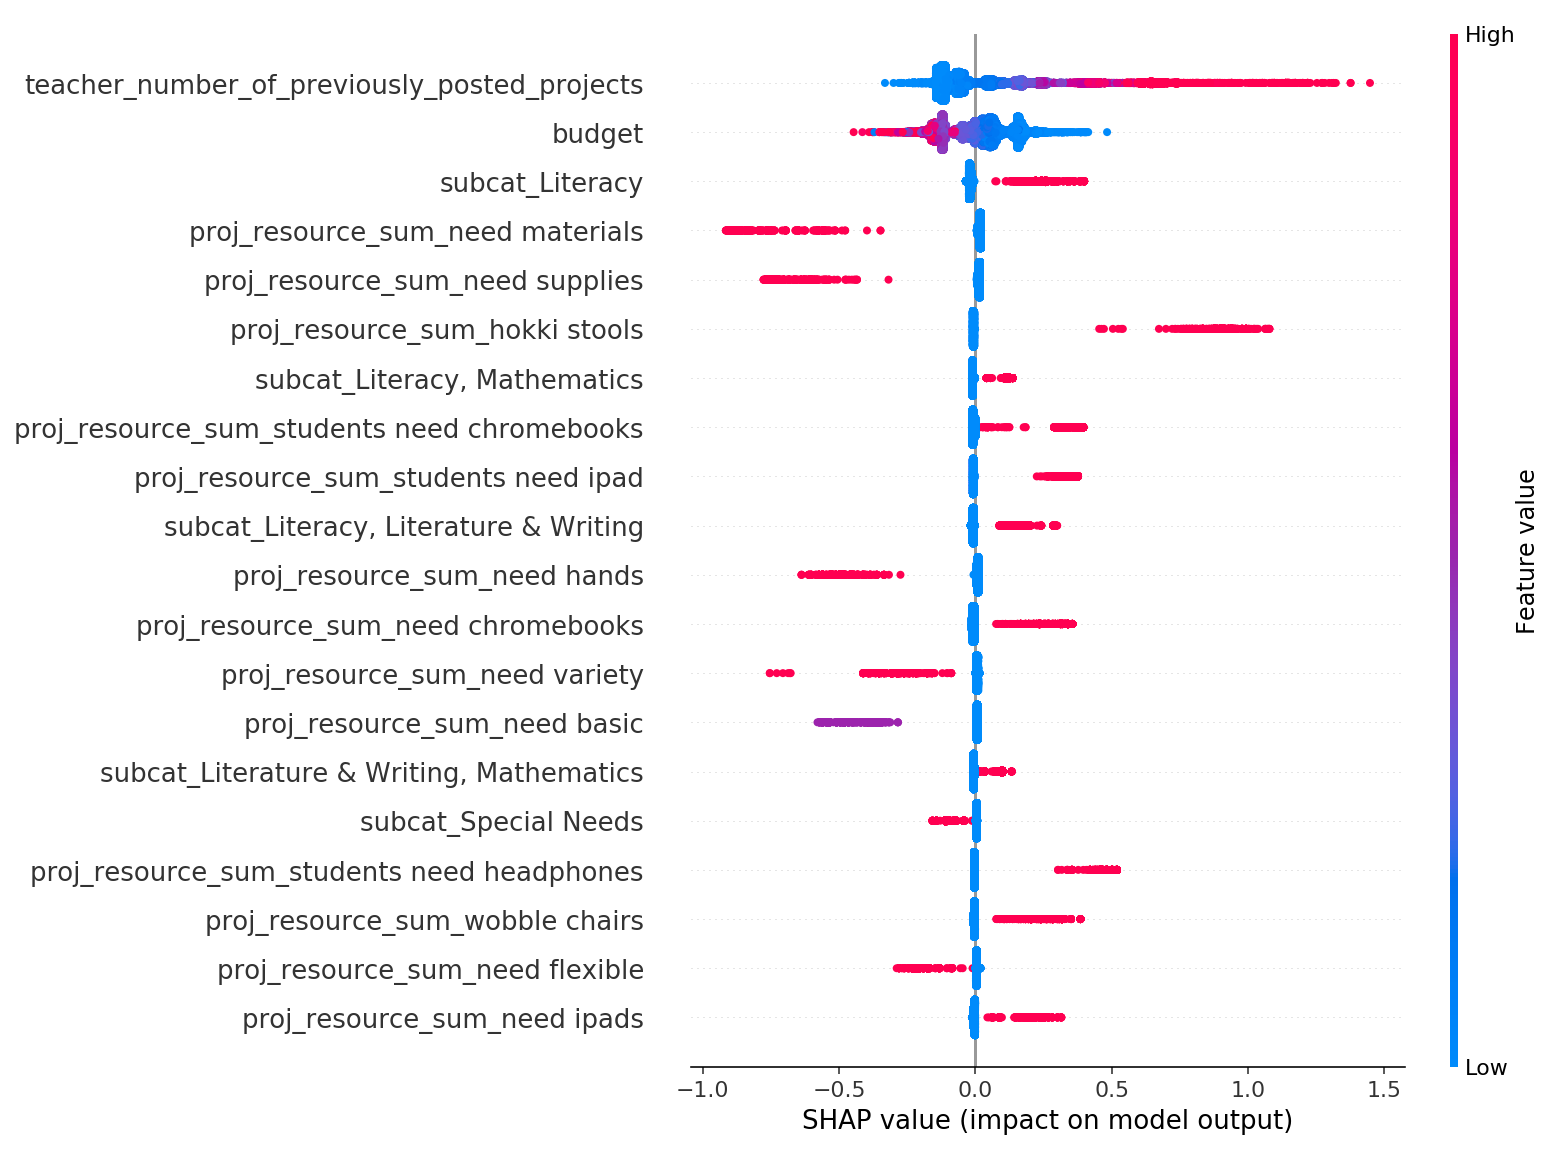

In [186]:
shap.summary_plot(shap_values, X_test)


In [187]:
xgb.plot_tree(3,num_trees=0)
plt.rcParams['figure.figsize'] = [80, 50]
plt.show()

AttributeError: 'XGBClassifier' object has no attribute 'plot_tree'

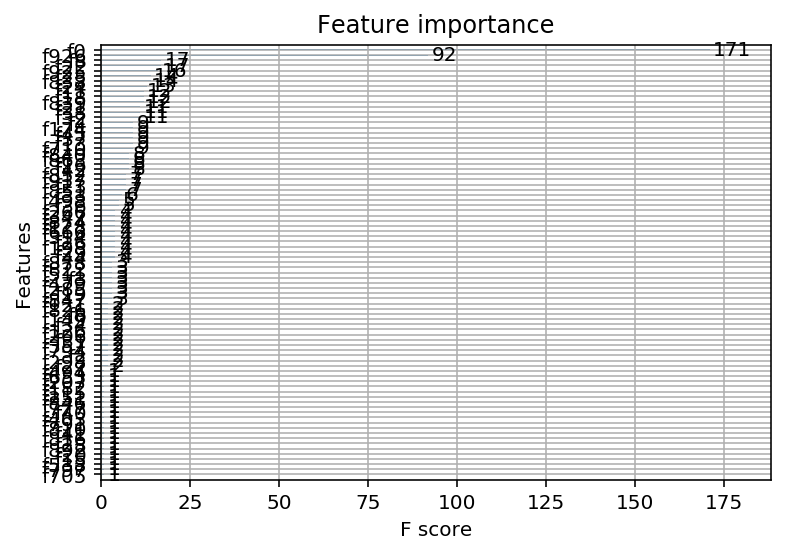

In [188]:
# plot feature importance using built-in function

# plot feature importance
plot_importance(xgb)
plt.show()

# 8. Getting CSV out for Prediction of Test (For Kaggle Competition)

In [ ]:
test.index = pd.RangeIndex(len(test.index))
test.head()

test_features = X.columns
test[test_features].head()

prediction = pd.DataFrame({'id': test["id"], 
                           'project_is_approved': xgb.predict_proba(test[test_features].values)[:, 1]})
prediction.to_csv("XGBoost_prediction_with_project_title.csv",index=False)

In [ ]:
ending_time = datetime.datetime.now()
print("Program ended at ", ending_time)
diff = ending_time - starting_time
print("Total running time is",int(diff.seconds/(60*60)),"hours",
      round((diff.seconds%(60*60))/60,2),"minutes")

In [ ]:
prediction = pd.DataFrame({'id': test["id"], 
                           'project_is_approved': logreg_svmsmote.predict_proba(test[test_features])[:, 1]})
prediction.to_csv("logreg_svmsmote_prediction.csv",index=False)


In [ ]:
test_predict = xgb_svmsmote.predict(test[test_features].values)
print(np.bincount(test_predict))